In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST 3.23

In [4]:
folder="data/puma8NH"
x_col=["theta1", "theta2", "theta3", "thetad1", "thetad2", "thetad3", "tau1","tau2"]
target_col=["target"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_row + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [11]:
def plot_training_RMSE(model, model_state, avg_rmse, train_loss, val_loss):
    model.load_state_dict(model_state)
    print(avg_rmse)
    plt.figure(figsize=(5, 4))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')

In [12]:
def plot_sorted_feature_importance(columns, importances):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    print(sorted_pairs)
    sorted_columns, sorted_importances = zip(*sorted_pairs)
    
    # Create the bar plot
    plt.figure(figsize=(6, 3))
    plt.barh(sorted_columns, sorted_importances, color='royalblue')
    plt.xlabel('Importance')
    plt.title('KAN Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [13]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
            metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')
    
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        
        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"Best epoch: {best_epoch} ")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [14]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [15]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    print(sorted_scores)
    features, scores = zip(*sorted_scores)

    plt.figure(figsize=(6, 3))
    plt.barh(features, scores, color='royalblue')
    plt.xlabel("Grad-CAM Relevance")
    plt.title("Feature Relevance for Test")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [16]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Combines all steps: compute average relevance and plot.
    """
    avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
    plot_feature_relevance_bar(avg_scores)
    return avg_scores

### CNN Functions

In [17]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [18]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [8, 6, 5]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

### Hybrid Functions

In [17]:
def print_mkan_vs_cnn_relevance(feature_scores, mkan_len):
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()
    m_kan_relevance_perct = float(mkan_relevance/(mkan_relevance+cnn_relevance))
    cnn_relevance_perct = float(cnn_relevance/(mkan_relevance+cnn_relevance))
    print(f"M_KAN Relevance: {m_kan_relevance_perct}")
    print(f"CNN Relevance: {cnn_relevance_perct}")

In [18]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=6, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [19]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()

            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val += model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [20]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [21]:
def cnn_branch_relevance(model, best_model_state):
    avg_scores = compute_avg_feature_relevance_from_val(
        model=model,
        model_state=best_model_state,
        val_inputs=dataset["test_input"],
        val_imgs=dataset["test_img"],
        coordinate=completed_coordinate,
        x_col=completed_x_col,
        zoom=2
    )
    plot_feature_relevance_bar(avg_scores)

In [22]:
def train_and_plot_relevance(model_class, kan_neurons, kan_grid, cnn_bottleneck_dim, lamb, steps, alpha=1.0, n_kan_len=None):
    torch.cuda.empty_cache()
    gc.collect()
    model = try_create_model(model_class, attributes, imgs_shape, kan_neurons=kan_neurons, kan_grid=kan_grid, cnn_bottleneck_dim=cnn_bottleneck_dim, alpha=alpha)
    best_model_state, metrics3, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", lamb=lamb, steps=steps)
    plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics3['train_loss'], metrics3['eval_loss'])
    if not n_kan_len:
        n_kan_len = kan_neurons
    print_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=n_kan_len)
    #plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=kan_neurons)
    plot_sorted_feature_importance(x_col, model.m_kan.feature_score)
    
    cnn_branch_relevance(model, best_model_state)

### Models Class

In [22]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [23]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 6, 6]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

### Models Class Hybrids

In [23]:
class Model3_0(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha=1.0, device=device):
        super(Model3_0, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)

        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, 1).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[2, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [24]:
class Model3_1(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha=1.0, device=device):
        super(Model3_1, self).__init__()

        self.device = device

        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Dummy pass to get flattened size
        self.flat_size = self._get_flat_size(imgs_shape)

        # Bottleneck layer
        self.cnn_bottleneck = nn.Linear(self.flat_size, cnn_bottleneck_dim).to(device)

        # KAN branch
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Final KAN layer
        self.final_kan = KAN(
            width=[cnn_bottleneck_dim + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
        x = self.cnn_branch(dummy_input)
        return x.shape[1]

    def get_concat_output(self, mlp_input, cnn_input):
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)

        conv_out = self.cnn_branch(cnn_input)
        cnn_output = self.cnn_bottleneck(conv_out)

        kan_output = self.m_kan(kan_input)

        return torch.cat((kan_output, cnn_output), dim=1)

    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [25]:
class Model3_2(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, cnn_bottleneck_dim, alpha=1.0, device=device):
        super(Model3_2, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device
        self.alpha = alpha


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        cnn_output = cnn_output * self.alpha
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

# Load Dataset and Images

In [26]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [27]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [28]:
from TINTOlib.igtd import IGTD
dataset_name = 'puma8NH'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem=problem_type, 
                   scale=[image_size,image_size],
                   fea_dist_method='Euclidean',
                   image_dist_method='Euclidean',
                   error='abs',
                   max_step=30000,
                   val_step=300,
                   zoom=2,
                   random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [29]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 6, 6)
Attributes:  8


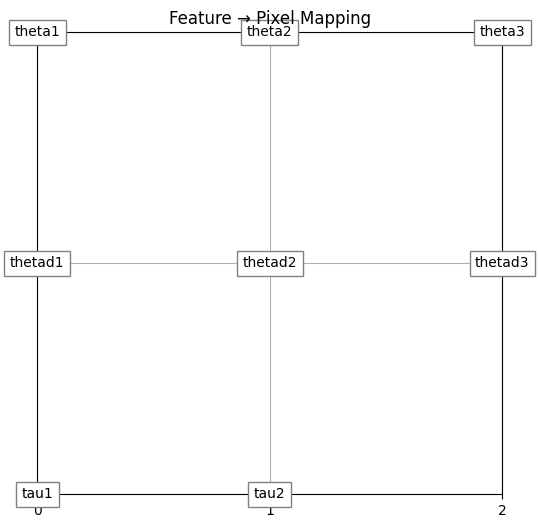

In [30]:
if hasattr(image_model, 'coordinate'):
    coordinates = image_model.coordinate
else:
    coordinates = (np.array([0, 0, 0, 1, 1, 1, 2, 2]),
                 np.array([0, 1, 2, 0, 1, 2, 0, 1]))

plot_feature_mapping(x_col, coordinates, scale=[3, 3])

In [31]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [32]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([5242, 8])
Train target shape: torch.Size([5242, 1])
Test data shape: torch.Size([1639, 8])
Test target shape: torch.Size([1639, 1])
Validation data shape: torch.Size([1311, 8])
Validation target shape: torch.Size([1311, 1])


In [33]:
completed_coordinate, completed_x_col = complete_coordinate_and_xcol(coordinates, x_col)

# KAN training ✅ Top 2 Configurations

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.12e+00 | reg: 3.06e+01 | : 100%|█| 40/40 [00:11<00:00,  3.51it/

saving model version 0.1
Best epoch: 32 
3.232741117477417


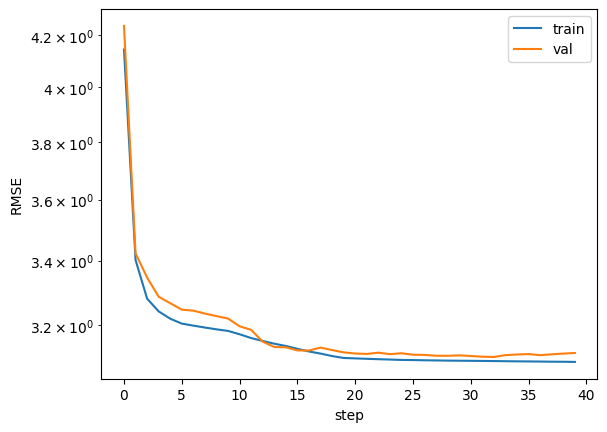

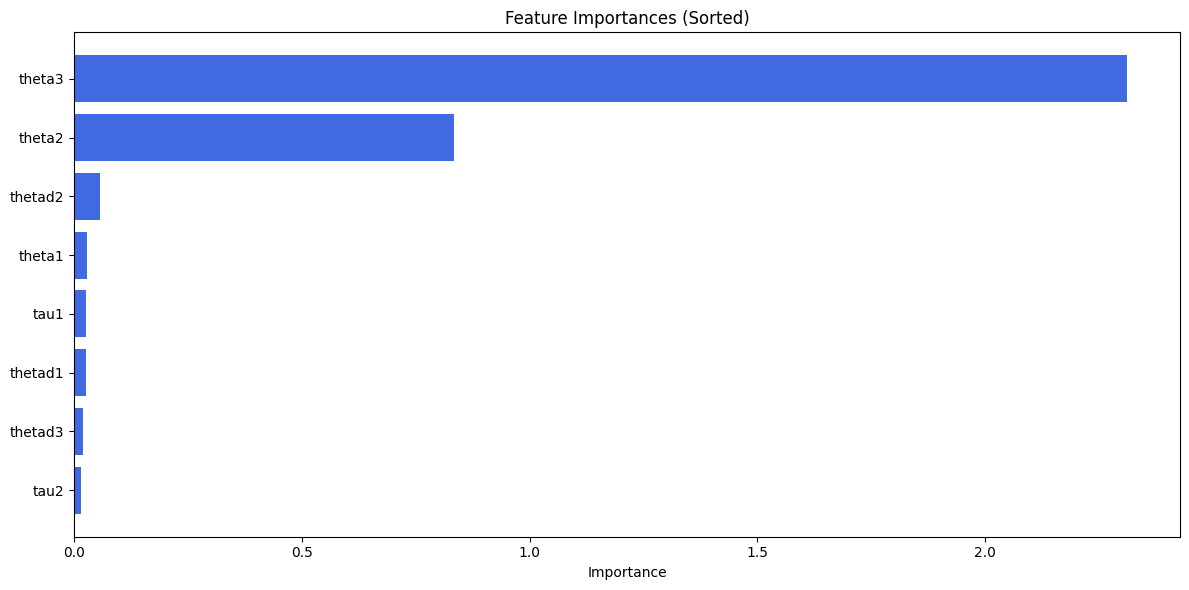

In [33]:
model = KAN(width=[attributes, 2, 1], grid=4, k=3, seed=381, device=device)
best_model_state, results, _  = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=1e-05)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input']), dataset['test_label']), results['train_loss'], results['val_loss'])
plot_sorted_feature_importance(x_col, model.feature_score)

### 1. width=[8, 2, 1], grid=4, lamb=1e-05 | best_epoch=32 | loss=3.22794

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.11e+00 | reg: 3.18e+01 | : 100%|█| 40/40 [00:12<00:00,  3.29it/


saving model version 0.1
Best epoch: 31 
3.2312042713165283


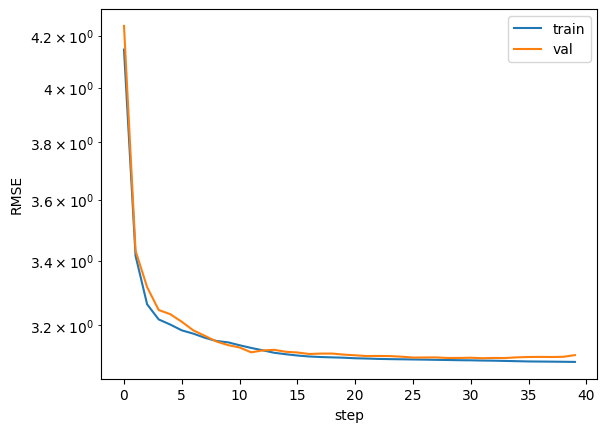

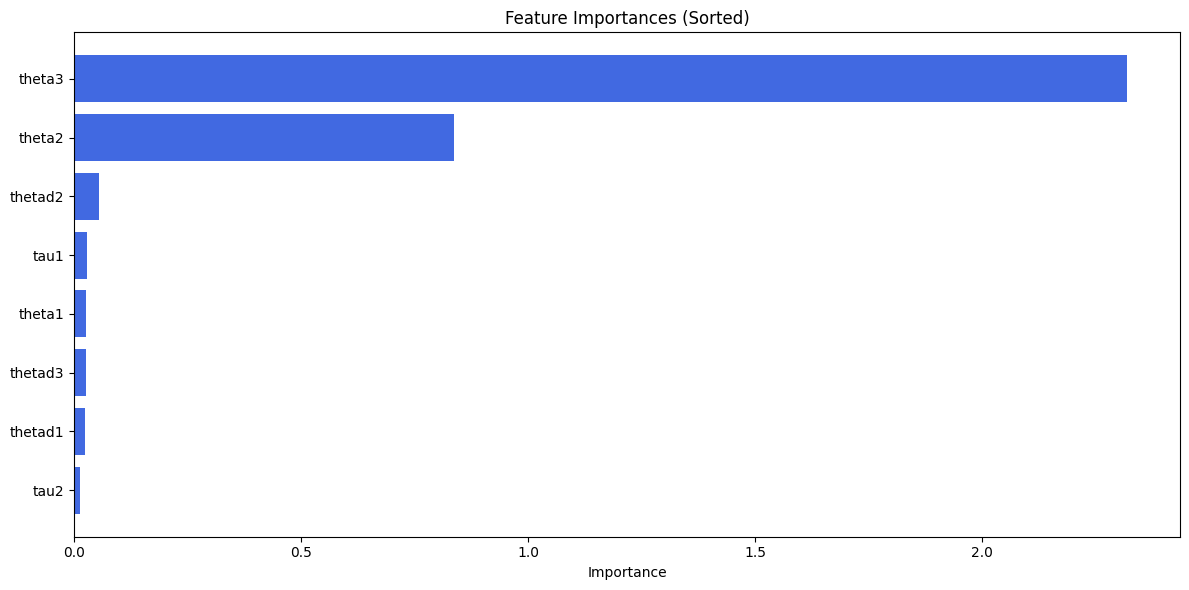

In [32]:
model = KAN(width=[attributes, 2, 1], grid=4, k=3, seed=381, device=device)
best_model_state, results, _  = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=1e-05)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input']), dataset['test_label']), results['train_loss'], results['val_loss'])
plot_sorted_feature_importance(x_col, model.feature_score)

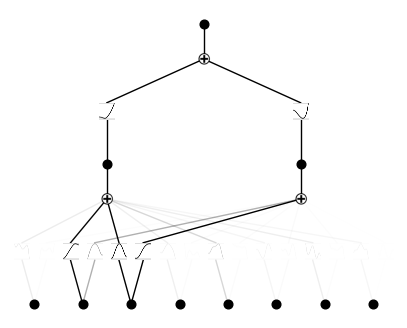

In [43]:
model.plot()

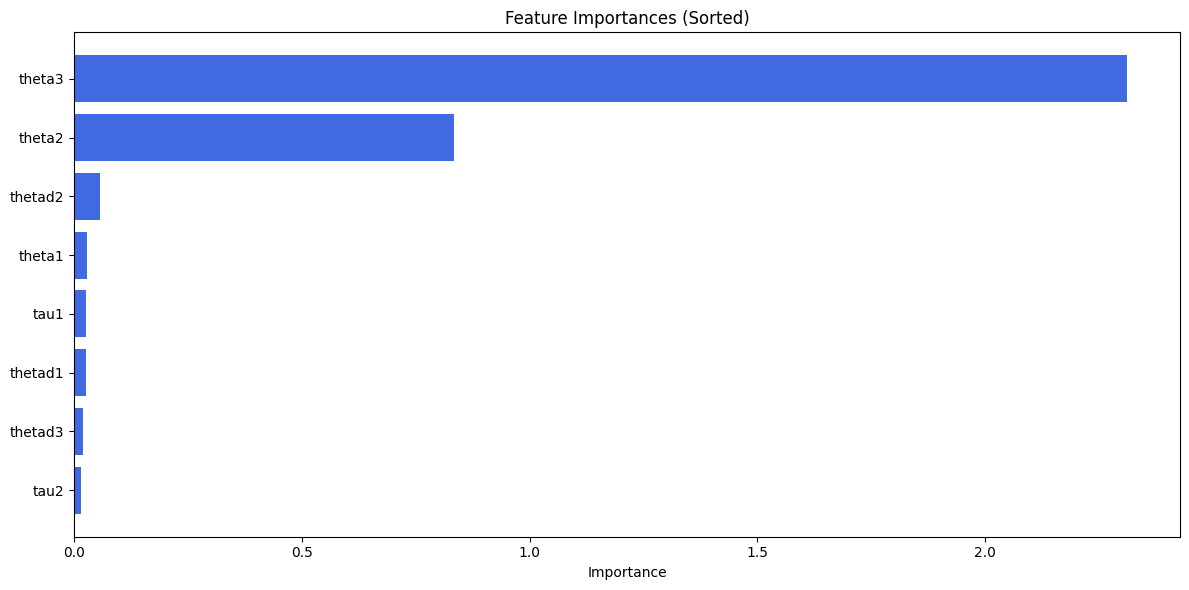

In [44]:
plot_sorted_feature_importance(x_col, model.feature_score)

### 2. width=[8, 3, 1], grid=5, lamb=0.0001 | best_epoch=19 | loss=3.23315

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.08e+00 | val_loss: 3.10e+00 | reg: 4.68e+01 | : 100%|█| 40/40 [00:56<00:00,  1.40s/i


saving model version 0.1
Best epoch: 28 
3.254410982131958


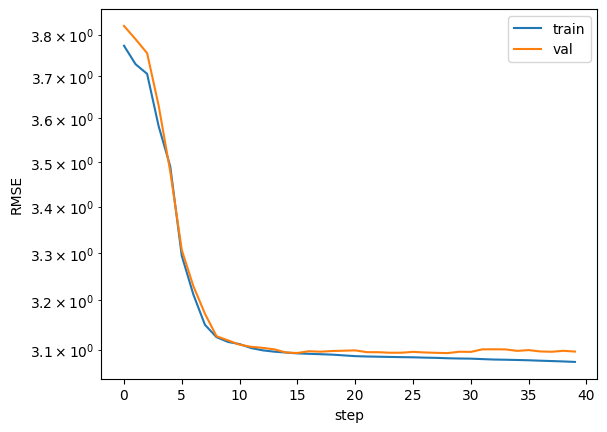

In [35]:
model = KAN(width=[attributes, 3, 1], grid=5, k=3, seed=381, device=device)
best_model_state, results, best_epoch  = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=0.0001)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input']), dataset['test_label']), results['train_loss'], results['val_loss'])

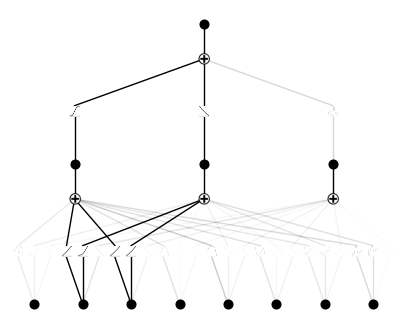

In [36]:
model.plot()

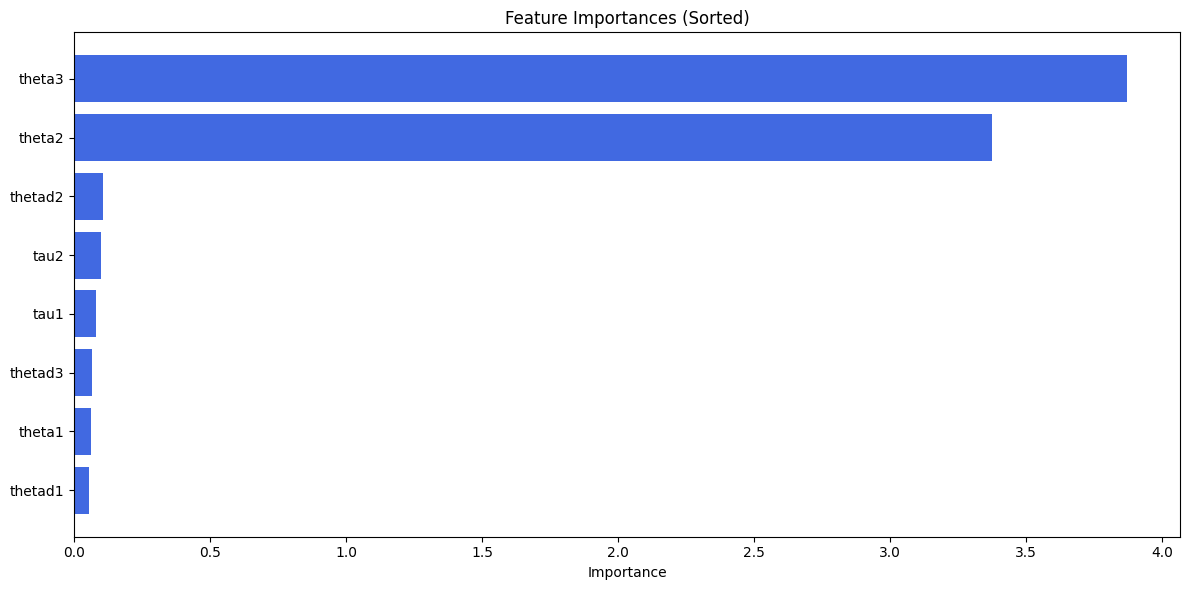

In [37]:
plot_sorted_feature_importance(x_col, model.feature_score)

# CNN training ✅ Top 2 Configurations

### 1. cnn_blocks=1, dense_layers=1 | best_epoch=18 | loss=3.22069

In [47]:
build_custom_cnn_model(cnn_blocks=1, dense_layers=1, imgs_shape=imgs_shape)

CustomCNNModel(
  (cnn_branch): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): LayerNorm((16, 8, 8), eps=1e-05, elementwise_affine=True)
    (2): Sigmoid()
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=1, bias=True)
  )
)

| Train: 8.9853e+00 | Val: 1.0173e+01 |: 100%|████████████████████| 100/100 [00:37<00:00,  2.68it/s]


✅ Best validation loss: 9.5183e+00 at 22 epoch
3.311112880706787


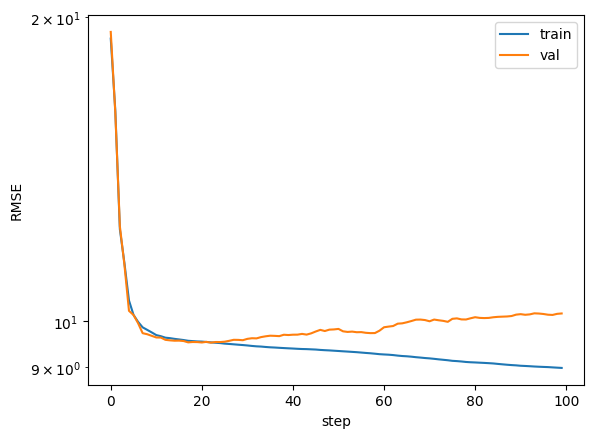

In [38]:
model = build_custom_cnn_model(cnn_blocks=1, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model, dataset, steps=100)
plot_training_RMSE(model, model_state, average_rmse(model(0, dataset['test_img']), dataset['test_label']), results['train_loss'], results['val_loss'])

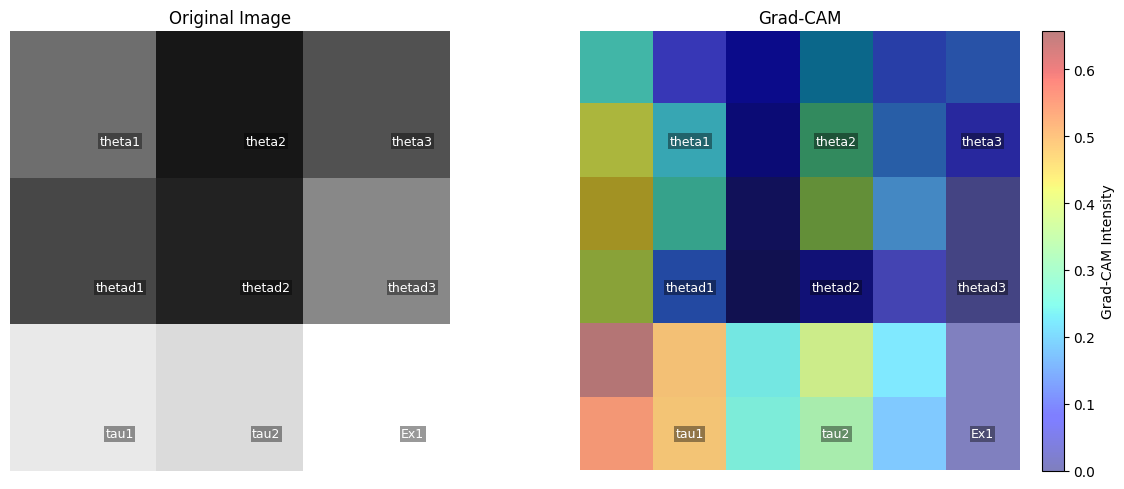

In [39]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [06:11<00:00,  4.41it/s]


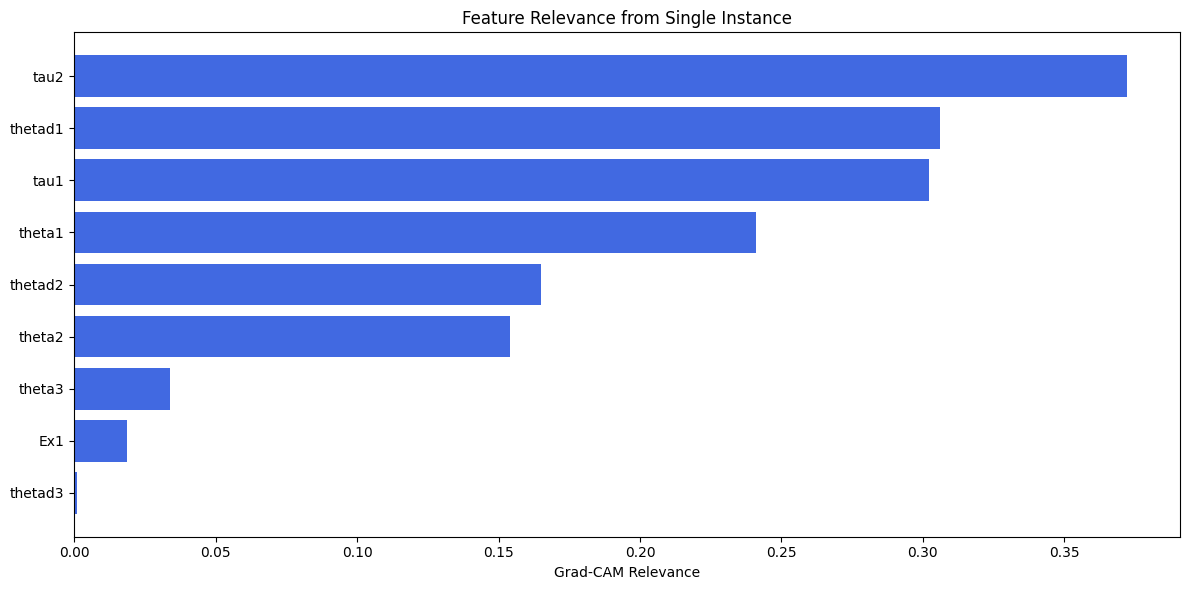

In [40]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. cnn_blocks=3, dense_layers=2 | best_epoch=4 | loss=3.24624

| Train: 2.5414e+00 | Val: 1.7249e+01 |: 100%|████████████████████| 110/110 [01:03<00:00,  1.73it/s]


✅ Best validation loss: 9.8724e+00 at 3 epoch
4.303581714630127


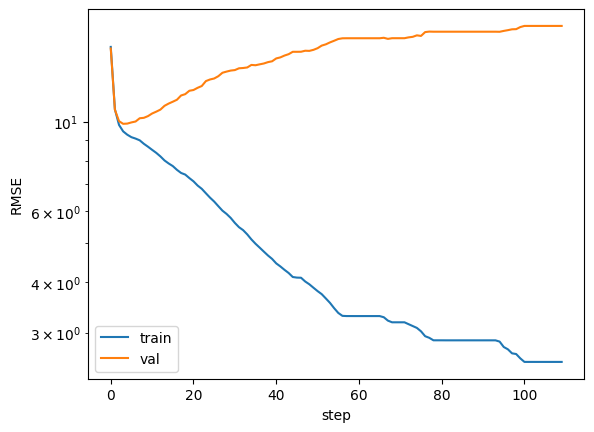

In [41]:
model = build_custom_cnn_model(cnn_blocks=3, dense_layers=2, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model, dataset, steps=110)
plot_training_RMSE(model, model_state, average_rmse(model(0, dataset['test_img']), dataset['test_label']), results['train_loss'], results['val_loss'])

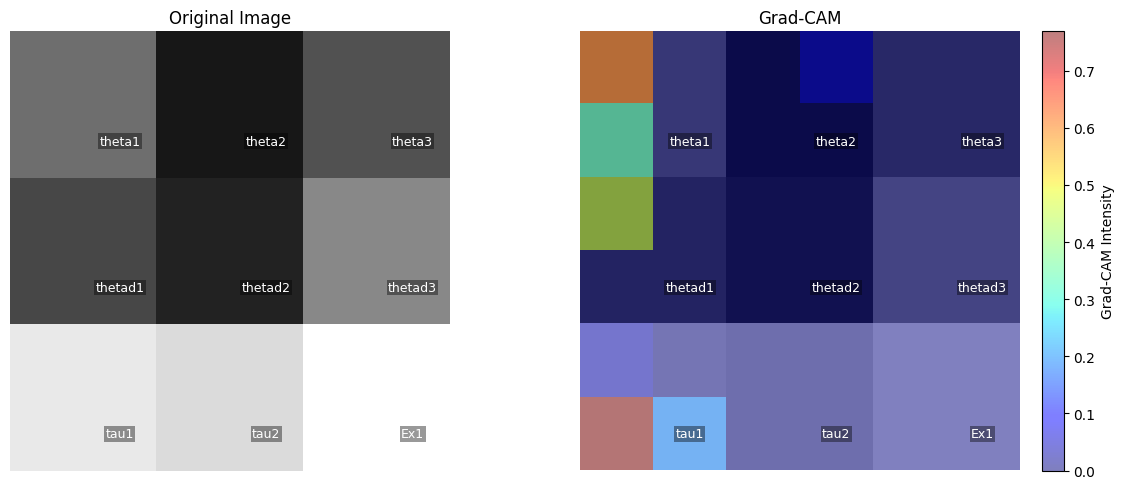

In [42]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [06:16<00:00,  4.35it/s] 


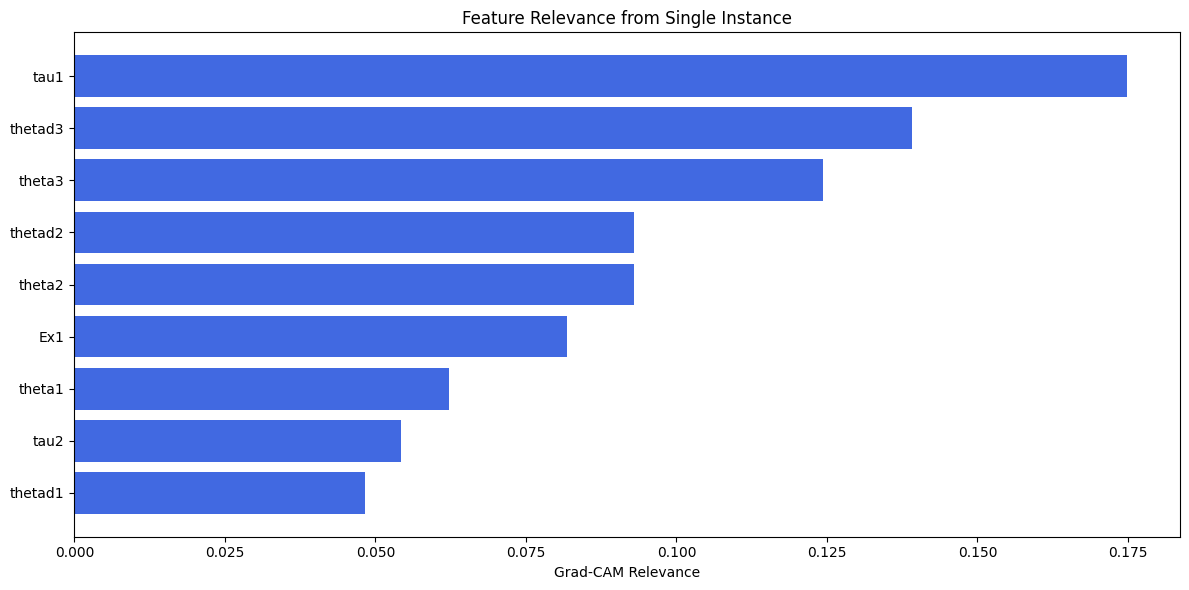

In [43]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

# Option 0: Concat full best KAN with full best CNN

### 0.1.1 width=[8, 2, 1], grid=4, lamb=1e-05

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.11e+00 | eval_loss: 3.24e+00 | reg: 2.21e+01 |: 100%|█| 25/25 [01:10<00:00,  2.82s/i


saving model version 0.1
Best epoch 13
3.3582990169525146
M_KAN Relevance: 0.8026420474052429
CNN Relevance: 0.19735795259475708
[('theta3', 1.5952454), ('theta2', 1.0178009), ('thetad2', 0.12503283), ('thetad1', 0.08194944), ('thetad3', 0.07353458), ('tau2', 0.069669865), ('theta1', 0.0690386), ('tau1', 0.052775946)]


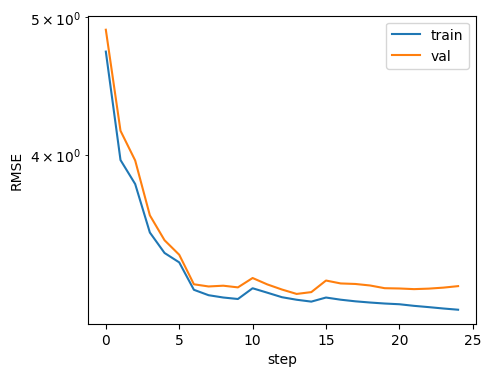

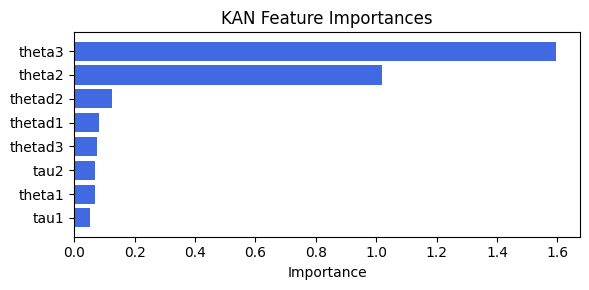

Computing Grad-CAM:   0%|          | 0/1639 [00:00<?, ?it/s]C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be stric

[('thetad2', 0.31742497028953714), ('thetad3', 0.3051745532452151), ('tau1', 0.28527062226233013), ('thetad1', 0.2750293794153767), ('theta2', 0.24657546983900358), ('theta1', 0.22338628926564574), ('theta3', 0.17675501970912566), ('tau2', 0.17108010114389155), ('Ex1', 0.1601184492816743)]


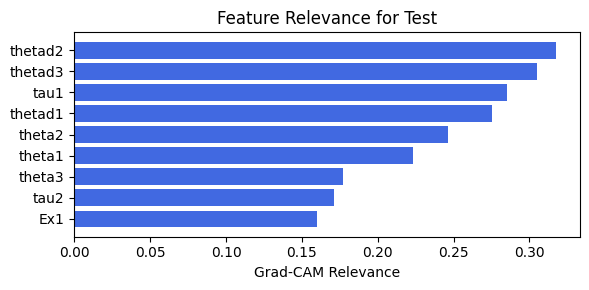

In [33]:
train_and_plot_relevance(Model3_0, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, n_kan_len=1)

### 0.1.2 width=[8, 2, 1], grid=4, lamb=1e-05

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.06e+00 | eval_loss: 3.15e+00 | reg: 2.62e+01 |: 100%|█| 25/25 [00:10<00:00,  2.28it/

saving model version 0.1
Best epoch 17
3.2925727367401123
M_KAN Relevance: 0.6468105912208557
CNN Relevance: 0.3531893789768219
[('theta3', 0.74728304), ('theta2', 0.7177725), ('thetad3', 0.15599914), ('thetad2', 0.092359126), ('thetad1', 0.086034395), ('tau2', 0.038294327), ('theta1', 0.032811783), ('tau1', 0.022657774)]


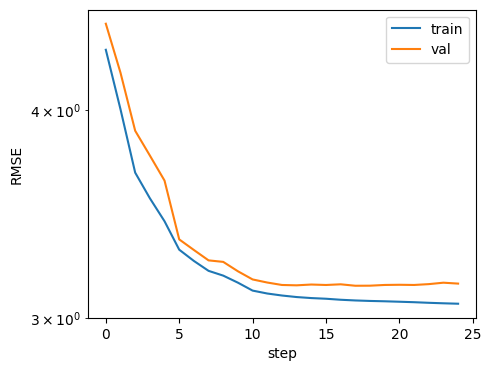

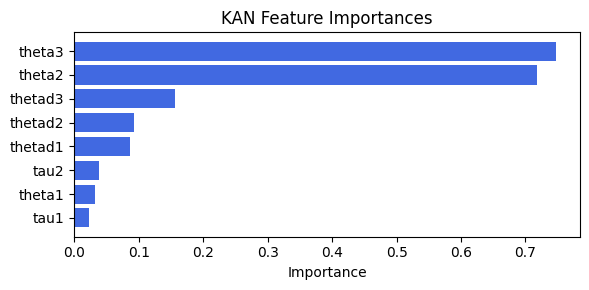

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:20<00:00, 11.66it/s]

[('theta3', 0.28941290965098687), ('thetad2', 0.2519350053243625), ('thetad1', 0.22538070408695934), ('tau2', 0.2102389641815275), ('theta1', 0.17266162996095974), ('theta2', 0.17256922238525413), ('Ex1', 0.14691665976821394), ('tau1', 0.14073936390749317), ('thetad3', 0.03368727540922194)]


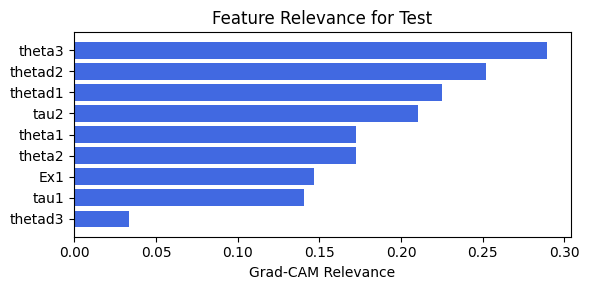

In [35]:
train_and_plot_relevance(Model3_0, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, n_kan_len=1)

### 0.2.1 width=[8, 3, 1], grid=5, lamb=0.0001

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.06e+00 | eval_loss: 3.12e+00 | reg: 2.74e+01 |: 100%|█| 30/30 [00:13<00:00,  2.26it/

saving model version 0.1
Best epoch 20
3.2972190380096436
M_KAN Relevance: 0.3124721646308899
CNN Relevance: 0.6875278353691101
[('theta3', 0.98291785), ('theta2', 0.86710626), ('thetad2', 0.3227444), ('tau2', 0.28004277), ('thetad3', 0.25761163), ('theta1', 0.16685376), ('thetad1', 0.1622168), ('tau1', 0.12074029)]


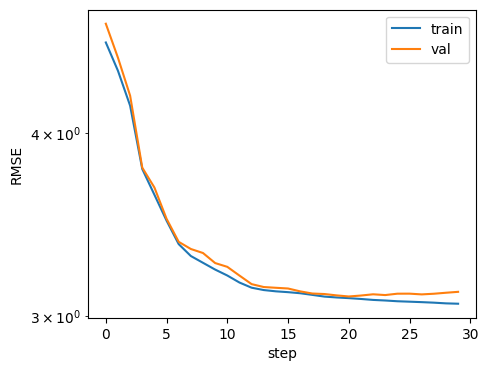

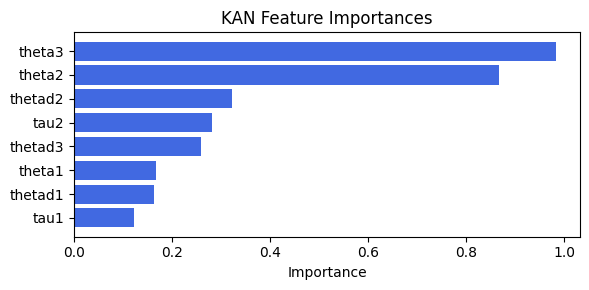

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:35<00:00, 10.57it/s]


[('Ex1', 0.4285962330237889), ('tau1', 0.400715315686884), ('theta1', 0.31022301680806746), ('theta3', 0.24854107339522824), ('thetad1', 0.21079609502847588), ('theta2', 0.16618698419912636), ('thetad2', 0.12929414343508464), ('tau2', 0.12674693288710703), ('thetad3', 0.07272813235453027)]


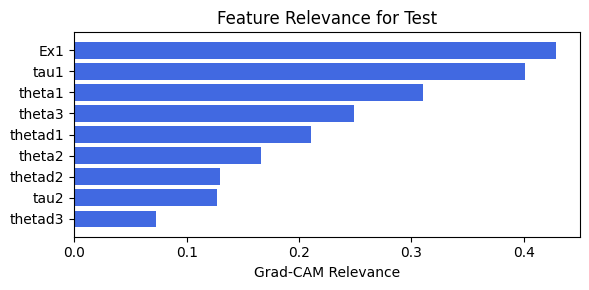

In [92]:
train_and_plot_relevance(Model3_0, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=30, n_kan_len=1)

### 2.2 width=[8, 3, 1], grid=5, lamb=0.0001

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.00e+00 | eval_loss: 3.24e+00 | reg: 3.18e+01 |: 100%|█| 30/30 [00:13<00:00,  2.18it/

saving model version 0.1
Best epoch 11
3.4090330600738525
M_KAN Relevance: 0.310935378074646
CNN Relevance: 0.689064621925354
[('theta3', 1.0943265), ('theta2', 0.7269528), ('thetad2', 0.2849301), ('theta1', 0.25860485), ('thetad3', 0.25597405), ('tau1', 0.19563887), ('thetad1', 0.19429782), ('tau2', 0.16970702)]


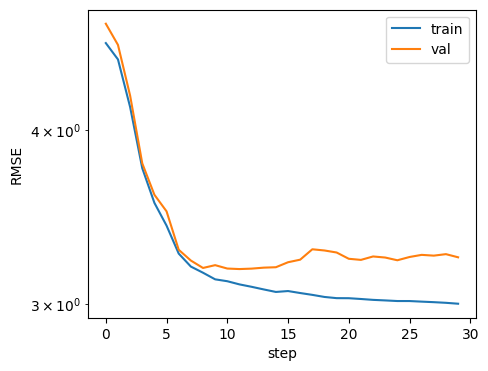

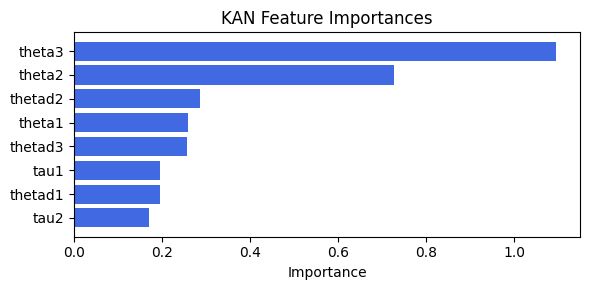

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:32<00:00, 10.72it/s]

[('Ex1', 0.6886963574096442), ('thetad3', 0.42687178958182365), ('theta3', 0.40806633569959316), ('tau1', 0.24692548756486682), ('thetad2', 0.1535121670501793), ('theta2', 0.14134508887530015), ('tau2', 0.10876809821360402), ('theta1', 0.09004665625262738), ('thetad1', 0.07922944070652116)]


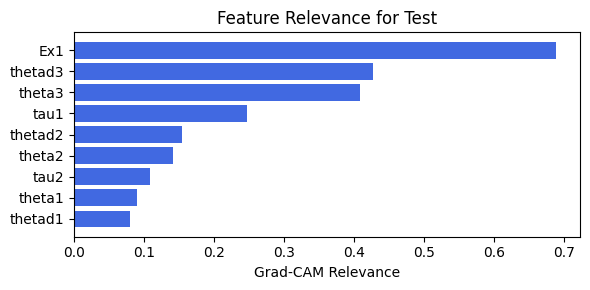

In [93]:
train_and_plot_relevance(Model3_0, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=30, n_kan_len=1)

### 3.1 width=[8, 4, 1], grid=3, lamb=0.01

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.11e+00 | eval_loss: 3.16e+00 | reg: 3.50e+01 |: 100%|█| 30/30 [00:12<00:00,  2.31it/

saving model version 0.1
Best epoch 8
3.3167777061462402
M_KAN Relevance: 0.9999728202819824
CNN Relevance: 2.7227615646552294e-05
[('theta2', 1.0318956), ('theta3', 1.0270593), ('thetad2', 0.10982137), ('thetad3', 0.10473822), ('tau2', 0.07107286), ('thetad1', 0.05592616), ('theta1', 0.04567743), ('tau1', 0.029116169)]


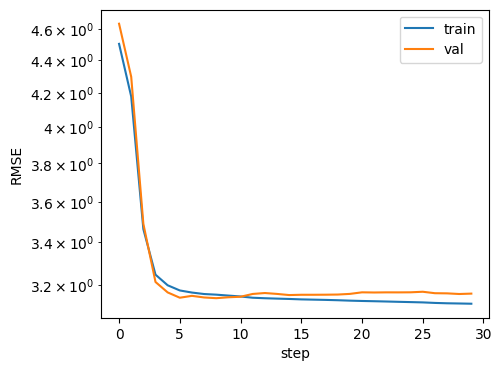

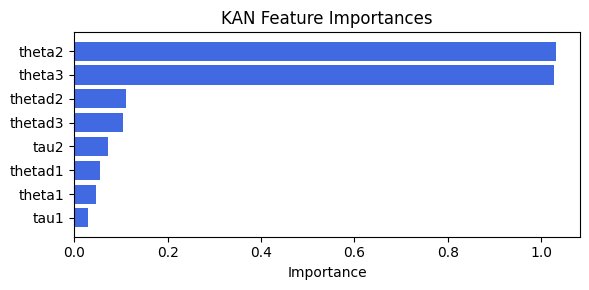

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:34<00:00, 10.62it/s]


[('thetad2', 0.4020585943208189), ('thetad1', 0.28625836576736585), ('theta2', 0.28288685799813007), ('tau2', 0.26503941059336855), ('Ex1', 0.2510156856275597), ('theta1', 0.2387008281139765), ('thetad3', 0.20980045320244486), ('theta3', 0.13689593714771103), ('tau1', 0.12979981318899622)]


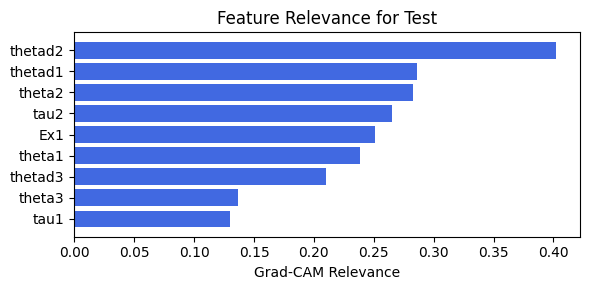

In [39]:
train_and_plot_relevance(Model3_0, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=30, n_kan_len=1)

### 3.2 width=[8, 4, 1], grid=3, lamb=0.01

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.11e+00 | eval_loss: 3.17e+00 | reg: 3.68e+01 |: 100%|█| 30/30 [00:13<00:00,  2.30it/

saving model version 0.1
Best epoch 5
3.3253605365753174
M_KAN Relevance: 0.9999189972877502
CNN Relevance: 8.09701086836867e-05
[('theta3', 1.0579568), ('theta2', 1.0527776), ('thetad2', 0.13026215), ('tau1', 0.10268528), ('thetad3', 0.07637589), ('tau2', 0.062360317), ('thetad1', 0.04973389), ('theta1', 0.04877507)]


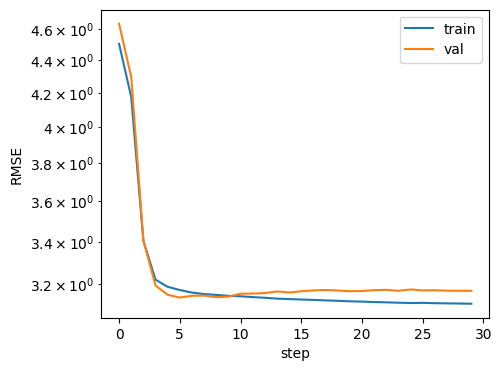

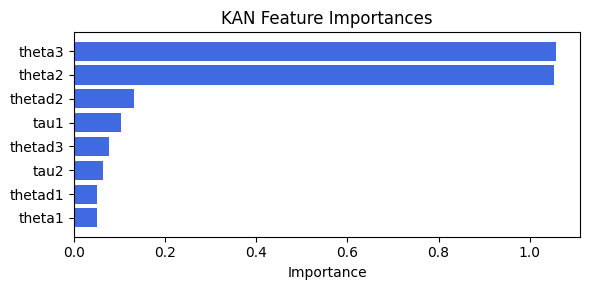

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:34<00:00, 10.63it/s]


[('thetad2', 0.37438715782186877), ('Ex1', 0.2838785862782402), ('tau2', 0.2657193137843437), ('thetad1', 0.23573811039643372), ('theta2', 0.1984614523888672), ('theta1', 0.16432863179171092), ('tau1', 0.11668612905062933), ('theta3', 0.06782345108564307), ('thetad3', 0.05862281191397567)]


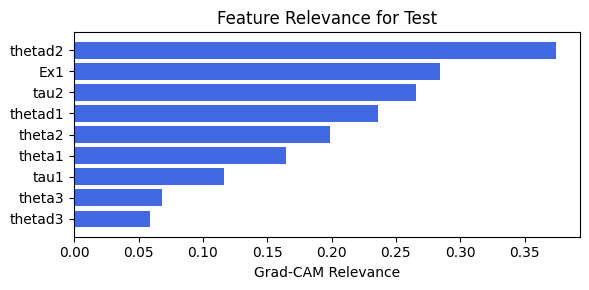

In [40]:
train_and_plot_relevance(Model3_0, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=30, n_kan_len=1)

### 4.1 width=[8, 3, 1], grid=5, lamb=0.01

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.10e+00 | eval_loss: 3.14e+00 | reg: 2.63e+01 |: 100%|█| 30/30 [00:13<00:00,  2.21it/

saving model version 0.1
Best epoch 18
3.3004019260406494
M_KAN Relevance: 0.3348575234413147
CNN Relevance: 0.6651424765586853
[('theta3', 0.9213799), ('theta2', 0.7886441), ('thetad2', 0.22856462), ('theta1', 0.15839832), ('tau2', 0.1104051), ('thetad3', 0.09421709), ('thetad1', 0.07948135), ('tau1', 0.07700902)]


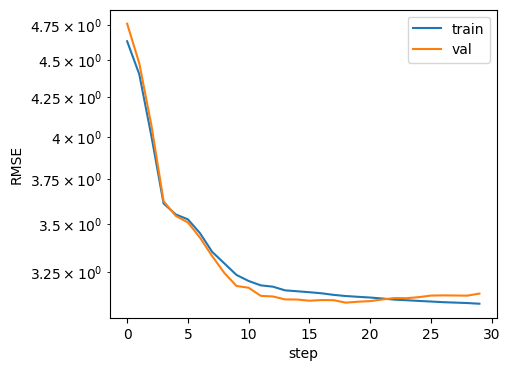

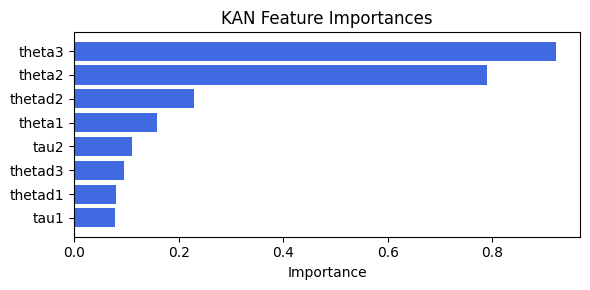

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.80it/s]

[('tau2', 0.5418379975390769), ('tau1', 0.53815958590961), ('Ex1', 0.4470694017817583), ('theta3', 0.419005849362093), ('theta1', 0.411119796006126), ('thetad1', 0.3909276955561568), ('theta2', 0.3447829803771239), ('thetad2', 0.25299031523515453), ('thetad3', 0.24480490698555826)]


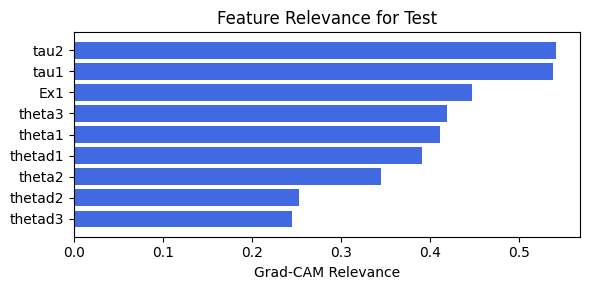

In [41]:
train_and_plot_relevance(Model3_0, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=30, n_kan_len=1)

### 4.2 width=[8, 3, 1], grid=5, lamb=0.01

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_0


| train_loss: 3.06e+00 | eval_loss: 3.16e+00 | reg: 2.64e+01 |: 100%|█| 30/30 [00:16<00:00,  1.81it/

saving model version 0.1
Best epoch 17
3.356045722961426
M_KAN Relevance: 0.35833877325057983
CNN Relevance: 0.6416612267494202
[('theta3', 1.0140219), ('theta2', 0.2529056), ('thetad3', 0.12837997), ('thetad2', 0.12690885), ('tau1', 0.07352896), ('theta1', 0.07036081), ('tau2', 0.060246896), ('thetad1', 0.04894599)]


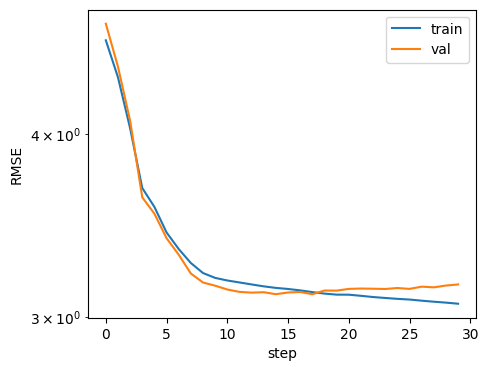

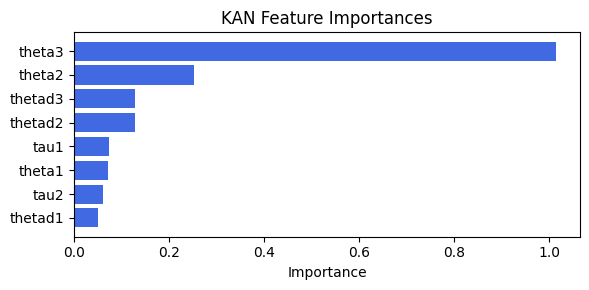

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:25<00:00, 11.29it/s]

[('Ex1', 0.7139817809753115), ('theta3', 0.48275729643165055), ('tau1', 0.4719212848692671), ('tau2', 0.3716146971950712), ('thetad3', 0.3048727831734649), ('theta1', 0.21861764430744623), ('theta2', 0.1671260294614096), ('thetad1', 0.15823236309420866), ('thetad2', 0.07791992156725816)]


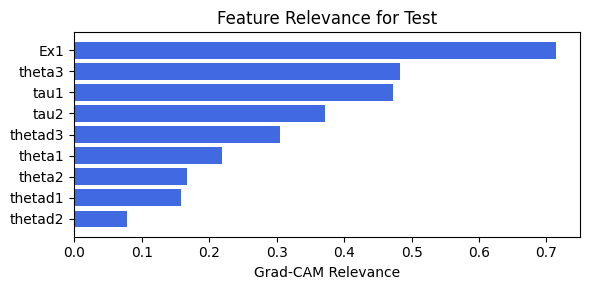

In [42]:
train_and_plot_relevance(Model3_0, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=30, n_kan_len=1)

# Option 1: Concat KAN with (CNN with dense layer to reduce output_size)

## 1.0 width=[8, 2, 1], grid=4, lamb=1e-05

### 1.0.1 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.08e+00 | eval_loss: 3.11e+00 | reg: 5.23e+01 |: 100%|█| 40/40 [01:12<00:00,  1.80s/i


saving model version 0.1
Best epoch 30
3.2520198822021484
M_KAN Relevance: 0.9861146807670593
CNN Relevance: 0.013885286636650562
[('theta3', 0.7151615), ('theta2', 0.70664096), ('thetad2', 0.028572574), ('tau2', 0.018734107), ('theta1', 0.017486027), ('thetad1', 0.014031574), ('thetad3', 0.012735205), ('tau1', 0.012264475)]


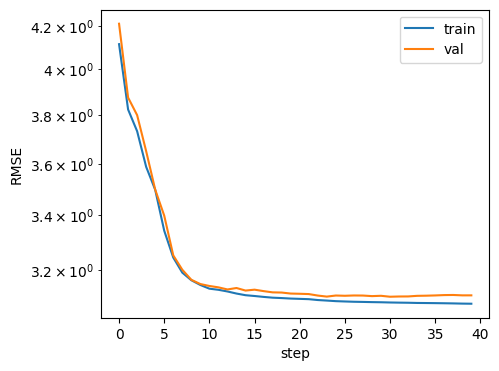

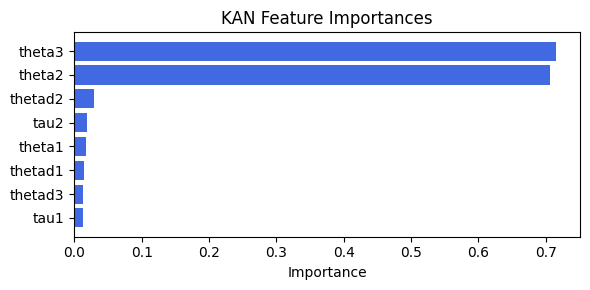

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:39<00:00,  3.16it/s]


[('thetad3', 0.5260404805388341), ('theta3', 0.3807428641760665), ('theta2', 0.26918818151352863), ('thetad1', 0.23468649781458156), ('theta1', 0.23176954954599363), ('tau2', 0.21327413699795633), ('Ex1', 0.19036456687945053), ('thetad2', 0.1590320563506431), ('tau1', 0.14268396004659997)]


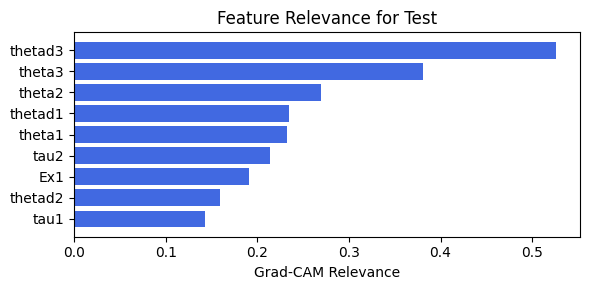

In [36]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=1, lamb=1e-05, steps=40)

### 1.0.2 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.08e+00 | eval_loss: 3.11e+00 | reg: 4.69e+01 |: 100%|█| 40/40 [01:09<00:00,  1.74s/i


saving model version 0.1
Best epoch 39
3.251225471496582
M_KAN Relevance: 0.9744514226913452
CNN Relevance: 0.02554853819310665
[('theta2', 0.7574843), ('theta3', 0.66058356), ('thetad2', 0.029332558), ('theta1', 0.019256093), ('tau2', 0.017075224), ('thetad1', 0.012803115), ('thetad3', 0.012026035), ('tau1', 0.011378829)]


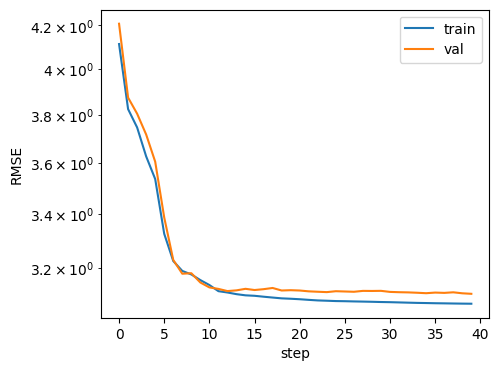

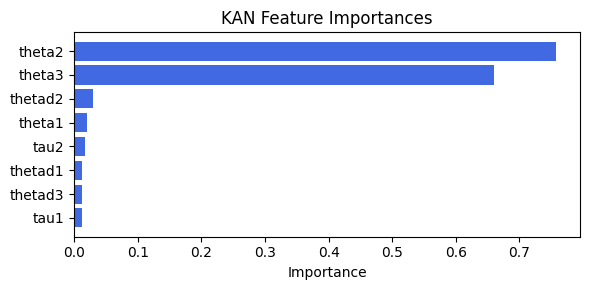

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:31<00:00,  3.21it/s]


[('theta1', 0.3861335135155438), ('theta2', 0.3786265851395012), ('thetad2', 0.27502984172237205), ('thetad1', 0.22616434796005708), ('theta3', 0.20542845376360225), ('thetad3', 0.18394174886628747), ('tau2', 0.16602804247151434), ('Ex1', 0.11806019676471091), ('tau1', 0.10799456599051797)]


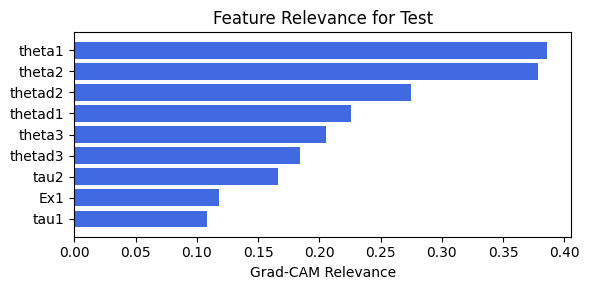

In [37]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=1, lamb=1e-05, steps=40)

### 1.0.3 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.07e+00 | eval_loss: 3.12e+00 | reg: 3.43e+01 |: 100%|█| 25/25 [00:08<00:00,  2.99it/

saving model version 0.1
Best epoch 7
3.2606749534606934
M_KAN Relevance: 0.952804446220398
CNN Relevance: 0.04719555750489235
[('theta2', 0.86709833), ('theta3', 0.46328604), ('thetad2', 0.0387665), ('thetad1', 0.031372014), ('thetad3', 0.026162148), ('tau2', 0.025403947), ('theta1', 0.02459227), ('tau1', 0.018424058)]


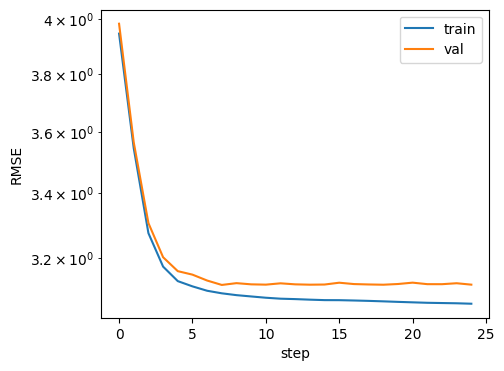

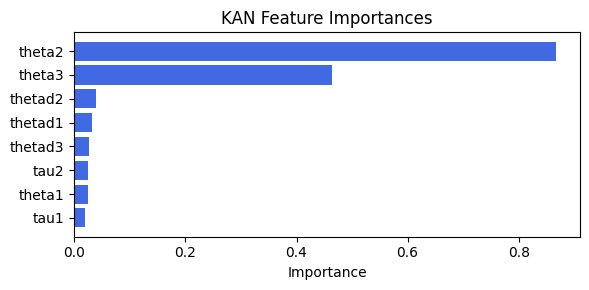

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:14<00:00, 12.18it/s]

[('thetad3', 0.624270745207879), ('theta3', 0.48609351666962847), ('theta2', 0.2947158382159926), ('Ex1', 0.29352147849217), ('thetad2', 0.21546404934670157), ('theta1', 0.20522938915622113), ('thetad1', 0.16244263742145443), ('tau1', 0.10324796356245576), ('tau2', 0.04560610853818026)]


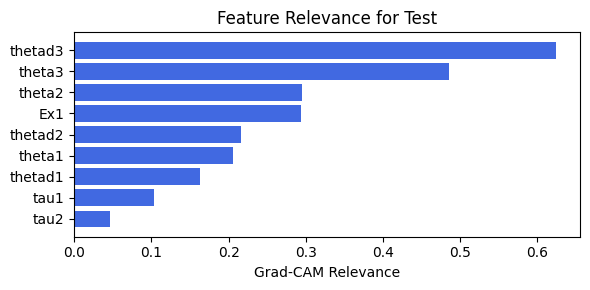

In [96]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=2, lamb=1e-05, steps=25)

### 1.0.4 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.07e+00 | eval_loss: 3.12e+00 | reg: 3.20e+01 |: 100%|█| 25/25 [00:08<00:00,  2.96it/

saving model version 0.1
Best epoch 14
3.2585747241973877
M_KAN Relevance: 0.9477455019950867
CNN Relevance: 0.05225447937846184
[('theta2', 0.8570083), ('theta3', 0.47155237), ('thetad2', 0.042738676), ('thetad1', 0.034055006), ('theta1', 0.028583389), ('tau2', 0.027223106), ('thetad3', 0.026127912), ('tau1', 0.017893393)]


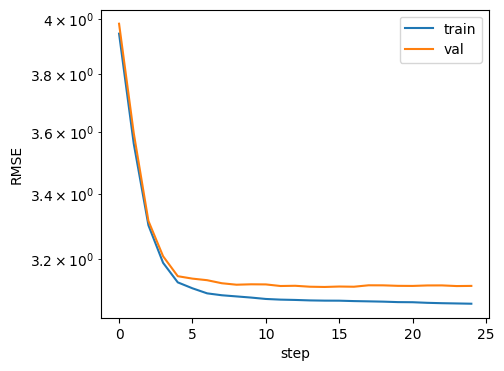

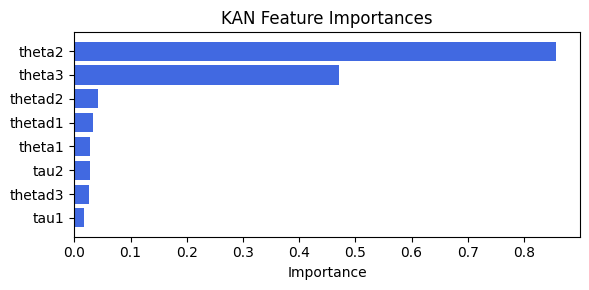

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:11<00:00, 12.46it/s]

[('thetad3', 0.618083722328016), ('theta3', 0.47243506445982986), ('theta2', 0.3507925183634794), ('thetad2', 0.3116908100915184), ('Ex1', 0.30797350588081324), ('theta1', 0.25301744650934915), ('thetad1', 0.22620374536341128), ('tau1', 0.11285440163479327), ('tau2', 0.08299083421276529)]


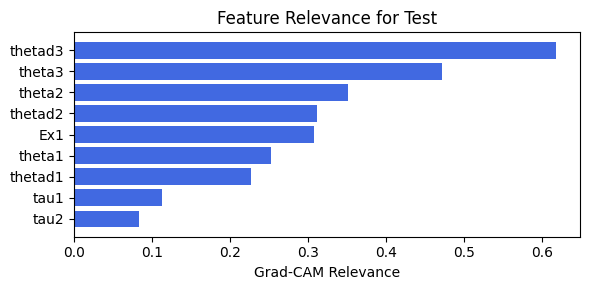

In [97]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=2, lamb=1e-05, steps=25)

### 1.0.5 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.01e+00 | eval_loss: 3.15e+00 | reg: 3.21e+01 |: 100%|█| 30/30 [00:10<00:00,  2.88it/

saving model version 0.1
Best epoch 9
3.3163585662841797
M_KAN Relevance: 0.598283052444458
CNN Relevance: 0.401716947555542
[('theta3', 0.83377147), ('theta2', 0.5439158), ('thetad3', 0.09867889), ('thetad1', 0.052522734), ('tau1', 0.047735095), ('thetad2', 0.035427127), ('theta1', 0.034691), ('tau2', 0.02961767)]


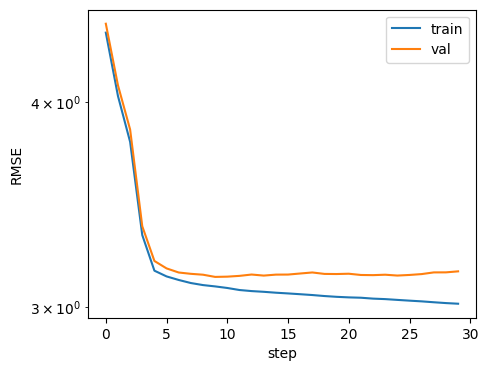

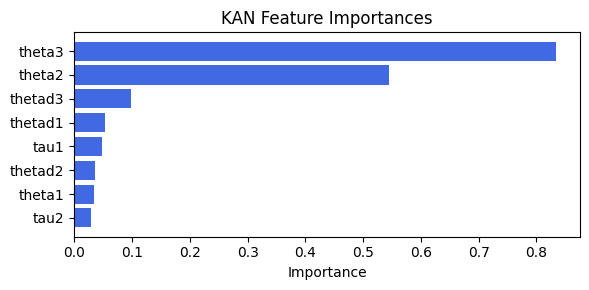

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:05<00:00, 13.06it/s]

[('Ex1', 0.3023808119662874), ('thetad2', 0.20939257271608738), ('thetad3', 0.19130801123377564), ('thetad1', 0.1391585266722849), ('theta2', 0.10607924953863529), ('tau2', 0.08939398882273113), ('theta3', 0.0881926337096113), ('theta1', 0.07771222122635635), ('tau1', 0.06687695181349623)]


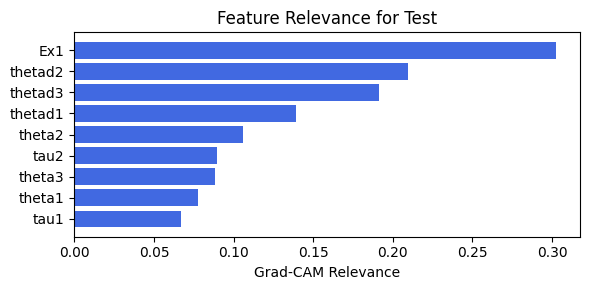

In [98]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=4, lamb=1e-05, steps=30)

### 1.0.6 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.15e+00 | reg: 3.25e+01 |: 100%|█| 30/30 [00:10<00:00,  2.84it/

saving model version 0.1
Best epoch 12
3.291759490966797
M_KAN Relevance: 0.627176821231842
CNN Relevance: 0.37282317876815796
[('theta3', 0.83685523), ('theta2', 0.5167501), ('thetad3', 0.091506645), ('thetad1', 0.08316729), ('tau1', 0.047503155), ('thetad2', 0.032596037), ('theta1', 0.023248274), ('tau2', 0.019876301)]


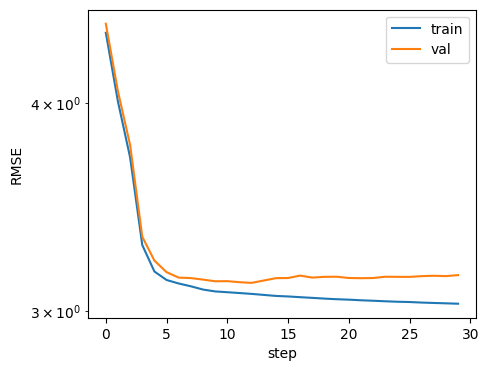

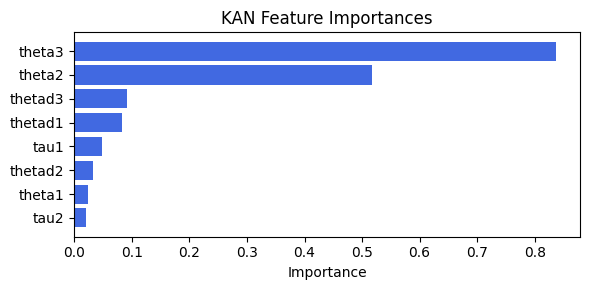

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.32it/s]

[('thetad2', 0.3473555352300036), ('thetad1', 0.2195481630264514), ('theta2', 0.1799069070012998), ('thetad3', 0.14638396615049984), ('Ex1', 0.133461429500558), ('theta1', 0.13051184435472912), ('tau2', 0.12309791047604657), ('tau1', 0.060017721751681095), ('theta3', 0.05909408706307423)]


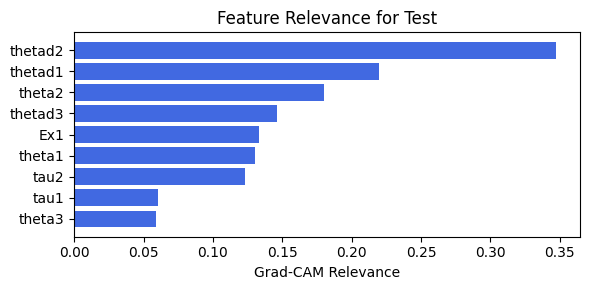

In [99]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=4, lamb=1e-05 , steps=30)

### 1.0.7 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.02e+00 | eval_loss: 3.20e+00 | reg: 2.59e+01 |: 100%|█| 35/35 [00:11<00:00,  3.07it/

saving model version 0.1
Best epoch 13
3.319627285003662
M_KAN Relevance: 0.04047026485204697
CNN Relevance: 0.95952969789505
[('theta2', 0.88275254), ('thetad2', 0.25503412), ('tau2', 0.19937938), ('thetad3', 0.17055497), ('tau1', 0.1528953), ('theta1', 0.14177904), ('thetad1', 0.12522393), ('theta3', 0.09696105)]


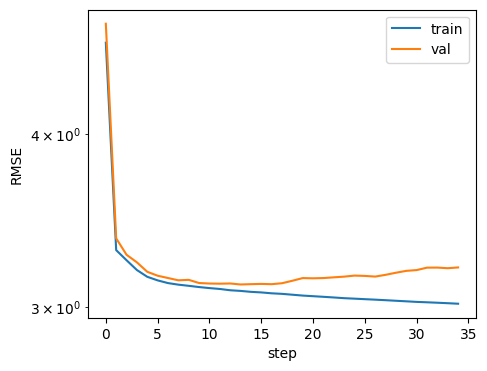

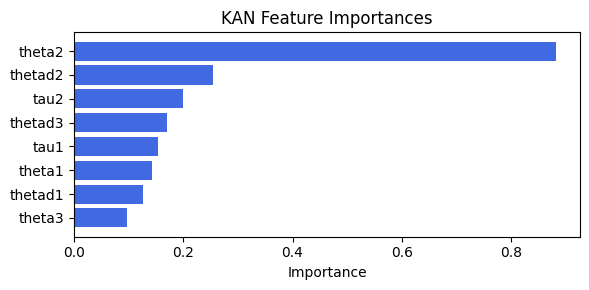

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.11it/s]

[('theta3', 0.2706039270122345), ('tau1', 0.2176302785010238), ('theta1', 0.17362799322284597), ('thetad3', 0.168512224013308), ('theta2', 0.1600188609263924), ('Ex1', 0.14845460376358757), ('thetad2', 0.14684611968679087), ('tau2', 0.1412178553051231), ('thetad1', 0.14002905121310574)]


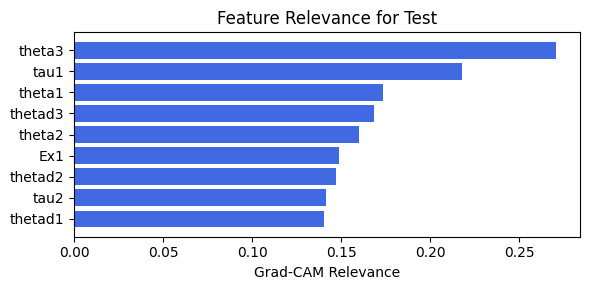

In [100]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=6, lamb=1e-05 , steps=35)

### 1.0.8 width=[8, 2, 1], grid=4, lamb=1e-05 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.02e+00 | eval_loss: 3.21e+00 | reg: 2.70e+01 |: 100%|█| 35/35 [00:11<00:00,  3.00it/

saving model version 0.1
Best epoch 15
3.2800559997558594
M_KAN Relevance: 0.04358283057808876
CNN Relevance: 0.9564171433448792
[('theta2', 0.86845493), ('thetad2', 0.31955346), ('tau2', 0.189573), ('thetad3', 0.15723316), ('theta3', 0.13980404), ('theta1', 0.13833801), ('tau1', 0.11254966), ('thetad1', 0.10490601)]


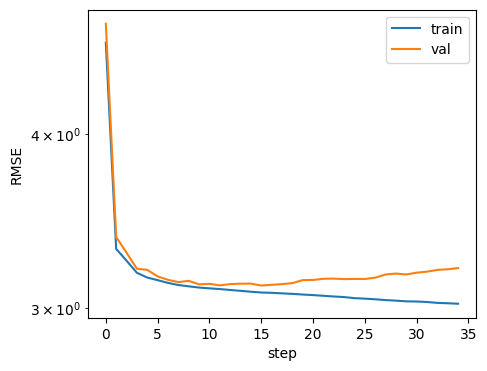

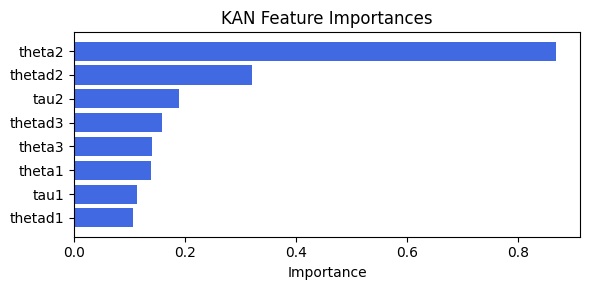

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.27it/s]


[('tau1', 0.2561438180279081), ('tau2', 0.20404005405241588), ('theta3', 0.17938680952161157), ('theta1', 0.14928790048487703), ('thetad1', 0.14582760349538518), ('thetad2', 0.1387845109785326), ('theta2', 0.12716052429169195), ('thetad3', 0.07332653516551024), ('Ex1', 0.03311105464514843)]


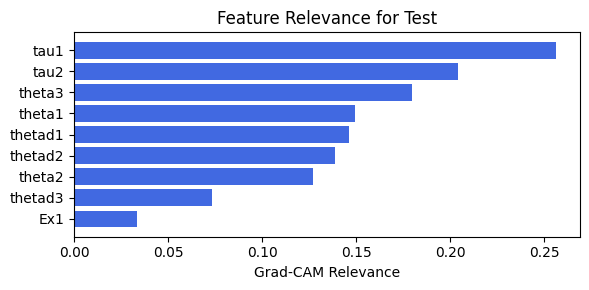

In [101]:
train_and_plot_relevance(Model3_1, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=6, lamb=1e-05 , steps=35)

## 1.1 width=[8, 3, 1], grid=5, lamb=0.0001

### 1.1.1 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.00e+00 | eval_loss: 3.18e+00 | reg: 4.04e+01 |: 100%|█| 25/25 [00:08<00:00,  3.02it/

saving model version 0.1
Best epoch 12
3.325181722640991
M_KAN Relevance: 0.8786400556564331
CNN Relevance: 0.1213599219918251
[('theta3', 0.7950253), ('theta2', 0.5870249), ('tau1', 0.05526974), ('tau2', 0.048102215), ('thetad2', 0.047846835), ('thetad1', 0.043444645), ('theta1', 0.03647688), ('thetad3', 0.031674087)]


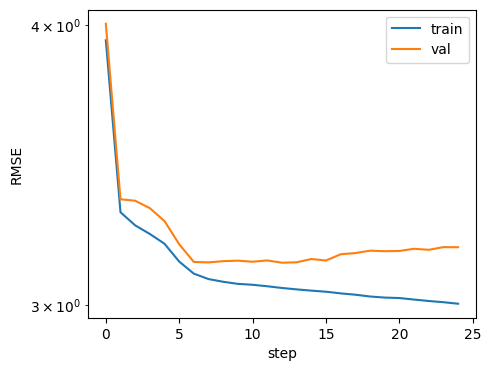

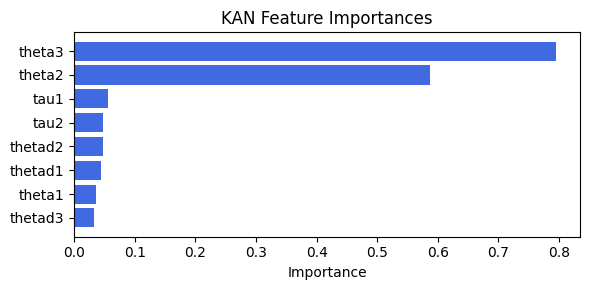

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:09<00:00, 12.65it/s]

[('theta3', 0.2564483152875866), ('thetad3', 0.2427617625050736), ('thetad2', 0.2145592405849495), ('theta2', 0.2073031009821757), ('theta1', 0.1948829609009486), ('tau1', 0.17652558173582517), ('thetad1', 0.16916271114780562), ('tau2', 0.15940612057343234), ('Ex1', 0.0887876323598583)]


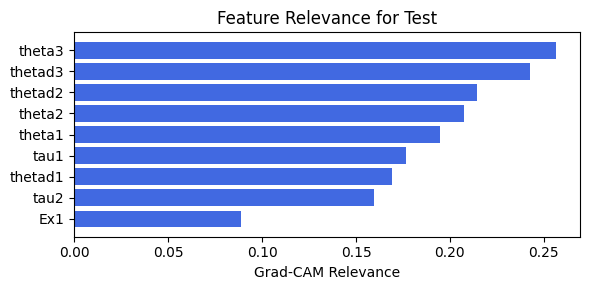

In [102]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=2, lamb=0.0001, steps=25)

### 1.1.2 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.05e+00 | eval_loss: 3.17e+00 | reg: 3.71e+01 |: 100%|█| 25/25 [00:10<00:00,  2.36it/

saving model version 0.1
Best epoch 10
3.277313709259033
M_KAN Relevance: 0.7493237853050232
CNN Relevance: 0.2506761848926544
[('theta2', 0.6209261), ('theta3', 0.59665644), ('thetad2', 0.21513818), ('tau1', 0.13870709), ('thetad3', 0.11984279), ('thetad1', 0.082758635), ('tau2', 0.07196787), ('theta1', 0.040150836)]


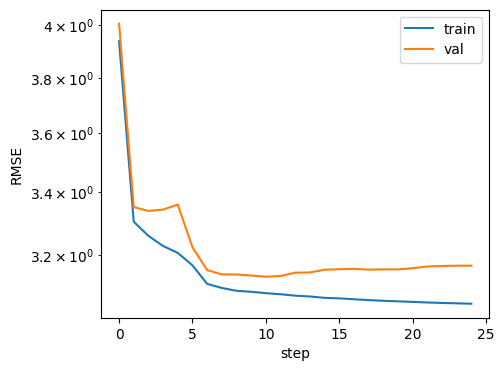

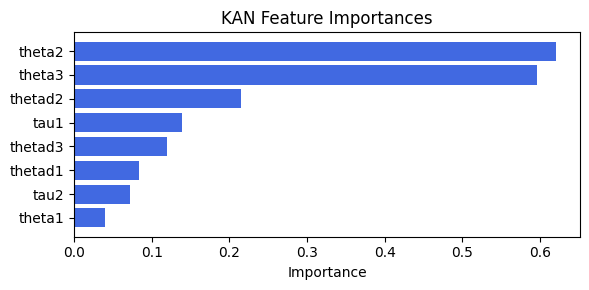

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 11.98it/s]


[('thetad3', 0.2250709842682992), ('theta3', 0.22417561934218658), ('thetad2', 0.20746246666960444), ('theta1', 0.19535147688142873), ('thetad1', 0.18534332714583018), ('theta2', 0.18397165526657483), ('tau1', 0.14307654528961947), ('tau2', 0.12499843647109306), ('Ex1', 0.11890504596717405)]


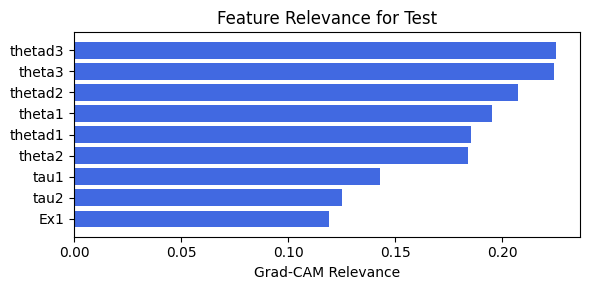

In [103]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=2, lamb=0.0001, steps=25)

### 1.1.3 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.18e+00 | reg: 3.84e+01 |: 100%|█| 25/25 [00:08<00:00,  2.79it/

saving model version 0.1
Best epoch 3
3.300920248031616
M_KAN Relevance: 0.8704645037651062
CNN Relevance: 0.1295354664325714
[('theta2', 0.74411213), ('theta3', 0.55631155), ('tau1', 0.13125621), ('thetad3', 0.12677231), ('thetad2', 0.1264689), ('theta1', 0.09456748), ('thetad1', 0.08459799), ('tau2', 0.049878232)]


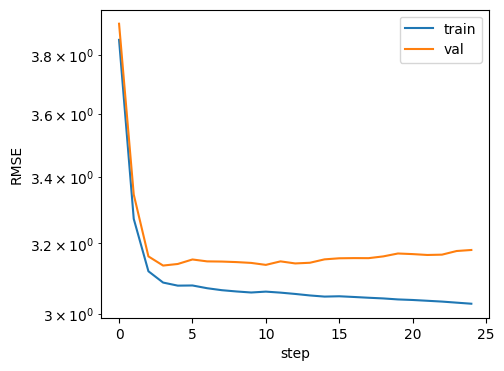

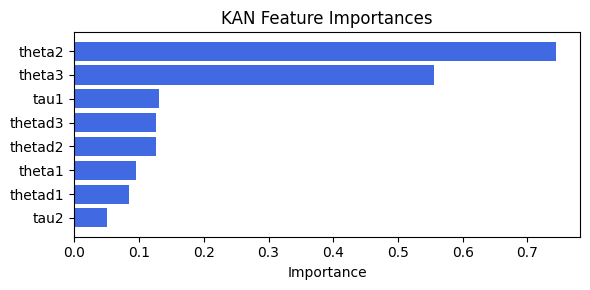

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.24it/s]

[('tau1', 0.342428505000091), ('theta1', 0.23719319797145955), ('theta3', 0.22158888984723413), ('thetad1', 0.1890679492674188), ('theta2', 0.17468438737668737), ('tau2', 0.15425840778278596), ('thetad2', 0.13969331718704966), ('thetad3', 0.07366223796167796), ('Ex1', 0.04606568250123126)]


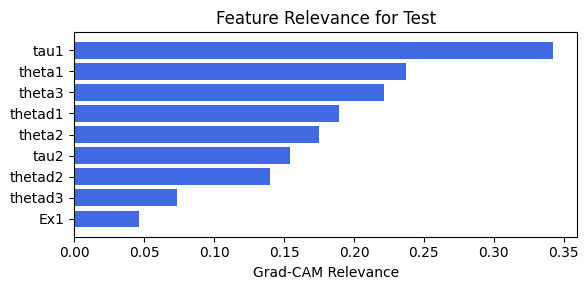

In [104]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=3, lamb=0.0001, steps=25)

### 1.1.4 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.17e+00 | reg: 3.47e+01 |: 100%|█| 25/25 [00:07<00:00,  3.26it/

saving model version 0.1
Best epoch 3
3.3144941329956055
M_KAN Relevance: 0.858772873878479
CNN Relevance: 0.141227126121521
[('theta2', 0.7347363), ('theta3', 0.53728473), ('thetad2', 0.11784521), ('thetad3', 0.08645366), ('tau1', 0.08624577), ('thetad1', 0.08105151), ('theta1', 0.06924479), ('tau2', 0.061560564)]


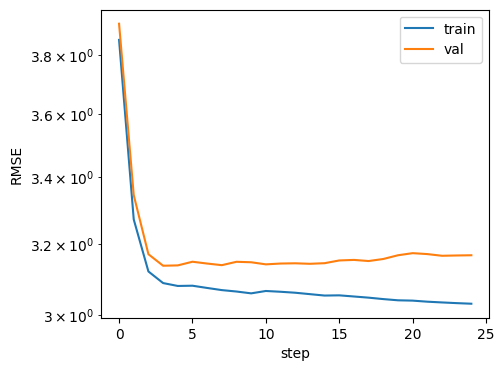

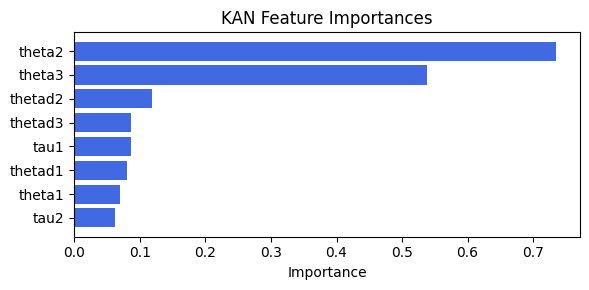

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.26it/s]

[('tau1', 0.3399399087050915), ('theta1', 0.229733793338535), ('theta3', 0.22268518949950636), ('thetad1', 0.1809890875552608), ('theta2', 0.16493546674856052), ('tau2', 0.14940363060455153), ('thetad2', 0.13215675600839902), ('thetad3', 0.07146595429985543), ('Ex1', 0.042847267429181275)]


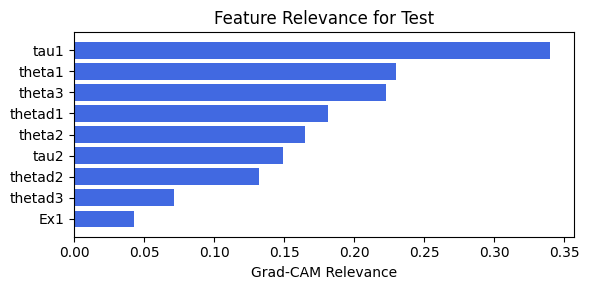

In [105]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=3, lamb=0.0001, steps=25)

### 1.1.5 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.04e+00 | eval_loss: 3.14e+00 | reg: 2.89e+01 |: 100%|█| 25/25 [00:08<00:00,  3.01it/

saving model version 0.1
Best epoch 13
3.291093349456787
M_KAN Relevance: 0.09201251715421677
CNN Relevance: 0.9079874157905579
[('theta2', 0.7950101), ('theta3', 0.50855625), ('thetad3', 0.1465235), ('thetad2', 0.13945273), ('theta1', 0.11997604), ('thetad1', 0.082976125), ('tau1', 0.07263391), ('tau2', 0.07232327)]


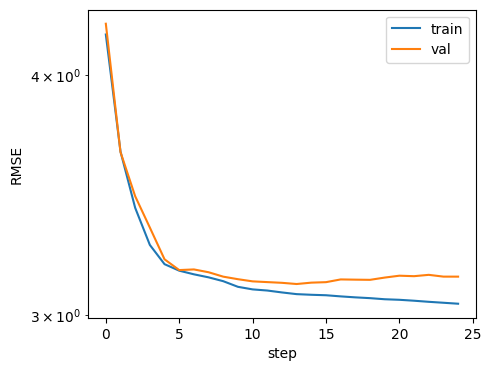

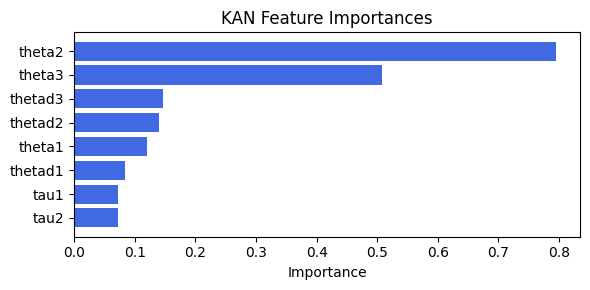

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:17<00:00, 11.88it/s]

[('tau1', 0.4449038730446458), ('theta1', 0.376200659755564), ('tau2', 0.36368080429478555), ('thetad1', 0.3557484796879938), ('theta3', 0.29508939645925203), ('theta2', 0.292478519792514), ('thetad2', 0.24274590930126788), ('thetad3', 0.10170115265468115), ('Ex1', 0.09874271401667983)]


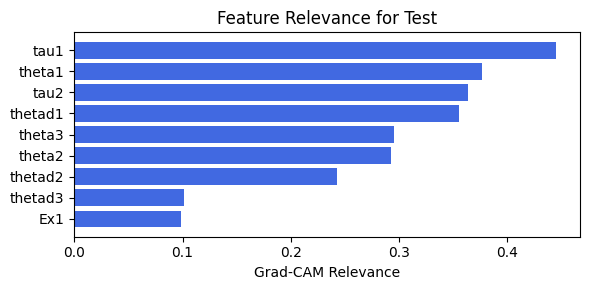

In [106]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=6, lamb=0.0001, steps=25)

### 1.1.6 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.13e+00 | reg: 3.33e+01 |: 100%|█| 25/25 [00:08<00:00,  3.02it/

saving model version 0.1
Best epoch 15
3.299581527709961
M_KAN Relevance: 0.13435527682304382
CNN Relevance: 0.8656446933746338
[('theta2', 0.7464491), ('theta3', 0.5822644), ('thetad3', 0.14710733), ('thetad2', 0.14092754), ('theta1', 0.12648527), ('tau2', 0.11293008), ('tau1', 0.09470322), ('thetad1', 0.07223968)]


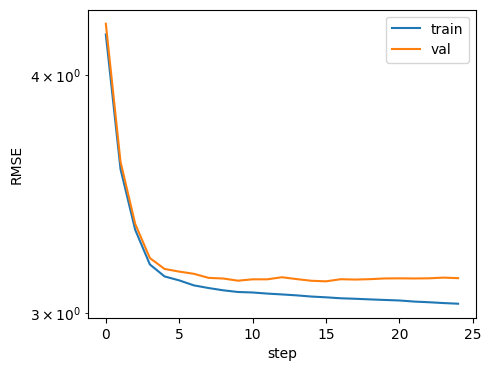

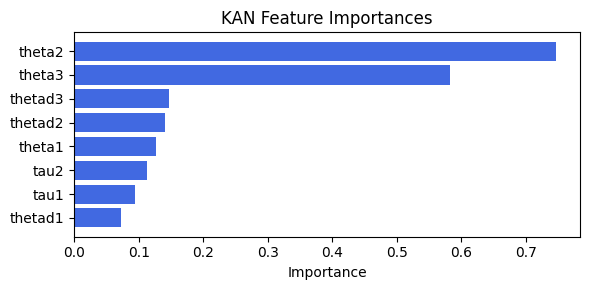

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.06it/s]

[('tau1', 0.4068157843144194), ('thetad1', 0.3715226216354195), ('theta1', 0.37134415834149453), ('tau2', 0.3608579653731081), ('theta2', 0.2866673786672662), ('thetad2', 0.279096444281518), ('theta3', 0.22170862174971262), ('Ex1', 0.12174398533356688), ('thetad3', 0.07944129762809525)]


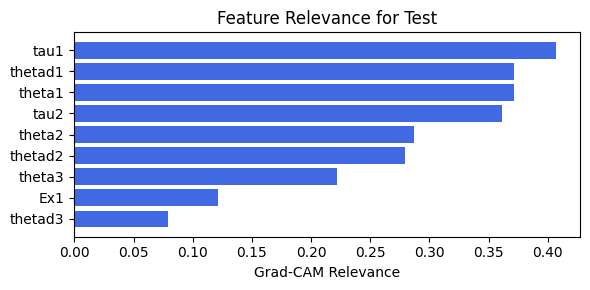

In [107]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=6, lamb=0.0001, steps=25)

### 1.1.7 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=9

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.12e+00 | reg: 4.24e+01 |: 100%|█| 25/25 [00:09<00:00,  2.56it/

saving model version 0.1
Best epoch 10
3.2775228023529053
M_KAN Relevance: 0.24537703394889832
CNN Relevance: 0.7546229958534241
[('theta2', 0.6884458), ('theta3', 0.52790046), ('thetad1', 0.21625453), ('thetad2', 0.2046272), ('tau1', 0.17229919), ('thetad3', 0.12042174), ('tau2', 0.091194), ('theta1', 0.07172871)]


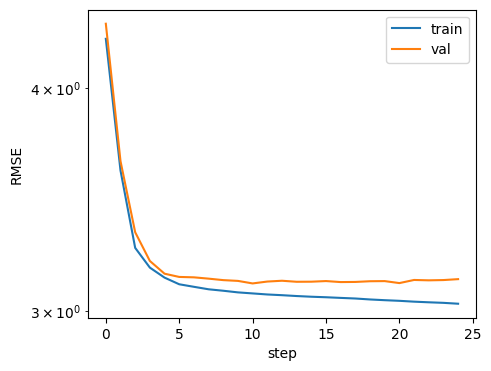

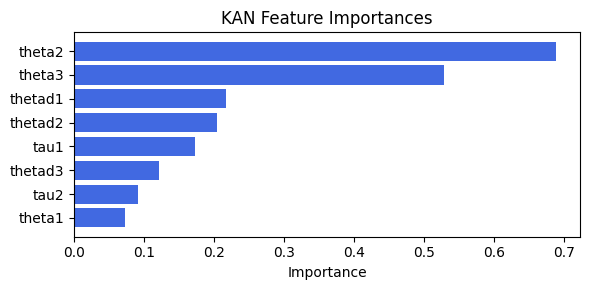

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 12.03it/s]

[('tau2', 0.45583137896797227), ('thetad1', 0.2342994742315548), ('tau1', 0.2174587680983977), ('thetad2', 0.20352896015091324), ('theta1', 0.12787690831620976), ('theta2', 0.11700840459629674), ('theta3', 0.0474223934066639), ('Ex1', 0.03410287409127168), ('thetad3', 0.00974615765459712)]


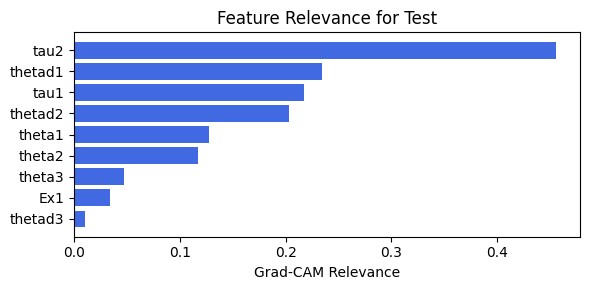

In [108]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=9, lamb=0.0001, steps=25)

### 1.1.8 width=[8, 3, 1], grid=5, lamb=0.0001 | cnn_bottleneck_dim=9

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.03e+00 | eval_loss: 3.13e+00 | reg: 4.52e+01 |: 100%|█| 25/25 [00:07<00:00,  3.24it/

saving model version 0.1
Best epoch 10
3.281013011932373
M_KAN Relevance: 0.2726030945777893
CNN Relevance: 0.7273969054222107
[('theta2', 0.67991436), ('theta3', 0.50497425), ('thetad1', 0.23855776), ('thetad2', 0.20821187), ('tau1', 0.15505652), ('thetad3', 0.123604596), ('theta1', 0.116949975), ('tau2', 0.105011076)]


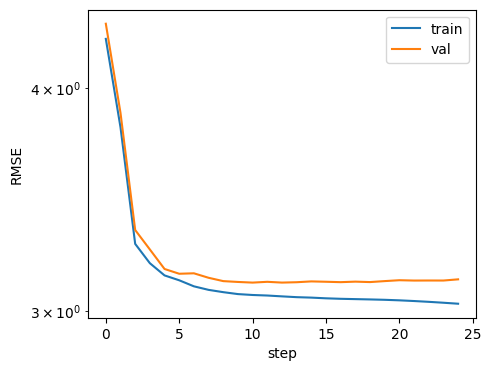

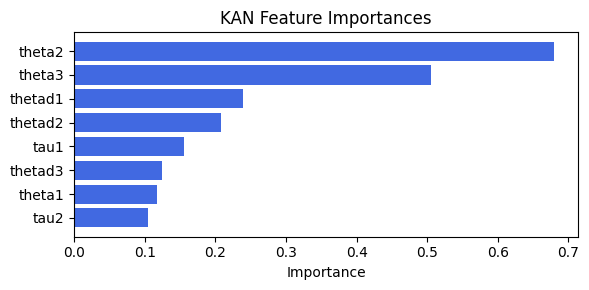

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.40it/s]

[('tau2', 0.3881116626846657), ('tau1', 0.16502370463333038), ('thetad2', 0.13843400137643305), ('thetad1', 0.10649000187613572), ('theta2', 0.06484214620578914), ('theta1', 0.05906472199722824), ('Ex1', 0.028771500487806998), ('theta3', 0.022162309345367025), ('thetad3', 0.01349124985912331)]


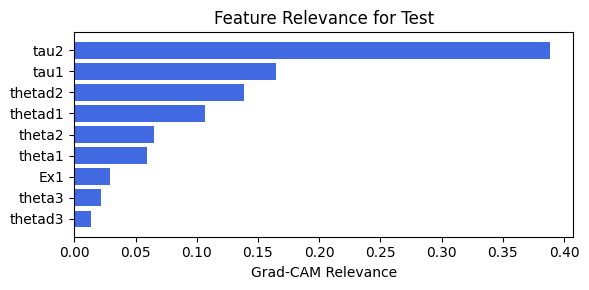

In [109]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=9, lamb=0.0001, steps=25)

## 1.2.0 width=[8, 4, 1], grid=3, lamb=0.01

### 1.2.1a width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.11e+00 | reg: 2.45e+01 |: 100%|█| 40/40 [00:12<00:00,  3.29it/

saving model version 0.1
Best epoch 39
3.287031650543213
M_KAN Relevance: 0.9418115019798279
CNN Relevance: 0.058188557624816895
[('theta2', 0.78662384), ('theta3', 0.5133866), ('theta1', 0.12896012), ('thetad3', 0.0981158), ('thetad2', 0.06881692), ('tau2', 0.04865123), ('thetad1', 0.04509199), ('tau1', 0.03302122)]


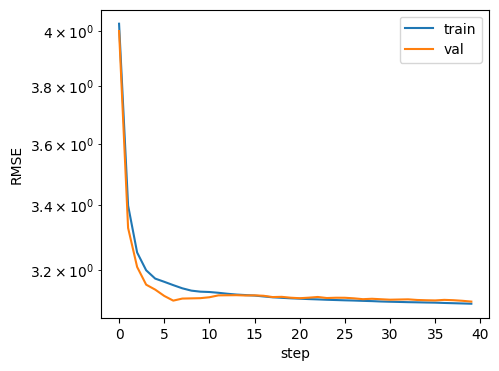

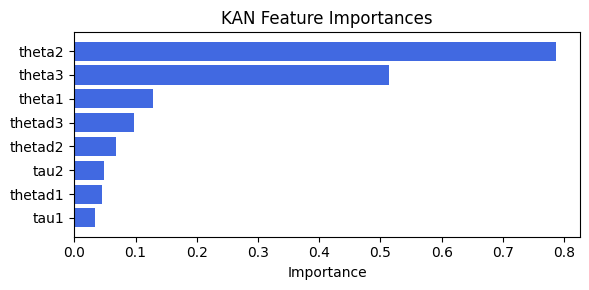

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.25it/s]

[('thetad3', 0.33103135785643667), ('thetad2', 0.18674354910502627), ('theta3', 0.16229414801879116), ('theta2', 0.10571924406129332), ('theta1', 0.08893283655540747), ('thetad1', 0.08464672729649492), ('Ex1', 0.07288873810866589), ('tau2', 0.008656051131003263), ('tau1', 0.00546949928889276)]


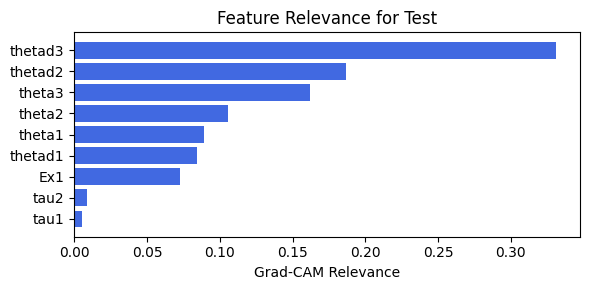

In [40]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=1, lamb=0.01, steps=40)

### 1.2.1b width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.15e+00 | reg: 2.78e+01 |: 100%|█| 40/40 [00:12<00:00,  3.13it/

saving model version 0.1
Best epoch 9
3.2725164890289307
M_KAN Relevance: 0.906872034072876
CNN Relevance: 0.09312794357538223
[('theta2', 0.786884), ('theta3', 0.4561273), ('tau1', 0.13439247), ('theta1', 0.12812997), ('thetad2', 0.108971775), ('tau2', 0.10426025), ('thetad3', 0.06653972), ('thetad1', 0.064132944)]


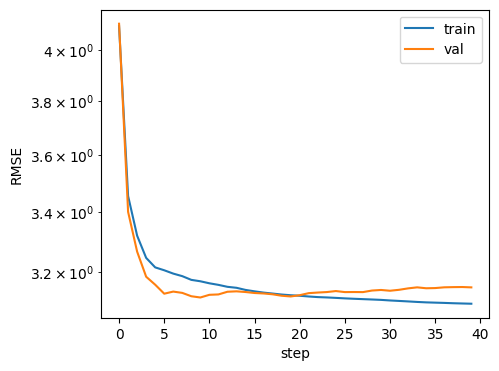

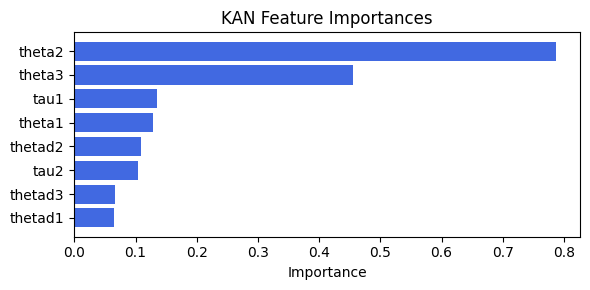

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.11it/s]


[('thetad2', 0.2697655051978283), ('theta2', 0.18283455655773345), ('thetad1', 0.16330765461248856), ('theta1', 0.13269849223659508), ('thetad3', 0.12168127308789155), ('Ex1', 0.061400348720634546), ('tau2', 0.051555461308488745), ('theta3', 0.04510671063566463), ('tau1', 0.025604535395998263)]


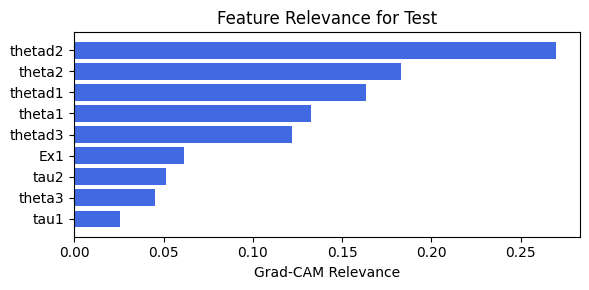

In [41]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=1, lamb=0.01, steps=40)

### 1.2.1 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.08e+00 | eval_loss: 3.14e+00 | reg: 1.86e+01 |: 100%|█| 25/25 [00:07<00:00,  3.15it/

saving model version 0.1
Best epoch 12
3.3003809452056885
M_KAN Relevance: 0.4980419874191284
CNN Relevance: 0.5019580721855164
[('theta3', 0.5792324), ('theta2', 0.52954), ('theta1', 0.23129028), ('thetad2', 0.105668776), ('thetad1', 0.09877555), ('thetad3', 0.0734261), ('tau2', 0.07277107), ('tau1', 0.04827495)]


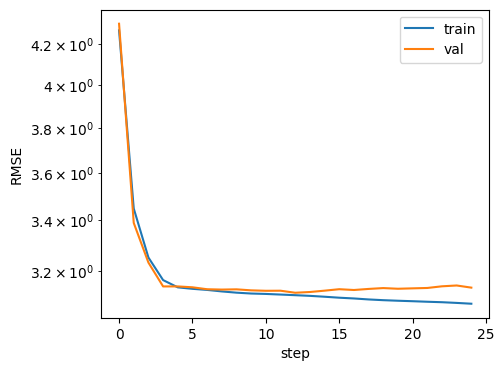

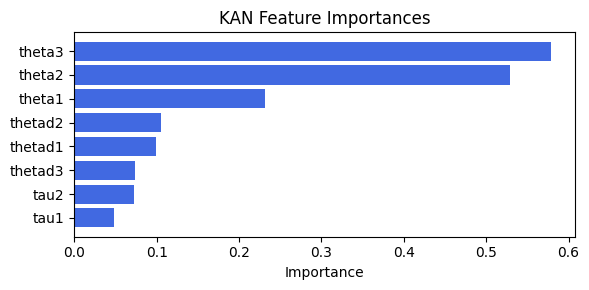

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:27<00:00, 11.13it/s]

[('Ex1', 0.256434652977069), ('tau1', 0.2388195530965842), ('thetad2', 0.13790139543016378), ('tau2', 0.11633906124903076), ('theta2', 0.11227792675198477), ('theta1', 0.11025514442345817), ('thetad1', 0.1043715075176918), ('theta3', 0.09700091769974024), ('thetad3', 0.0030382604165203855)]


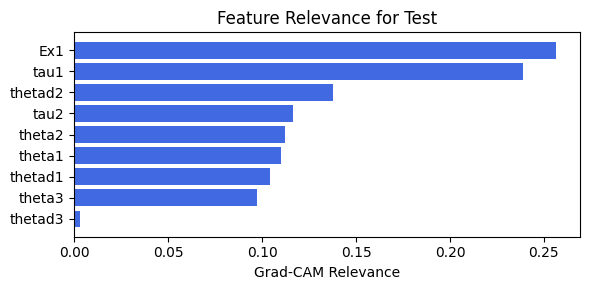

In [110]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=2, lamb=0.01, steps=25)

### 1.2.2 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.09e+00 | eval_loss: 3.14e+00 | reg: 2.13e+01 |: 100%|█| 25/25 [00:07<00:00,  3.26it/

saving model version 0.1
Best epoch 10
3.305087089538574
M_KAN Relevance: 0.8706657290458679
CNN Relevance: 0.1293342113494873
[('theta2', 0.5424996), ('theta3', 0.44078624), ('theta1', 0.23340306), ('thetad1', 0.18307479), ('thetad2', 0.17824857), ('thetad3', 0.14835617), ('tau1', 0.122104965), ('tau2', 0.10918108)]


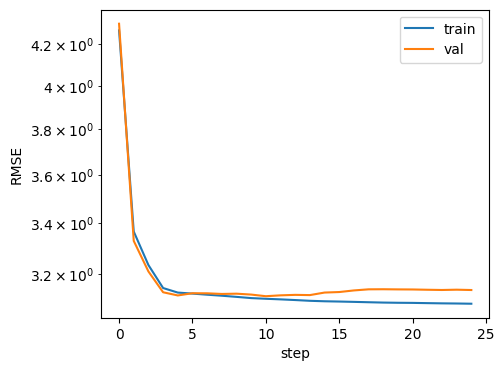

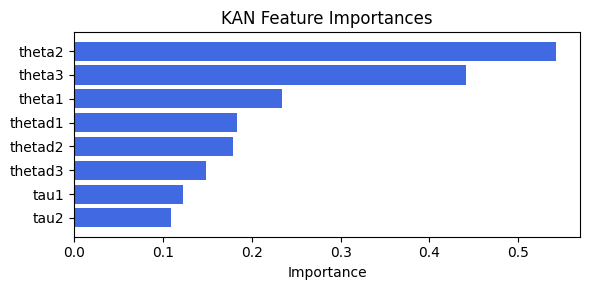

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.41it/s]

[('thetad2', 0.5428719542524216), ('theta1', 0.477371985294799), ('thetad1', 0.47121752829326724), ('theta2', 0.4430345365384967), ('tau1', 0.26241115279202154), ('tau2', 0.2506901045475335), ('theta3', 0.2189553962583345), ('thetad3', 0.1151587627509959), ('Ex1', 0.10339559715788396)]


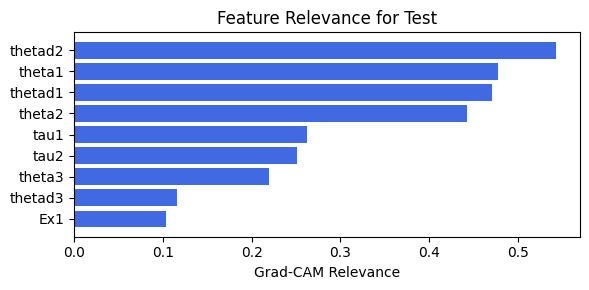

In [111]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=2, lamb=0.01, steps=25)

### 1.2.3a width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.11e+00 | reg: 1.64e+01 |: 100%|█| 40/40 [01:16<00:00,  1.90s/i


saving model version 0.1
Best epoch 31
3.2644622325897217
M_KAN Relevance: 0.014777779579162598
CNN Relevance: 0.9852222204208374
[('theta2', 0.4610737), ('theta3', 0.4524457), ('thetad2', 0.44360635), ('thetad1', 0.2585565), ('tau2', 0.15414158), ('tau1', 0.14297906), ('theta1', 0.114287905), ('thetad3', 0.08763086)]


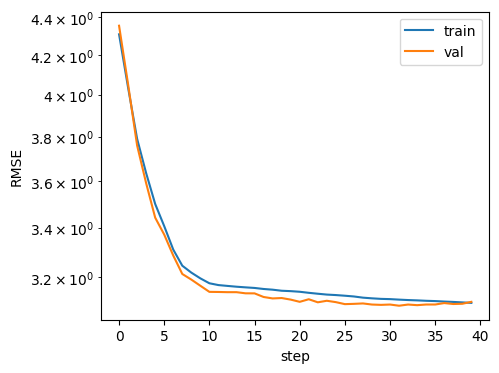

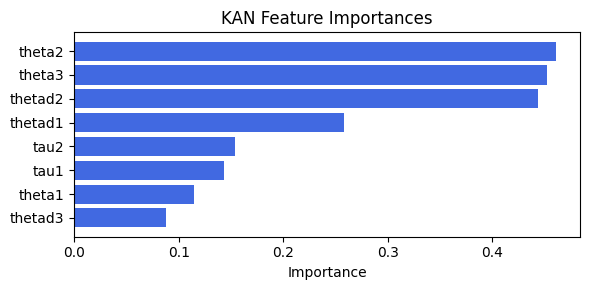

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:46<00:00,  2.80it/s]


[('theta3', 0.35357224097752316), ('tau1', 0.2759171561228757), ('thetad3', 0.24182098916817862), ('thetad2', 0.1784927522954818), ('theta1', 0.17089157895163531), ('theta2', 0.1697022730086163), ('thetad1', 0.15920680748495591), ('tau2', 0.15359722572439402), ('Ex1', 0.07363927545936669)]


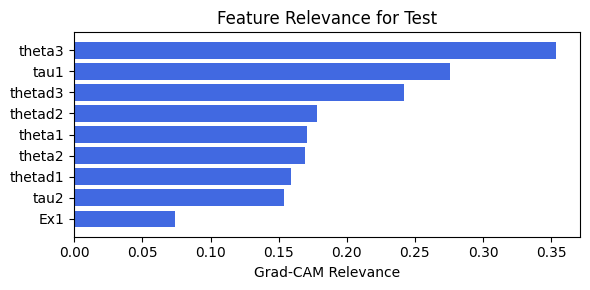

In [38]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=4, lamb=0.01, steps=40)

### 1.2.3b width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.13e+00 | reg: 1.96e+01 |: 100%|█| 40/40 [01:13<00:00,  1.84s/i


saving model version 0.1
Best epoch 28
3.270789384841919
M_KAN Relevance: 0.030183669179677963
CNN Relevance: 0.9698163866996765
[('theta3', 0.55021673), ('theta2', 0.5373287), ('thetad2', 0.28131557), ('thetad1', 0.26926088), ('tau2', 0.091117665), ('thetad3', 0.0800198), ('theta1', 0.05631645), ('tau1', 0.05392106)]


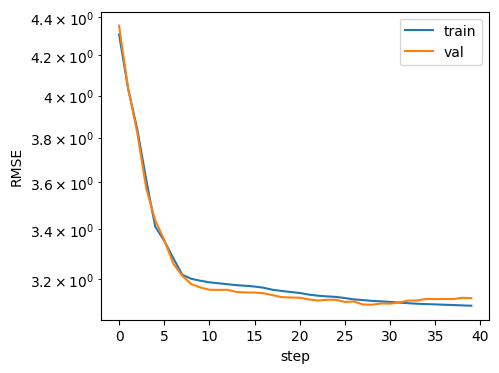

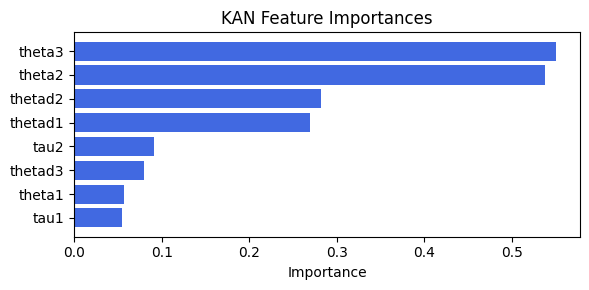

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:58<00:00,  9.20it/s]


[('thetad3', 0.4858996667661957), ('theta3', 0.47838733619393886), ('tau1', 0.3629338734774105), ('Ex1', 0.3167783064066527), ('theta2', 0.30472169383544767), ('tau2', 0.3033975865907116), ('thetad2', 0.2628257504517848), ('theta1', 0.2553110659336386), ('thetad1', 0.24776686400936135)]


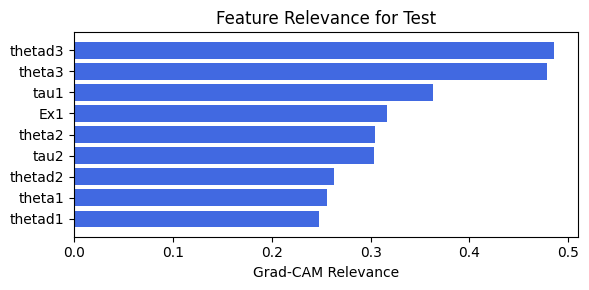

In [39]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=4, lamb=0.01, steps=40)

### 1.2.3 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.12e+00 | eval_loss: 3.10e+00 | reg: 1.46e+01 |: 100%|█| 25/25 [00:09<00:00,  2.74it/

saving model version 0.1
Best epoch 24
3.25724720954895
M_KAN Relevance: 0.0043456340208649635
CNN Relevance: 0.9956544041633606
[('theta3', 0.56624466), ('theta2', 0.31285322), ('thetad2', 0.31236267), ('tau1', 0.2547321), ('thetad3', 0.20548847), ('tau2', 0.19005617), ('theta1', 0.16283727), ('thetad1', 0.09344016)]


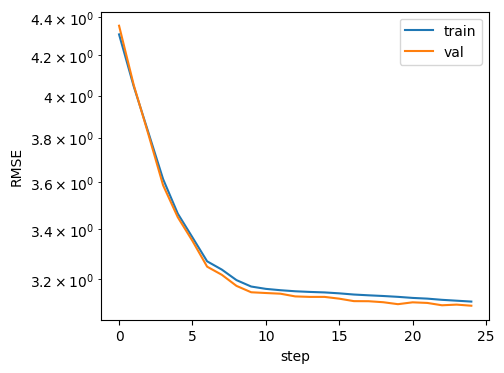

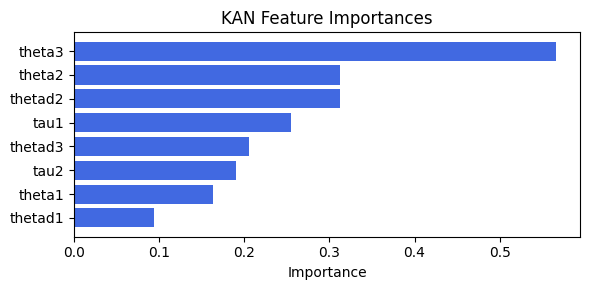

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:25<00:00, 11.27it/s]

[('theta3', 0.3436920382447148), ('tau1', 0.240026246067714), ('thetad3', 0.22137338954852634), ('theta1', 0.1907703721393564), ('theta2', 0.17534968415847704), ('thetad2', 0.1487551895649801), ('thetad1', 0.14822291856947944), ('tau2', 0.10237298229539873), ('Ex1', 0.06651437688510083)]


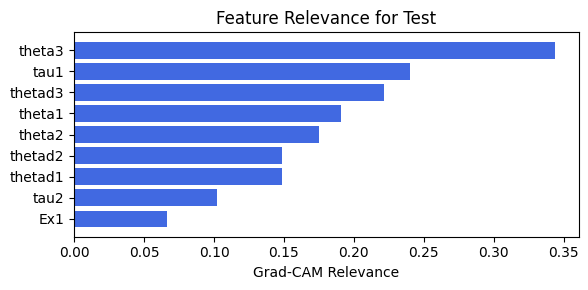

In [112]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=4, lamb=0.01, steps=25)

### 1.2.4 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=4

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 1.49e+01 |: 100%|█| 25/25 [00:08<00:00,  2.85it/

saving model version 0.1
Best epoch 22
3.264540672302246
M_KAN Relevance: 0.004704472608864307
CNN Relevance: 0.9952955842018127
[('theta2', 0.52325606), ('theta3', 0.4691745), ('thetad3', 0.28365546), ('thetad1', 0.15235783), ('thetad2', 0.12316296), ('tau2', 0.12250828), ('theta1', 0.0855404), ('tau1', 0.06572745)]


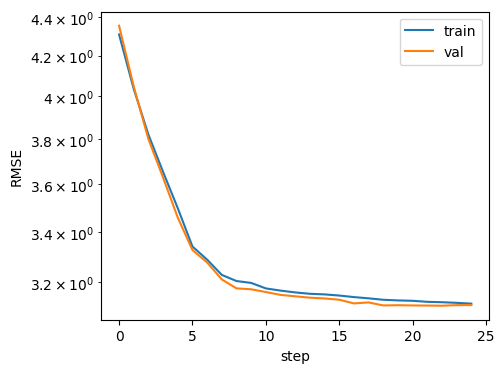

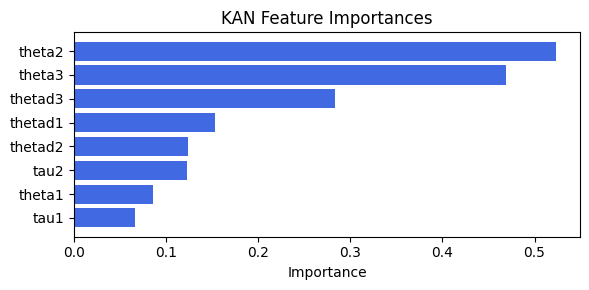

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:25<00:00, 11.25it/s]

[('theta3', 0.38478385036016033), ('thetad3', 0.31599696519916176), ('tau1', 0.290545661734059), ('theta1', 0.1979340348523275), ('theta2', 0.19707542145818752), ('thetad1', 0.16631934138084095), ('thetad2', 0.157970937251331), ('tau2', 0.14825996089056676), ('Ex1', 0.10014091166861502)]


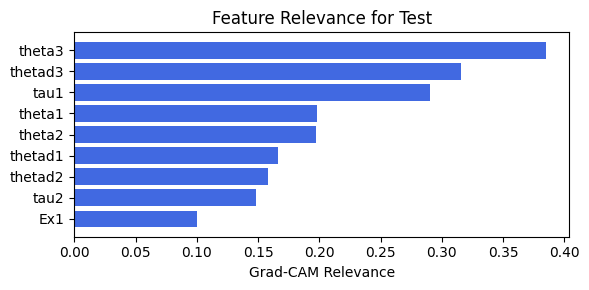

In [113]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=4, lamb=0.01, steps=25)

### 1.2.5 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.11e+00 | eval_loss: 3.11e+00 | reg: 2.83e+01 |: 100%|█| 25/25 [00:09<00:00,  2.60it/

saving model version 0.1
Best epoch 12
3.2843916416168213
M_KAN Relevance: 0.2028782218694687
CNN Relevance: 0.7971217632293701
[('theta3', 0.68662584), ('theta2', 0.63220185), ('theta1', 0.124865904), ('thetad3', 0.08899555), ('thetad2', 0.07236308), ('tau2', 0.05725202), ('thetad1', 0.05018747), ('tau1', 0.044924326)]


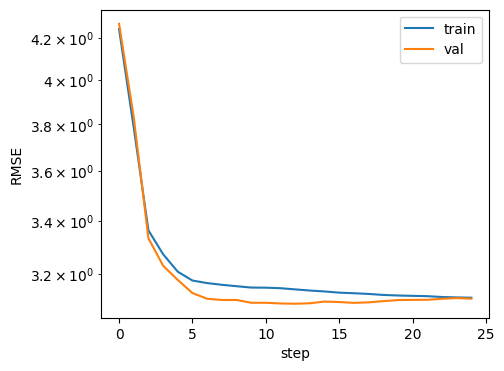

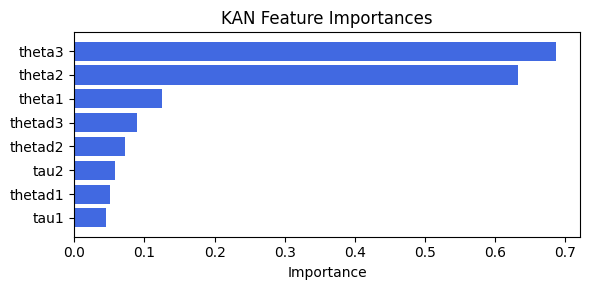

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.30it/s]


[('thetad2', 0.4947948212923189), ('thetad1', 0.33212072661474246), ('theta2', 0.2938262742577494), ('theta1', 0.28791598287433623), ('tau2', 0.07423797336614515), ('theta3', 0.06250108527084611), ('tau1', 0.038688747334831165), ('thetad3', 0.03472458259377092), ('Ex1', 0.013664458209515134)]


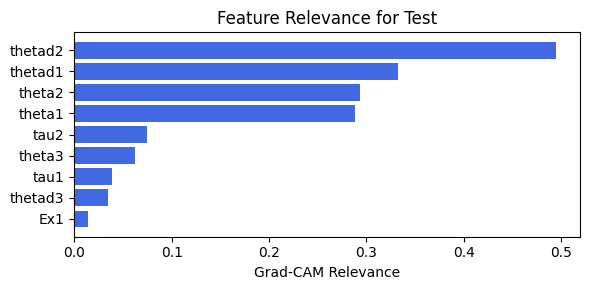

In [114]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=8, lamb=0.01, steps=25)

### 1.2.6 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.12e+00 | eval_loss: 3.10e+00 | reg: 2.92e+01 |: 100%|█| 25/25 [00:10<00:00,  2.32it/

saving model version 0.1
Best epoch 11
3.2907049655914307
M_KAN Relevance: 0.19707851111888885
CNN Relevance: 0.8029215335845947
[('theta3', 0.6791502), ('theta2', 0.65832615), ('theta1', 0.07952647), ('thetad2', 0.07856637), ('thetad3', 0.07288121), ('tau2', 0.042732794), ('thetad1', 0.030600857), ('tau1', 0.025044695)]


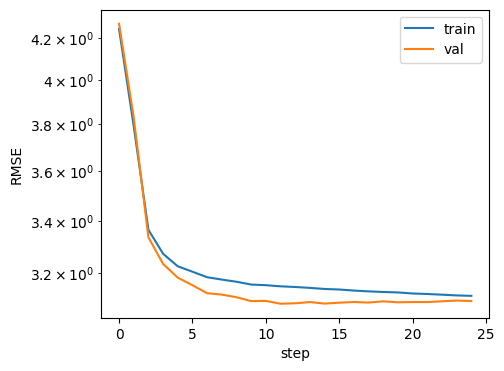

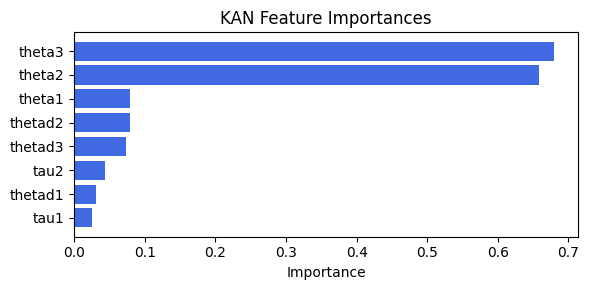

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.36it/s]


[('thetad2', 0.41907214135989673), ('thetad1', 0.25141699270809126), ('theta2', 0.22024210248468198), ('theta1', 0.20504403036834115), ('tau2', 0.05795372562641204), ('theta3', 0.049878811203319114), ('tau1', 0.025741098971244564), ('thetad3', 0.019626692380485103), ('Ex1', 0.015975366342067726)]


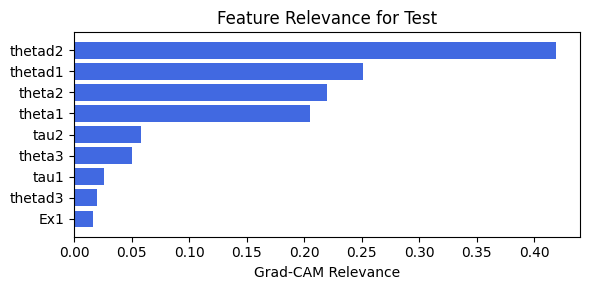

In [115]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=8, lamb=0.01, steps=25)

### 1.2.7 width=[8, 4, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=8

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.11e+00 | eval_loss: 3.11e+00 | reg: 2.53e+01 |: 100%|█| 25/25 [00:09<00:00,  2.62it/

saving model version 0.1
Best epoch 12
3.271191120147705
M_KAN Relevance: 0.21412526071071625
CNN Relevance: 0.7858747839927673
[('theta3', 0.69258296), ('theta2', 0.66029793), ('tau1', 0.109918594), ('theta1', 0.10254633), ('thetad3', 0.08524189), ('thetad2', 0.08350718), ('tau2', 0.06885974), ('thetad1', 0.053582057)]


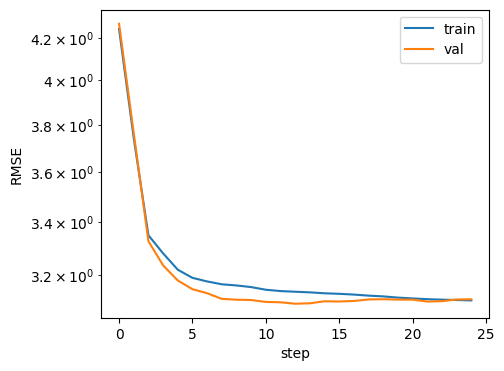

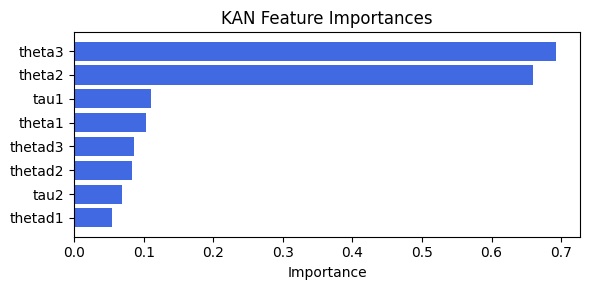

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.35it/s]

[('thetad2', 0.3513533539504094), ('thetad1', 0.29585265812032635), ('theta1', 0.2578720823927928), ('theta2', 0.22776184036737393), ('tau2', 0.08265952095595082), ('tau1', 0.05999033075634739), ('theta3', 0.04834568603993104), ('thetad3', 0.01840835008068468), ('Ex1', 0.0052772062118071434)]


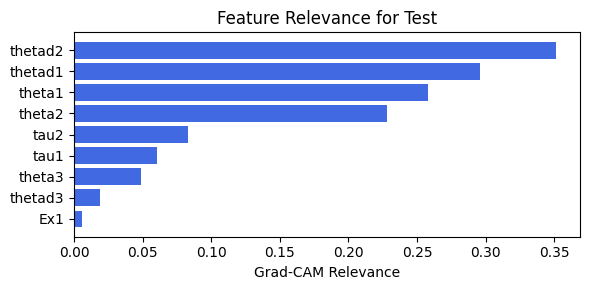

In [116]:
train_and_plot_relevance(Model3_1, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=8, lamb=0.01, steps=25)

## 1.3.0 width=[8, 3, 1], grid=5, lamb=0.01

### 1.3.0a width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

In [ ]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=1, lamb=0.01, steps=40)

### 1.3.0b width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.12e+00 | reg: 2.71e+01 |: 100%|█| 25/25 [00:07<00:00,  3.24it/

saving model version 0.1
Best epoch 9
3.250375747680664
M_KAN Relevance: 0.9283642172813416
CNN Relevance: 0.07163581252098083
[('theta2', 0.64957654), ('theta3', 0.64740807), ('thetad2', 0.07646595), ('theta1', 0.070069), ('thetad3', 0.06177069), ('thetad1', 0.03828154), ('tau1', 0.037451178), ('tau2', 0.016106663)]


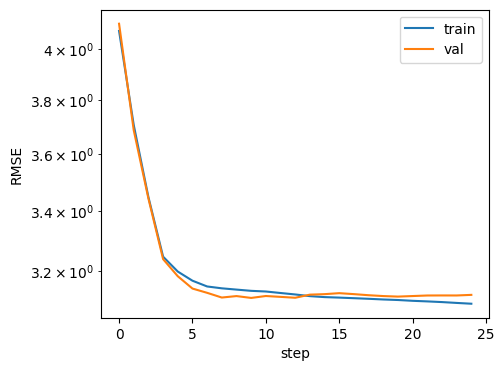

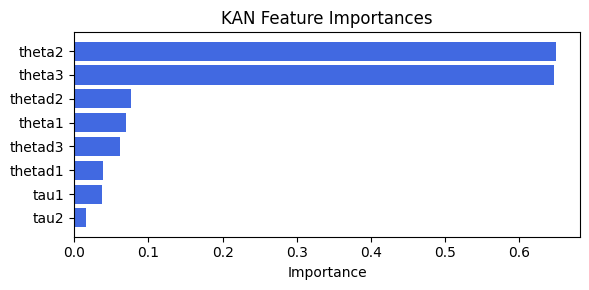

Computing Grad-CAM:  38%|███▊      | 625/1639 [01:13<01:58,  8.53it/s]


KeyboardInterrupt: 

In [35]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=1, lamb=0.01, steps=40)

### 1.3.1 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.12e+00 | eval_loss: 3.15e+00 | reg: 3.28e+01 |: 100%|█| 25/25 [00:08<00:00,  3.11it/

saving model version 0.1
Best epoch 24
3.271521806716919
M_KAN Relevance: 0.6755803227424622
CNN Relevance: 0.32441970705986023
[('theta3', 0.75045705), ('theta2', 0.604382), ('thetad2', 0.07338382), ('thetad3', 0.044974253), ('theta1', 0.041012637), ('thetad1', 0.03632628), ('tau2', 0.033819966), ('tau1', 0.03099232)]


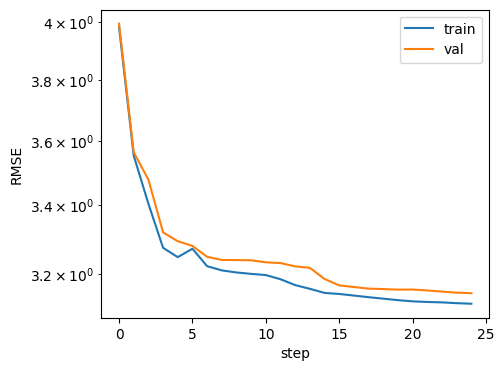

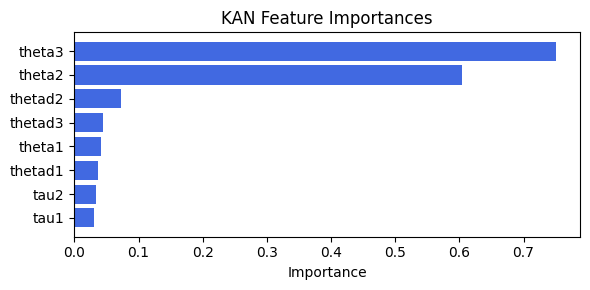

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:20<00:00, 11.65it/s]

[('thetad2', 0.3092079348002374), ('thetad1', 0.3061845774607917), ('theta1', 0.29703001017189173), ('theta2', 0.2708010772622557), ('Ex1', 0.2252763945517456), ('tau1', 0.16899206931532323), ('thetad3', 0.14868740648936987), ('theta3', 0.14304355685540196), ('tau2', 0.1312641475601176)]


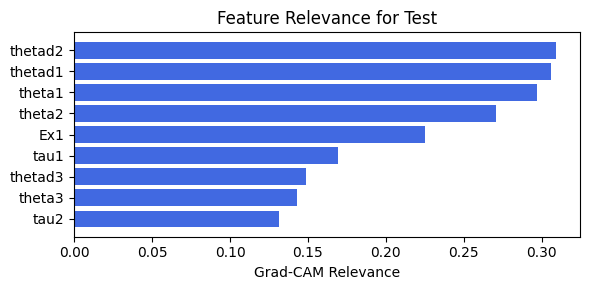

In [117]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=2, lamb=0.01, steps=25)

### 1.3.2 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.11e+00 | eval_loss: 3.13e+00 | reg: 3.51e+01 |: 100%|█| 25/25 [00:08<00:00,  2.78it/

saving model version 0.1
Best epoch 16
3.288106918334961
M_KAN Relevance: 0.579655110836029
CNN Relevance: 0.42034485936164856
[('theta3', 0.69167745), ('theta2', 0.35333127), ('tau2', 0.20568877), ('thetad2', 0.19434324), ('tau1', 0.11872278), ('thetad1', 0.10506024), ('theta1', 0.102542), ('thetad3', 0.07013097)]


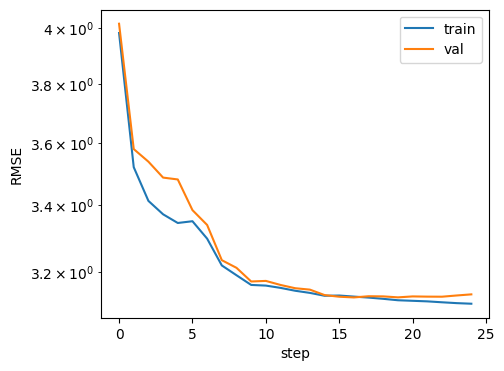

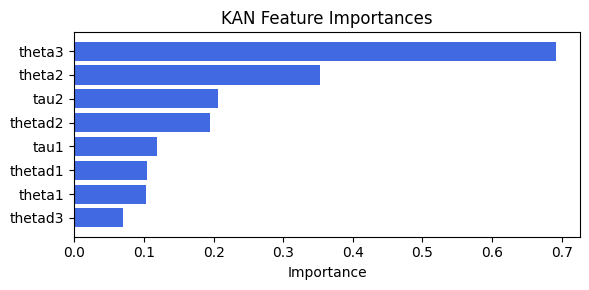

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:17<00:00, 11.96it/s]

[('theta1', 0.3323198840295155), ('theta2', 0.32253829286098645), ('theta3', 0.3201451145808499), ('thetad3', 0.30003027301886454), ('thetad1', 0.2693032358506235), ('thetad2', 0.25990006930722076), ('tau1', 0.21052943318083725), ('tau2', 0.18456534149074327), ('Ex1', 0.0897754241775106)]


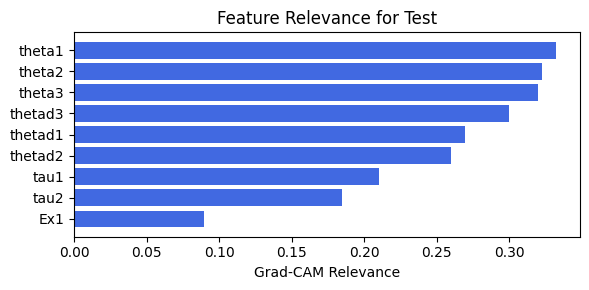

In [118]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=2, lamb=0.01, steps=25)

### 1.3.2 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.09e+00 | eval_loss: 3.13e+00 | reg: 2.96e+01 |: 100%|█| 25/25 [00:08<00:00,  3.09it/


saving model version 0.1
Best epoch 18
3.2817890644073486
M_KAN Relevance: 0.9213780760765076
CNN Relevance: 0.07862198352813721
[('theta2', 0.85527897), ('theta3', 0.38067502), ('thetad2', 0.13796628), ('thetad3', 0.08021501), ('thetad1', 0.0710299), ('theta1', 0.054717228), ('tau1', 0.041599587), ('tau2', 0.030832034)]


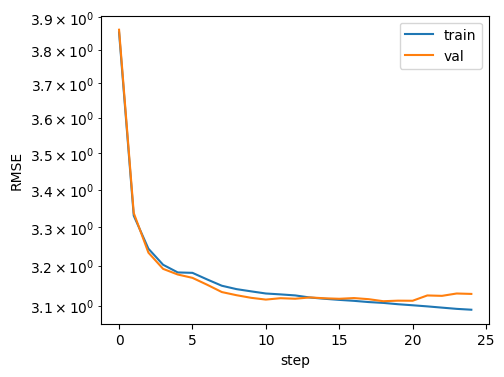

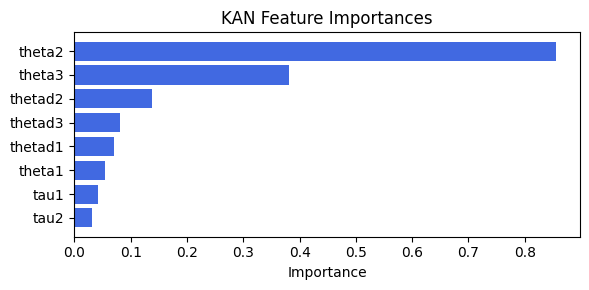

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.25it/s]


[('thetad2', 0.27527149818003716), ('thetad3', 0.222292937618683), ('theta2', 0.19103981662464065), ('thetad1', 0.15457333032320184), ('Ex1', 0.14591948782924002), ('theta1', 0.10805120432602788), ('theta3', 0.10772615003598714), ('tau2', 0.059769580667304534), ('tau1', 0.03600961244952795)]


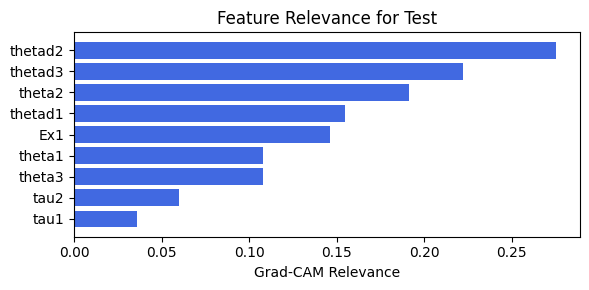

In [119]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=3, lamb=0.01, steps=25)

### 1.3.3 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=3

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.09e+00 | eval_loss: 3.13e+00 | reg: 2.89e+01 |: 100%|█| 25/25 [00:07<00:00,  3.26it/


saving model version 0.1
Best epoch 10
3.268063545227051
M_KAN Relevance: 0.914278507232666
CNN Relevance: 0.08572153002023697
[('theta2', 0.86670184), ('theta3', 0.3480007), ('thetad2', 0.102405936), ('theta1', 0.08066911), ('thetad1', 0.07436979), ('thetad3', 0.044549786), ('tau1', 0.03779064), ('tau2', 0.032402113)]


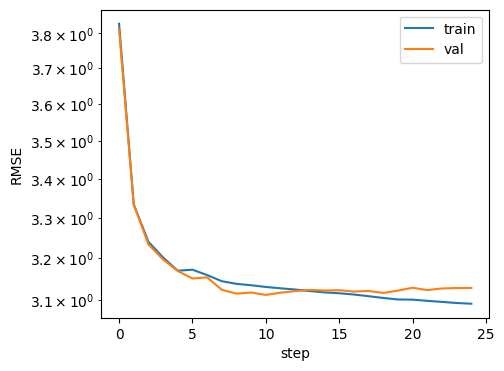

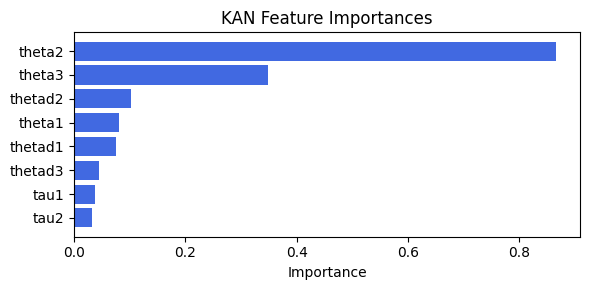

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:20<00:00, 11.70it/s]

[('thetad2', 0.24021893490723062), ('theta2', 0.13854981695634935), ('thetad1', 0.13094312976937678), ('thetad3', 0.1250118294476519), ('Ex1', 0.12341085461134806), ('theta1', 0.07179866190968494), ('tau2', 0.047448998135405526), ('theta3', 0.040398640363868525), ('tau1', 0.030634256609379698)]


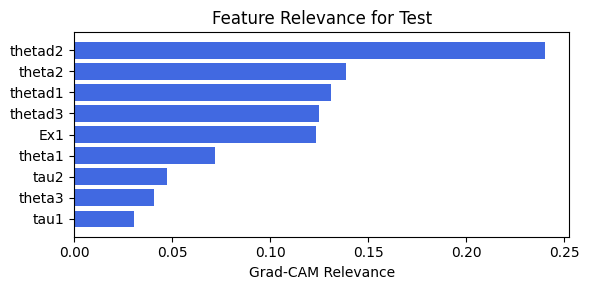

In [120]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=3, lamb=0.01, steps=25)

### 1.3.4 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.12e+00 | reg: 2.60e+01 |: 100%|█| 25/25 [00:07<00:00,  3.18it/

saving model version 0.1
Best epoch 16
3.2813000679016113
M_KAN Relevance: 0.284717321395874
CNN Relevance: 0.715282678604126
[('theta2', 0.7823416), ('theta3', 0.34897006), ('thetad2', 0.20404801), ('thetad3', 0.16399214), ('tau1', 0.1347896), ('thetad1', 0.13399246), ('theta1', 0.08244431), ('tau2', 0.058581337)]


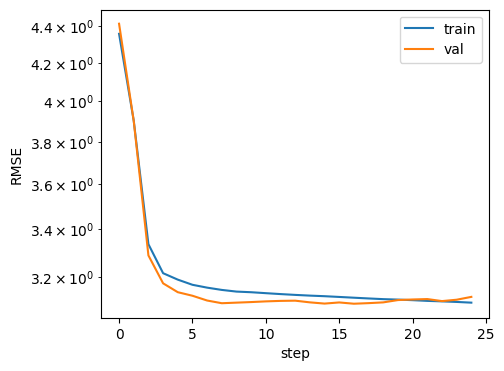

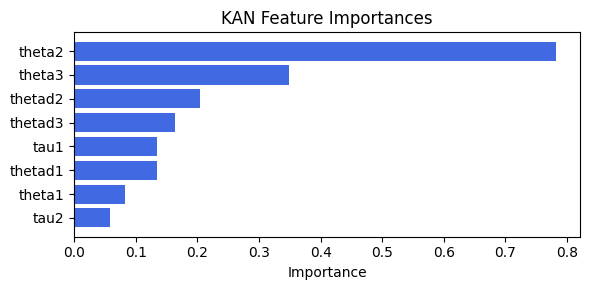

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:17<00:00, 11.88it/s]

[('tau1', 0.4407317916367742), ('tau2', 0.2666615044605498), ('thetad1', 0.24492981684460025), ('theta3', 0.23886825464826378), ('Ex1', 0.2278557307444299), ('theta1', 0.21878728943711712), ('thetad2', 0.19238307690377165), ('theta2', 0.14688489906931343), ('thetad3', 0.0923680249129167)]


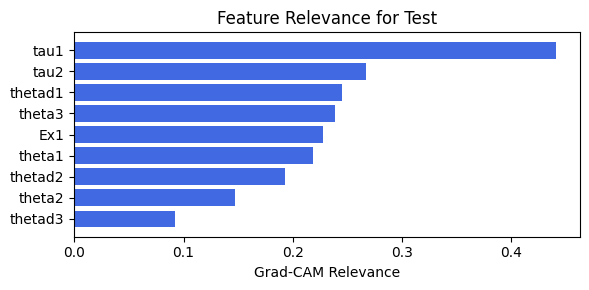

In [121]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=6, lamb=0.01, steps=25)

### 1.3.5 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=6

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.10e+00 | eval_loss: 3.11e+00 | reg: 2.91e+01 |: 100%|█| 25/25 [00:08<00:00,  2.96it/

saving model version 0.1
Best epoch 16
3.2762291431427
M_KAN Relevance: 0.21856118738651276
CNN Relevance: 0.7814388275146484
[('theta2', 0.7611472), ('theta3', 0.32637012), ('thetad3', 0.18614355), ('thetad2', 0.18014984), ('tau1', 0.14833991), ('thetad1', 0.14828518), ('tau2', 0.12282923), ('theta1', 0.10574677)]


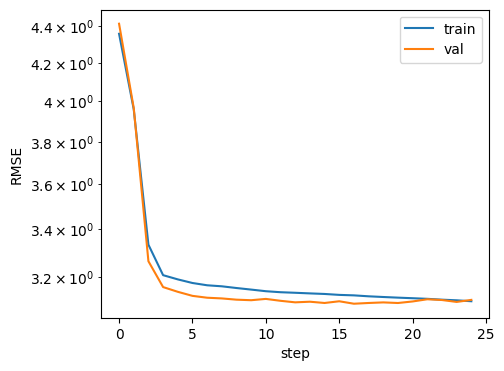

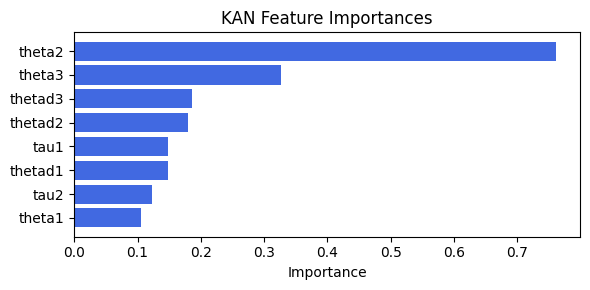

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:25<00:00, 11.23it/s]

[('Ex1', 0.253579005119155), ('tau1', 0.2127013748860847), ('theta3', 0.20997773014982832), ('theta1', 0.12716776860699217), ('thetad3', 0.11267900481518804), ('theta2', 0.08405239637265999), ('thetad1', 0.08182609378452779), ('thetad2', 0.05280346191142867), ('tau2', 0.02629950531927273)]


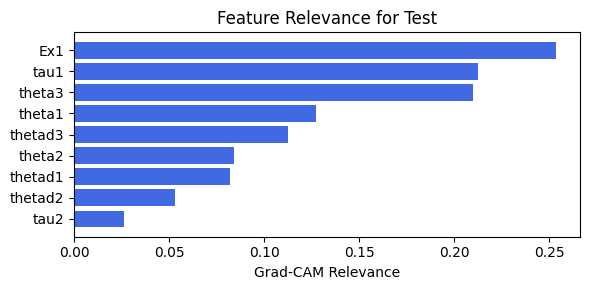

In [122]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=6, lamb=0.01, steps=25)

### 1.3.6 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=9

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.06e+00 | eval_loss: 3.14e+00 | reg: 2.57e+01 |: 100%|█| 25/25 [00:09<00:00,  2.56it/


saving model version 0.1
Best epoch 13
3.269425630569458
M_KAN Relevance: 0.23493817448616028
CNN Relevance: 0.7650618553161621
[('theta2', 0.59876215), ('theta3', 0.498373), ('thetad3', 0.3031459), ('theta1', 0.17335519), ('thetad1', 0.16619727), ('thetad2', 0.1621568), ('tau1', 0.08386116), ('tau2', 0.065812714)]


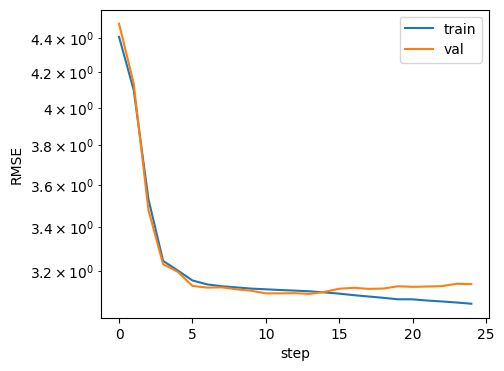

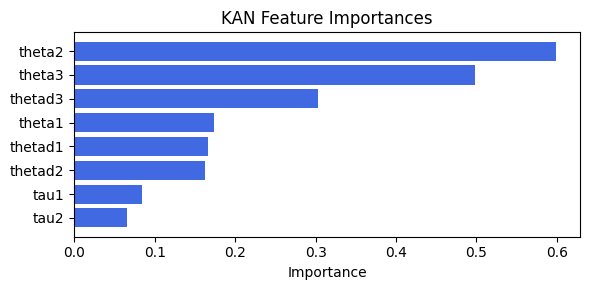

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:40<00:00, 10.23it/s]

[('Ex1', 0.2491285011257067), ('thetad2', 0.2248606126570412), ('theta3', 0.1120855222115257), ('theta1', 0.10260563943195716), ('theta2', 0.08747814506207251), ('thetad1', 0.07677263319247116), ('thetad3', 0.03919385850553151), ('tau1', 0.034588980908930936), ('tau2', 0.02195684710420075)]


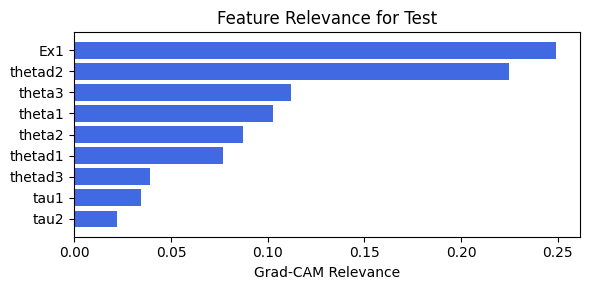

In [132]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=9, lamb=0.01, steps=25)

### 1.3.7 width=[8, 3, 1], grid=3, lamb=0.01 | cnn_bottleneck_dim=9

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_1


| train_loss: 3.05e+00 | eval_loss: 3.17e+00 | reg: 2.78e+01 |: 100%|█| 25/25 [00:09<00:00,  2.63it/

saving model version 0.1
Best epoch 13
3.2640819549560547
M_KAN Relevance: 0.2894875109195709
CNN Relevance: 0.7105125188827515
[('theta3', 0.54537344), ('theta2', 0.47584867), ('thetad3', 0.28333125), ('thetad2', 0.23558633), ('theta1', 0.178384), ('tau2', 0.12986912), ('tau1', 0.1169837), ('thetad1', 0.077639125)]


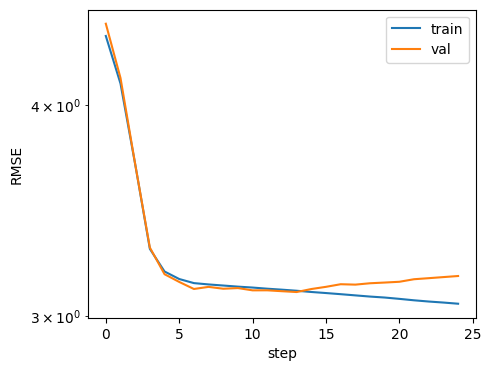

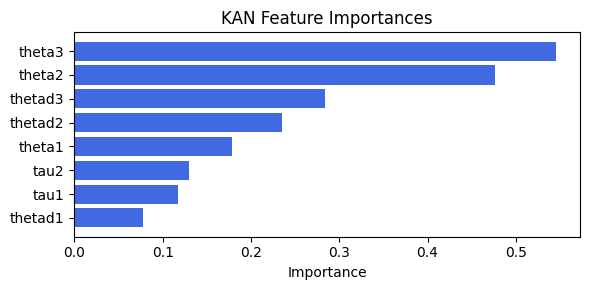

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:45<00:00,  9.92it/s]

[('theta3', 0.18421152020972245), ('thetad2', 0.1141590878923563), ('Ex1', 0.10107119292375637), ('theta2', 0.076078917943052), ('theta1', 0.07085075011124077), ('thetad1', 0.05288857502945452), ('tau1', 0.048080678642512927), ('thetad3', 0.047557607929080516), ('tau2', 0.006880350967373669)]


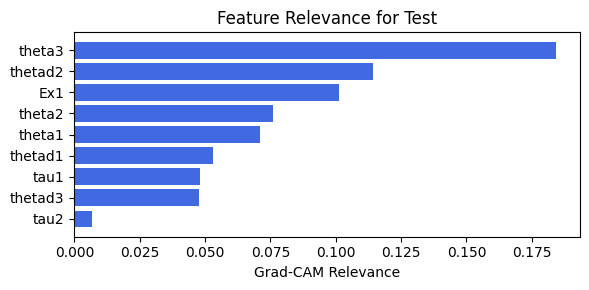

In [133]:
train_and_plot_relevance(Model3_1, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=9, lamb=0.01, steps=25)

# Option 2: Multiply CNN output by factor

## 2.0. width=[8, 2, 1], grid=4, lamb=1e-05

### 2.0.1. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=1.0

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.95e+00 | eval_loss: 3.24e+00 | reg: 3.07e+02 |: 100%|█| 25/25 [01:51<00:00,  4.46s/i


saving model version 0.1
Best epoch 9
3.3405566215515137
M_KAN Relevance: 0.030098889023065567
CNN Relevance: 0.9699011445045471
[('theta2', 0.5443787), ('thetad3', 0.42188066), ('thetad2', 0.3893163), ('thetad1', 0.34558022), ('theta3', 0.2212465), ('theta1', 0.203215), ('tau1', 0.17775846), ('tau2', 0.14548756)]


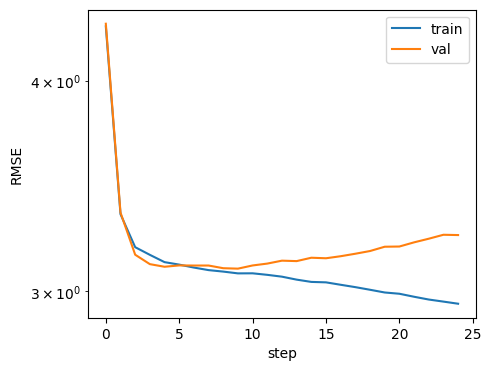

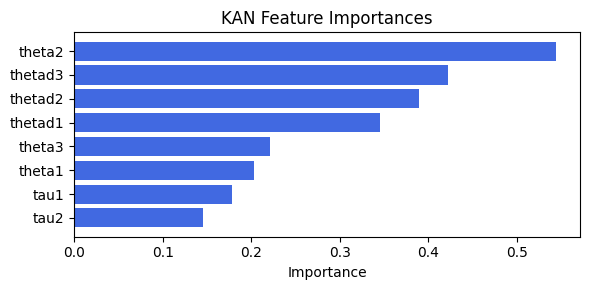

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:02<00:00,  3.02it/s] 


[('tau2', 0.41535793353877754), ('thetad1', 0.3927319421384755), ('tau1', 0.36591563224117357), ('theta1', 0.36112912843130157), ('thetad2', 0.32132080871647367), ('theta2', 0.2642514018939806), ('theta3', 0.0904827382082375), ('Ex1', 0.06339603484127336), ('thetad3', 0.04276081472426391)]


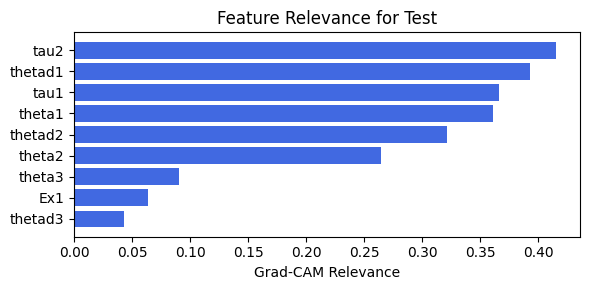

In [59]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=1.0)

### 2.0.2. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.31e+00 | reg: 4.07e+02 |: 100%|█| 25/25 [01:54<00:00,  4.58s/i


saving model version 0.1
Best epoch 3
3.3961403369903564
M_KAN Relevance: 0.00942390039563179
CNN Relevance: 0.9905760884284973
[('theta2', 0.6331309), ('tau1', 0.36249584), ('thetad3', 0.35329372), ('tau2', 0.28039068), ('thetad2', 0.27646333), ('thetad1', 0.23408169), ('theta3', 0.21214761), ('theta1', 0.09538255)]


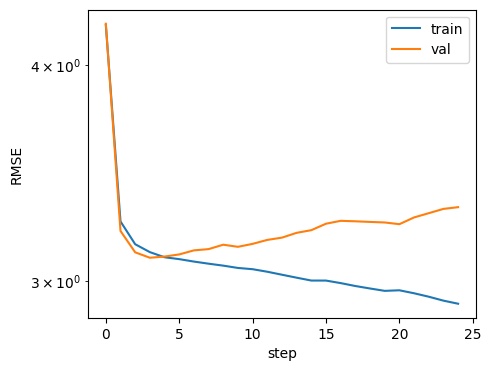

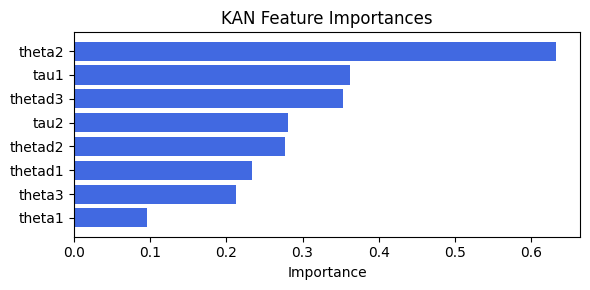

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:51<00:00,  3.09it/s] 


[('tau2', 0.4400263939848177), ('thetad1', 0.3871379400232226), ('tau1', 0.383264127321954), ('theta1', 0.33786591545416156), ('thetad2', 0.30297342730502), ('theta2', 0.23585725686008374), ('theta3', 0.09315269348553806), ('thetad3', 0.04127441485542898), ('Ex1', 0.027409404128498727)]


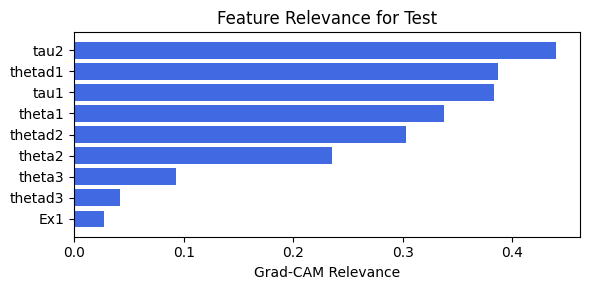

In [60]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.75)

### 2.0.3. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.92e+00 | eval_loss: 3.29e+00 | reg: 4.06e+02 |: 100%|█| 25/25 [01:52<00:00,  4.51s/i


saving model version 0.1
Best epoch 3
3.3994810581207275
M_KAN Relevance: 0.01156511902809143
CNN Relevance: 0.9884348511695862
[('theta2', 0.63218296), ('tau1', 0.37829524), ('thetad3', 0.3169163), ('thetad2', 0.28530005), ('tau2', 0.2825491), ('theta3', 0.2507763), ('thetad1', 0.1703722), ('theta1', 0.1295471)]


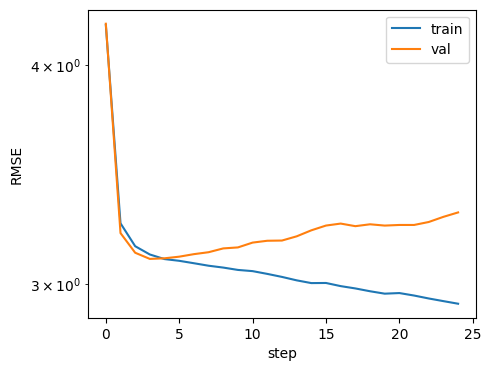

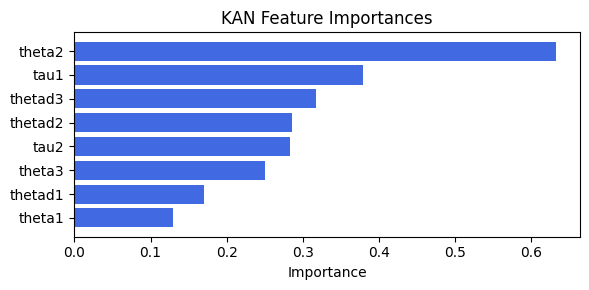

Computing Grad-CAM: 100%|██████████| 1639/1639 [07:03<00:00,  3.87it/s] 

[('tau2', 0.4335991353141539), ('thetad1', 0.3900630942839817), ('tau1', 0.37791707918044515), ('theta1', 0.34051330476860636), ('thetad2', 0.30623981653718246), ('theta2', 0.23798761889703401), ('theta3', 0.09181887019697438), ('thetad3', 0.04309406341168522), ('Ex1', 0.02739310017647494)]


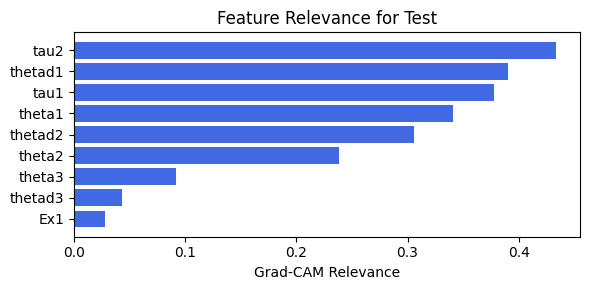

In [61]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.75)

### 2.0.4. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.26e+00 | reg: 3.82e+02 |: 100%|█| 25/25 [01:37<00:00,  3.90s/i

saving model version 0.1
Best epoch 2
3.363131046295166
M_KAN Relevance: 0.016813596710562706
CNN Relevance: 0.9831864237785339
[('theta2', 0.699482), ('thetad2', 0.44114083), ('tau2', 0.3096284), ('theta3', 0.24478641), ('thetad3', 0.16544192), ('theta1', 0.14449762), ('thetad1', 0.12922084), ('tau1', 0.0819387)]


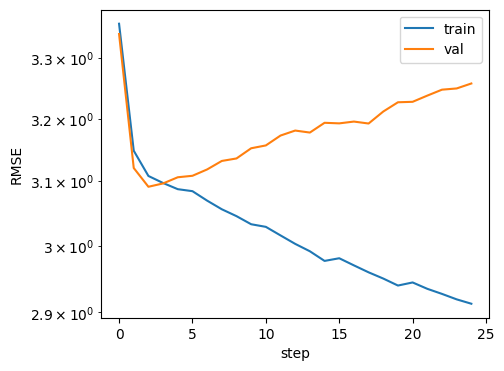

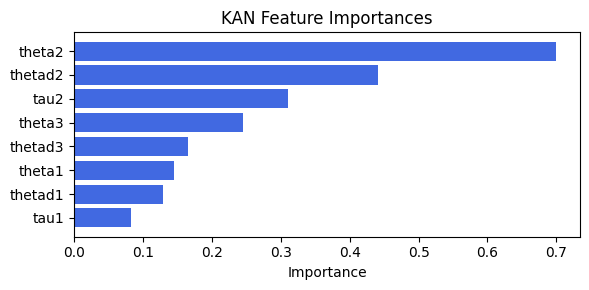

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:10<00:00, 12.55it/s]

[('thetad2', 0.45768399566079276), ('thetad1', 0.4374973859217471), ('theta1', 0.40616397016177147), ('theta2', 0.3323300477448505), ('tau2', 0.331091466924986), ('tau1', 0.30099809054826027), ('theta3', 0.15238233919196234), ('Ex1', 0.15021572703275843), ('thetad3', 0.14062044486043299)]


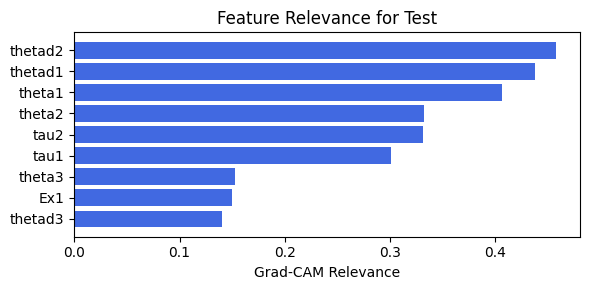

In [62]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.5)

### 2.0.5. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.91e+00 | eval_loss: 3.28e+00 | reg: 3.73e+02 |: 100%|█| 25/25 [01:38<00:00,  3.94s/i

saving model version 0.1
Best epoch 2
3.402836799621582
M_KAN Relevance: 0.02361922152340412
CNN Relevance: 0.9763807654380798
[('theta2', 0.614576), ('thetad2', 0.48811758), ('theta3', 0.3777883), ('tau2', 0.35019848), ('theta1', 0.21663944), ('tau1', 0.17825729), ('thetad3', 0.09717017), ('thetad1', 0.06924702)]


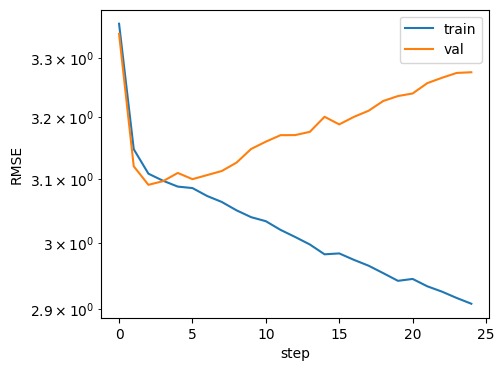

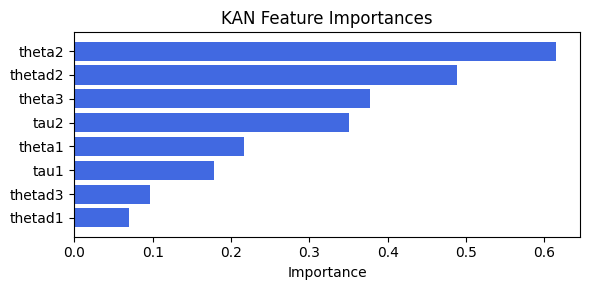

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:07<00:00, 12.87it/s]


[('thetad2', 0.4565074035207172), ('thetad1', 0.4375855225824002), ('theta1', 0.40646595201028746), ('theta2', 0.33294443840246485), ('tau2', 0.33032967255870244), ('tau1', 0.3006577764870692), ('theta3', 0.1513490262441229), ('Ex1', 0.14740686573799802), ('thetad3', 0.13876618170018348)]


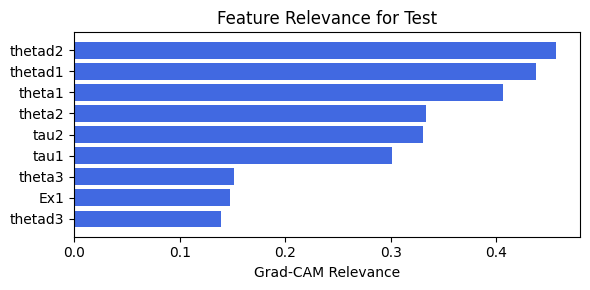

In [63]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.5)

### 2.0.6. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.93e+00 | eval_loss: 3.25e+00 | reg: 3.39e+02 |: 100%|█| 25/25 [01:40<00:00,  4.02s/i

saving model version 0.1
Best epoch 7
3.3654351234436035
M_KAN Relevance: 0.02915482223033905
CNN Relevance: 0.9708451628684998
[('theta2', 0.543046), ('thetad2', 0.4838725), ('theta3', 0.38445133), ('tau2', 0.35974693), ('tau1', 0.27105683), ('thetad1', 0.18283778), ('theta1', 0.18239945), ('thetad3', 0.17816284)]


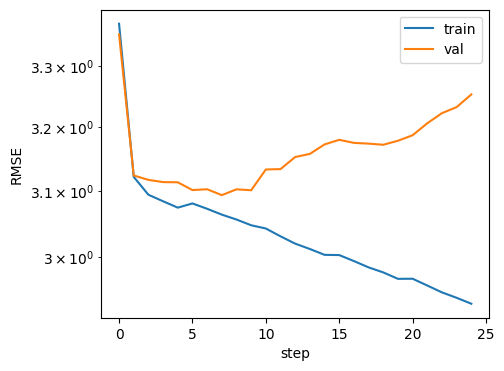

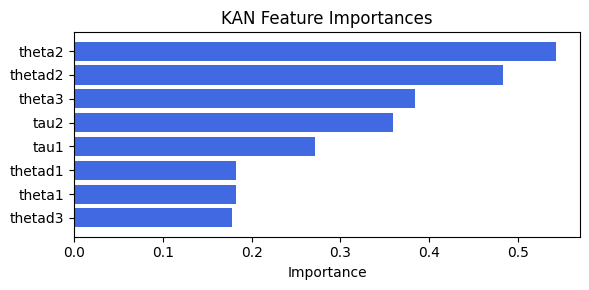

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 12.00it/s]

[('tau2', 0.38837328489885176), ('tau1', 0.3867303865528174), ('thetad1', 0.2627478498116927), ('theta1', 0.2603875531293574), ('theta2', 0.18053992353175366), ('Ex1', 0.1804890934492606), ('theta3', 0.17122630800532873), ('thetad2', 0.16270654830352116), ('thetad3', 0.1363302878912239)]


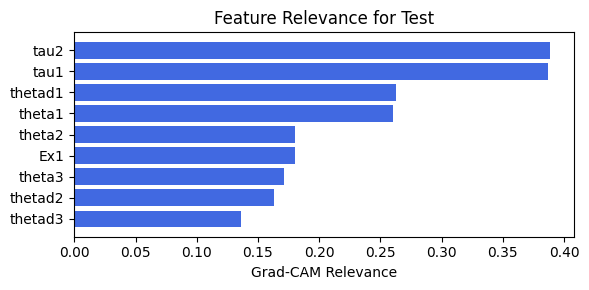

In [65]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.25)

### 2.0.7. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.96e+00 | eval_loss: 3.21e+00 | reg: 3.43e+02 |: 100%|█| 25/25 [01:38<00:00,  3.95s/i


saving model version 0.1
Best epoch 6
3.3354763984680176
M_KAN Relevance: 0.037033554166555405
CNN Relevance: 0.9629664421081543
[('theta2', 0.53056264), ('thetad2', 0.5290998), ('theta3', 0.41518056), ('tau2', 0.27416167), ('tau1', 0.21556419), ('theta1', 0.18132524), ('thetad1', 0.16318348), ('thetad3', 0.16168576)]


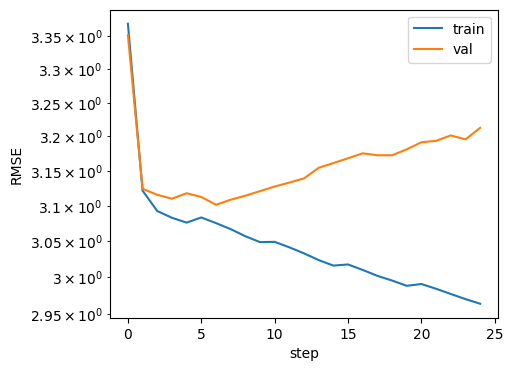

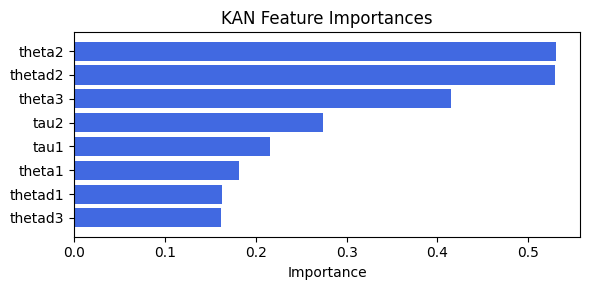

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.81it/s]

[('tau1', 0.35690674791361143), ('tau2', 0.33700772151007286), ('theta1', 0.24487843863773878), ('thetad1', 0.24169394187409035), ('theta3', 0.18790739708395546), ('theta2', 0.18118841151860365), ('Ex1', 0.1723143908049341), ('thetad2', 0.16988355536101207), ('thetad3', 0.16330206007049133)]


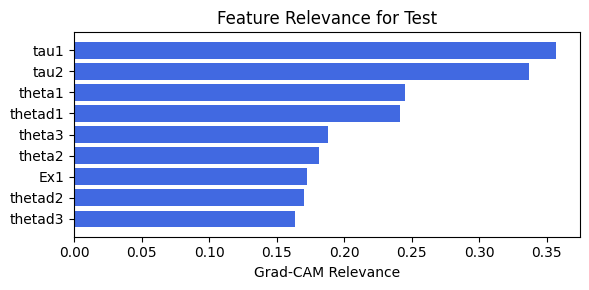

In [66]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.25)

### 2.0.8. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.89e+00 | eval_loss: 3.31e+00 | reg: 5.32e+02 |: 100%|█| 25/25 [01:36<00:00,  3.87s/i

saving model version 0.1
Best epoch 3
3.415734052658081
M_KAN Relevance: 0.031241707503795624
CNN Relevance: 0.9687583446502686
[('theta2', 0.54640585), ('thetad2', 0.3991338), ('theta3', 0.3848557), ('tau1', 0.23771484), ('thetad1', 0.21283272), ('tau2', 0.2048881), ('thetad3', 0.17550783), ('theta1', 0.13324529)]


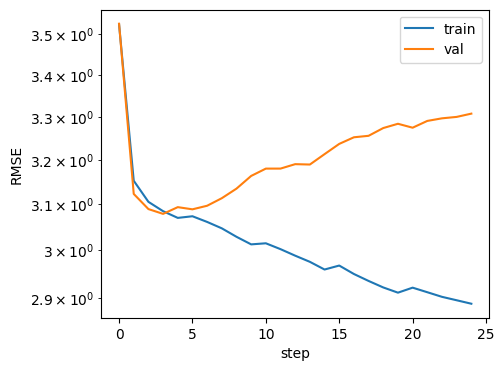

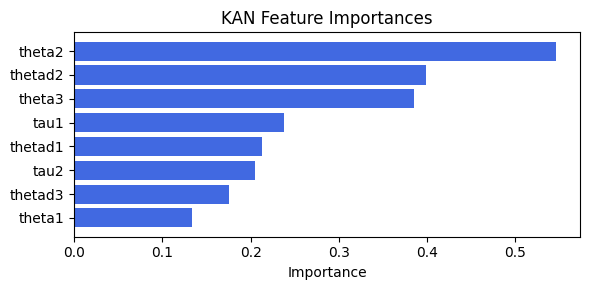

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:12<00:00, 12.33it/s]

[('tau2', 0.30634742685392174), ('tau1', 0.2955088893132304), ('thetad1', 0.2764718023231239), ('thetad3', 0.2732236392998399), ('theta1', 0.2686312927822514), ('thetad2', 0.25760840055056805), ('Ex1', 0.2395182951940752), ('theta2', 0.23928372177361404), ('theta3', 0.23723378116274793)]


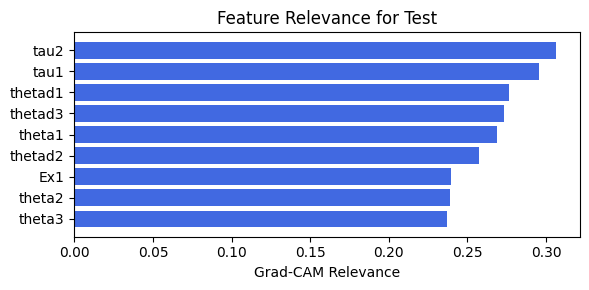

In [68]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.1)

### 2.0.9. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.89e+00 | eval_loss: 3.29e+00 | reg: 5.17e+02 |: 100%|█| 25/25 [01:36<00:00,  3.85s/i

saving model version 0.1
Best epoch 3
3.4250521659851074
M_KAN Relevance: 0.029570044949650764
CNN Relevance: 0.9704299569129944
[('theta2', 0.48365027), ('theta3', 0.4574173), ('thetad2', 0.41511497), ('thetad1', 0.26873195), ('thetad3', 0.24175568), ('tau2', 0.23533258), ('tau1', 0.20639125), ('theta1', 0.16300845)]


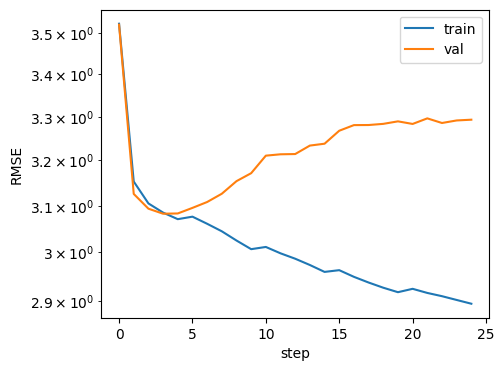

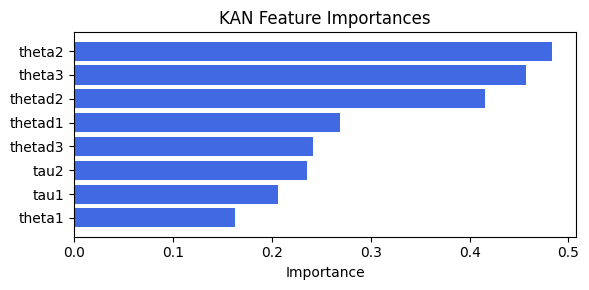

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:13<00:00, 12.30it/s]

[('theta1', 0.2838365041266507), ('tau1', 0.28165815498555863), ('thetad1', 0.2676582726510689), ('tau2', 0.2601922670324953), ('thetad3', 0.2580652824397857), ('theta2', 0.24160289272239702), ('theta3', 0.24087210273313112), ('Ex1', 0.22986441197068153), ('thetad2', 0.22550569179089028)]


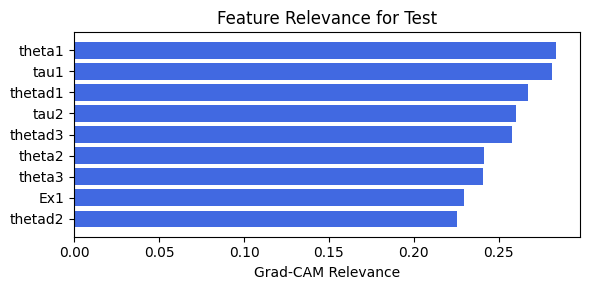

In [69]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.1)

### 2.0.9. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.88e+00 | eval_loss: 3.29e+00 | reg: 5.44e+02 |: 100%|█| 25/25 [01:39<00:00,  3.98s/i


saving model version 0.1
Best epoch 4
3.426431894302368
M_KAN Relevance: 0.022269578650593758
CNN Relevance: 0.977730393409729
[('theta3', 0.48054677), ('theta2', 0.4572124), ('thetad2', 0.39426905), ('thetad1', 0.32901722), ('thetad3', 0.228027), ('tau2', 0.20979361), ('tau1', 0.20413008), ('theta1', 0.18063053)]


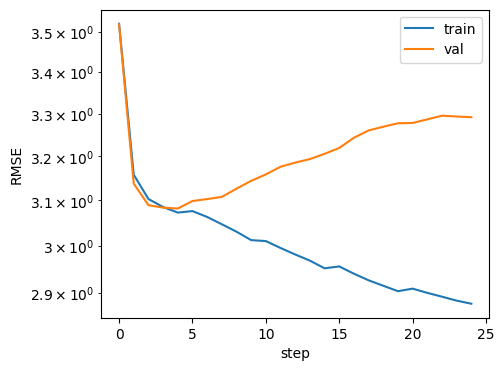

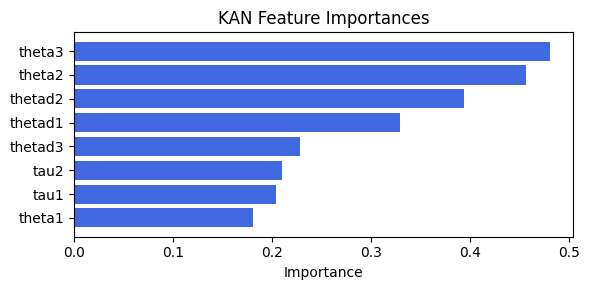

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:19<00:00, 11.73it/s]


[('thetad3', 0.32060261995909595), ('tau1', 0.31812048078014027), ('Ex1', 0.317191399616407), ('tau2', 0.3159347352789896), ('theta1', 0.29088784544000656), ('theta3', 0.2899264253026313), ('thetad1', 0.2830546510541609), ('theta2', 0.26818343073993817), ('thetad2', 0.2504083944268559)]


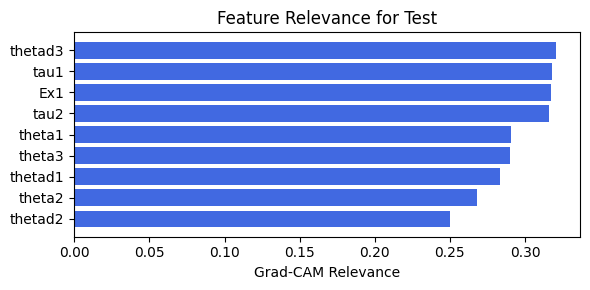

In [78]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.1)

### 2.0.10. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.01

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.29e+00 | reg: 6.18e+02 |: 100%|█| 25/25 [01:52<00:00,  4.51s/i


saving model version 0.1
Best epoch 3
3.387943983078003
M_KAN Relevance: 0.017797159031033516
CNN Relevance: 0.9822028279304504
[('theta2', 0.51251066), ('theta3', 0.4392472), ('thetad2', 0.35657448), ('thetad1', 0.31080633), ('tau2', 0.28751907), ('thetad3', 0.19393565), ('theta1', 0.16895878), ('tau1', 0.098794125)]


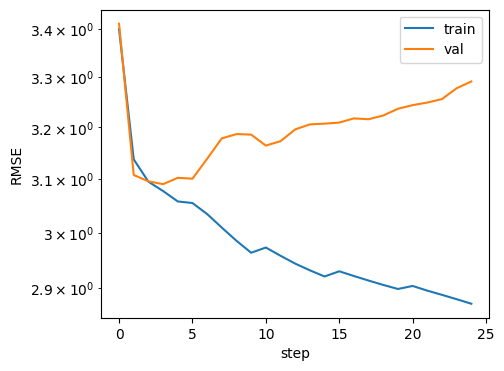

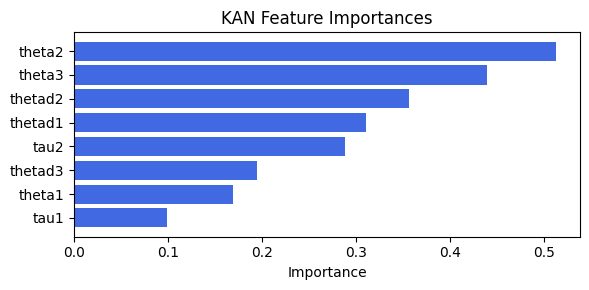

Computing Grad-CAM:  10%|▉         | 158/1639 [00:51<08:05,  3.05it/s]


KeyboardInterrupt: 

In [35]:
train_and_plot_relevance(Model3_2, kan_neurons=2, kan_grid=4, cnn_bottleneck_dim=-1, lamb=1e-05, steps=25, alpha=0.001)

### 2.0.11. width=[8, 2, 1], grid=4, lamb=1e-05 | alpha=0.01

## 2.1.0 width=[8, 3, 1], grid=5, lamb=0.0001

### 2.1.1. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.82e+00 | eval_loss: 3.33e+00 | reg: 2.98e+02 |: 100%|█| 25/25 [01:59<00:00,  4.79s/i


saving model version 0.1
Best epoch 5
3.4510910511016846
M_KAN Relevance: 0.036015115678310394
CNN Relevance: 0.9639848470687866
[('thetad2', 0.49444073), ('theta3', 0.40965492), ('theta2', 0.34264946), ('tau1', 0.31386077), ('thetad3', 0.30058497), ('tau2', 0.27637517), ('thetad1', 0.26036578), ('theta1', 0.1636294)]


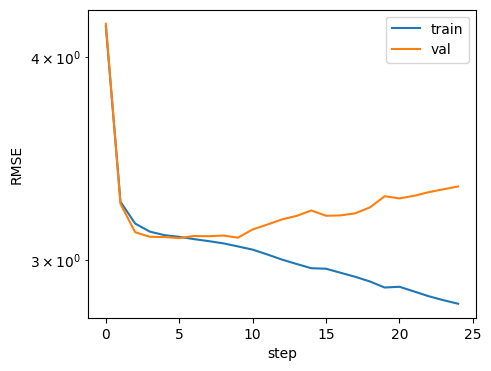

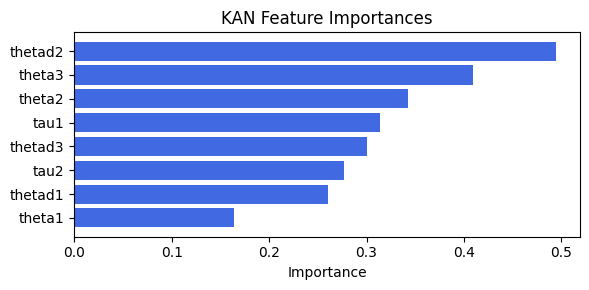

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:12<00:00,  2.97it/s]


[('theta1', 0.39675627578235423), ('thetad1', 0.3458115588577437), ('tau1', 0.3224481321513556), ('thetad2', 0.2670931303011553), ('tau2', 0.2669400580671891), ('theta2', 0.26613319979090533), ('theta3', 0.2237096662973826), ('thetad3', 0.14278231744280764), ('Ex1', 0.09143975721193225)]


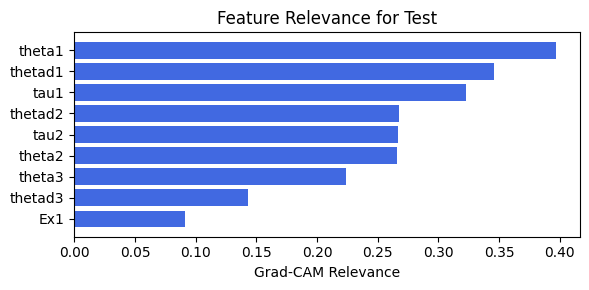

In [143]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.75)

### 2.1.2. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.85e+00 | eval_loss: 3.31e+00 | reg: 2.93e+02 |: 100%|█| 25/25 [02:06<00:00,  5.05s/i


saving model version 0.1
Best epoch 8
3.4037342071533203
M_KAN Relevance: 0.032008953392505646
CNN Relevance: 0.9679909944534302
[('thetad2', 0.45302662), ('theta2', 0.39764297), ('tau1', 0.32349634), ('theta3', 0.3140707), ('thetad3', 0.30669856), ('thetad1', 0.2723281), ('tau2', 0.2704985), ('theta1', 0.13530728)]


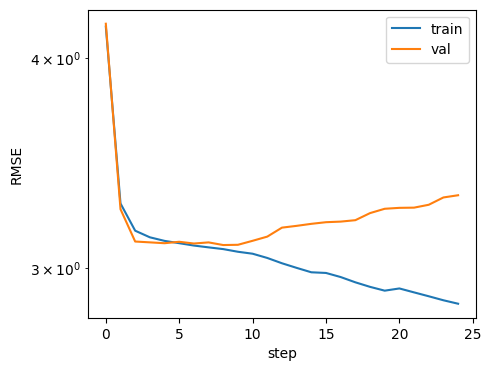

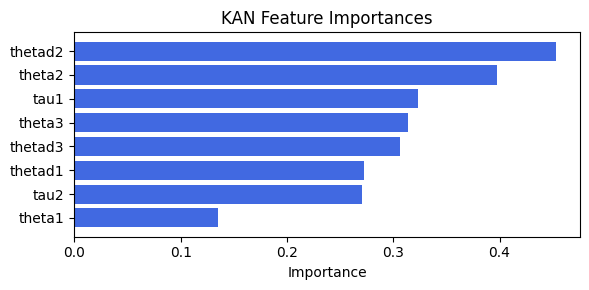

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:30<00:00,  2.88it/s]


[('theta1', 0.3700103632408699), ('thetad1', 0.3316089785202887), ('tau1', 0.31302291577991015), ('thetad2', 0.23656862437874634), ('tau2', 0.229303795270124), ('theta2', 0.20427062476721838), ('theta3', 0.18635300660748835), ('Ex1', 0.15832340679562154), ('thetad3', 0.13473605729353413)]


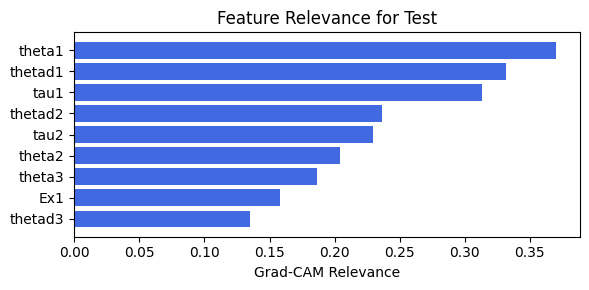

In [137]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.75)

### 2.1.3. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.28e+00 | reg: 2.98e+02 |: 100%|█| 25/25 [02:05<00:00,  5.01s/i


saving model version 0.1
Best epoch 7
3.3803629875183105
M_KAN Relevance: 0.029018087312579155
CNN Relevance: 0.9709818959236145
[('thetad2', 0.4549824), ('theta2', 0.42374548), ('thetad1', 0.4023723), ('tau1', 0.31403178), ('theta3', 0.27100384), ('thetad3', 0.26473612), ('tau2', 0.23885354), ('theta1', 0.11944031)]


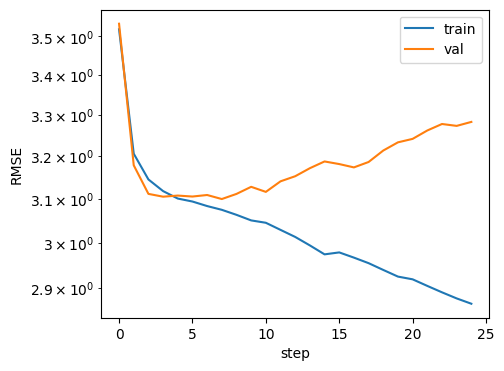

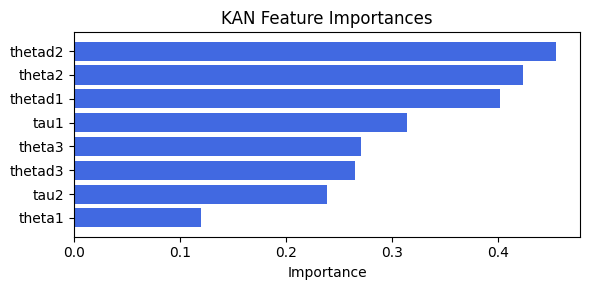

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:26<00:00,  2.89it/s]


[('theta1', 0.33859740987066644), ('thetad1', 0.2835610848018562), ('thetad2', 0.27984067974105686), ('theta2', 0.2729500671371167), ('tau1', 0.2554885684853136), ('theta3', 0.24880870560718182), ('Ex1', 0.20581878812484578), ('tau2', 0.1767260794029308), ('thetad3', 0.14763854416970507)]


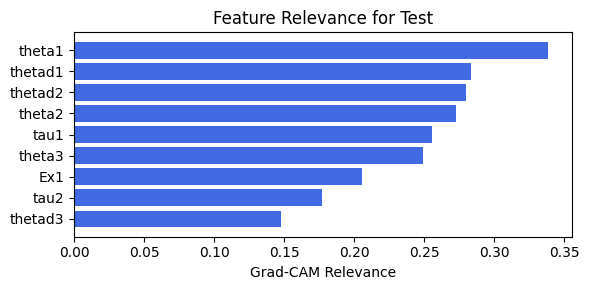

In [138]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.5)

### 2.1.4. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.31e+00 | reg: 3.15e+02 |: 100%|█| 25/25 [02:02<00:00,  4.90s/i


saving model version 0.1
Best epoch 7
3.3973569869995117
M_KAN Relevance: 0.030021900311112404
CNN Relevance: 0.9699780344963074
[('theta2', 0.45318663), ('thetad2', 0.44359392), ('tau1', 0.3319874), ('thetad1', 0.33058906), ('theta3', 0.32913145), ('thetad3', 0.26851034), ('tau2', 0.13919221), ('theta1', 0.089760564)]


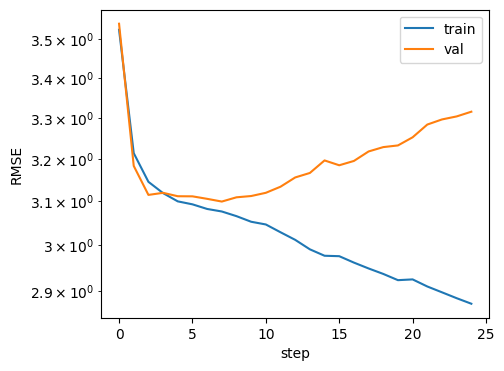

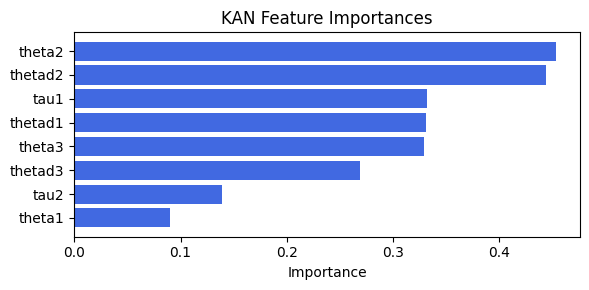

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:31<00:00,  2.87it/s]


[('theta1', 0.379891320895486), ('thetad1', 0.3280039308103559), ('theta2', 0.3088276051277718), ('thetad2', 0.3006065894783968), ('tau1', 0.2806143457204734), ('theta3', 0.24836910092273462), ('tau2', 0.2059659265041579), ('thetad3', 0.18154172314612615), ('Ex1', 0.17666809617510162)]


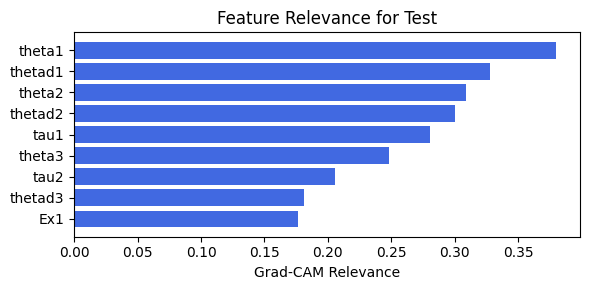

In [146]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.5)

### 2.1.5. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.86e+00 | eval_loss: 3.35e+00 | reg: 3.96e+02 |: 100%|█| 25/25 [02:05<00:00,  5.01s/i


saving model version 0.1
Best epoch 3
3.416498899459839
M_KAN Relevance: 0.026944445446133614
CNN Relevance: 0.9730555415153503
[('theta3', 0.4695995), ('thetad2', 0.39388713), ('tau1', 0.3705978), ('tau2', 0.3589005), ('thetad1', 0.25077763), ('theta1', 0.24301521), ('thetad3', 0.23360126), ('theta2', 0.21782604)]


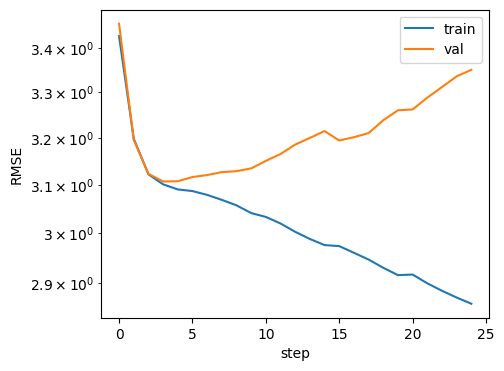

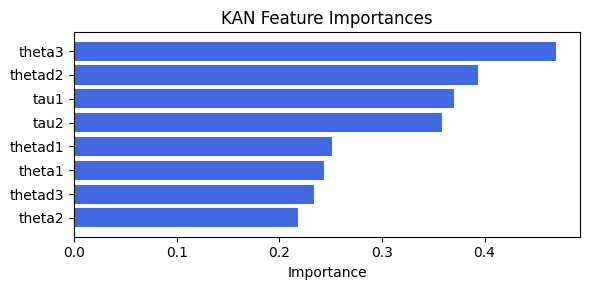

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:11<00:00,  2.97it/s]


[('thetad1', 0.4071966381750653), ('tau2', 0.40436841538997736), ('tau1', 0.3808732263199641), ('theta1', 0.3783018408356727), ('thetad2', 0.2995194289376462), ('theta2', 0.2777763260622269), ('theta3', 0.16511268069137994), ('thetad3', 0.1481553603282532), ('Ex1', 0.09242269892665068)]


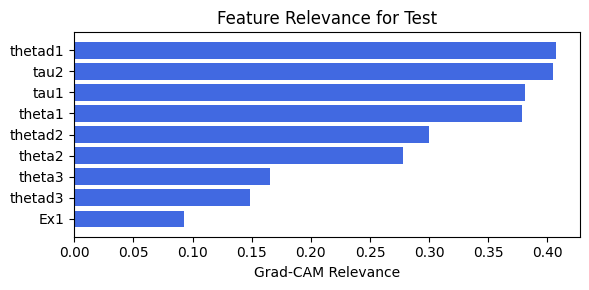

In [139]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.25)

### 2.1.6. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.87e+00 | eval_loss: 3.31e+00 | reg: 3.56e+02 |: 100%|█| 25/25 [02:00<00:00,  4.82s/i


saving model version 0.1
Best epoch 5
3.420424222946167
M_KAN Relevance: 0.02637898176908493
CNN Relevance: 0.9736210107803345
[('theta3', 0.5292527), ('tau1', 0.43280488), ('thetad2', 0.3269563), ('tau2', 0.30687732), ('theta2', 0.25172025), ('thetad1', 0.2308145), ('thetad3', 0.21570659), ('theta1', 0.20251457)]


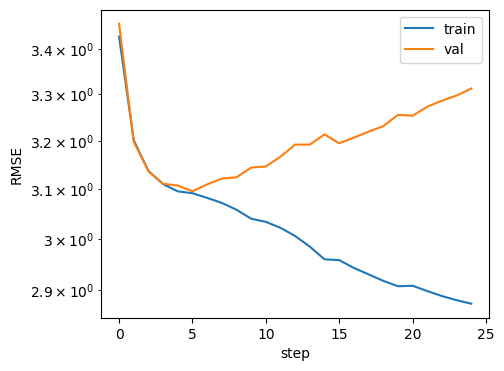

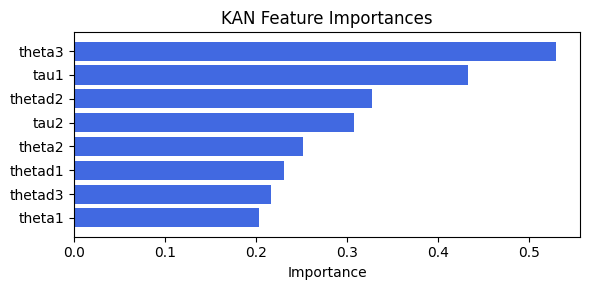

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:09<00:00,  2.98it/s]


[('thetad1', 0.405411592415347), ('tau2', 0.39337777360860593), ('tau1', 0.3886423093260428), ('theta1', 0.38629916393544833), ('thetad2', 0.2822220308125224), ('theta2', 0.27081103318286015), ('theta3', 0.169432541398374), ('thetad3', 0.15345901795686379), ('Ex1', 0.11075755149812753)]


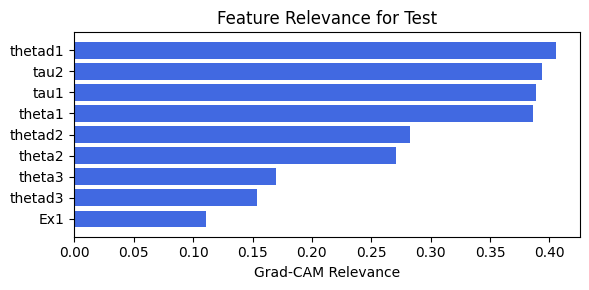

In [140]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.25)

### 2.1.7. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.78e+00 | eval_loss: 3.42e+00 | reg: 3.72e+02 |: 100%|█| 25/25 [02:05<00:00,  5.02s/i


saving model version 0.1
Best epoch 3
3.531453847885132
M_KAN Relevance: 0.04560328647494316
CNN Relevance: 0.9543967247009277
[('theta2', 0.6013157), ('thetad2', 0.3095594), ('theta3', 0.30953214), ('tau2', 0.3058196), ('thetad3', 0.28835404), ('theta1', 0.27365047), ('thetad1', 0.24932739), ('tau1', 0.22537923)]


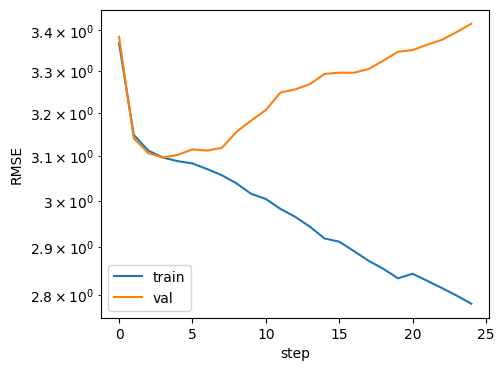

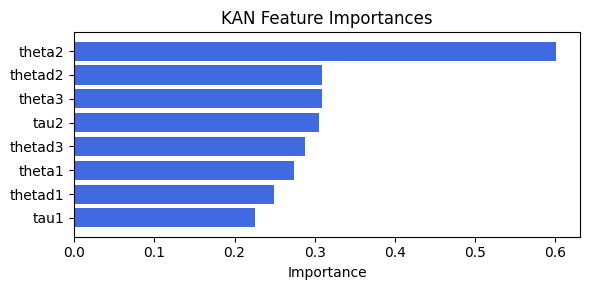

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:19<00:00,  2.93it/s]


[('Ex1', 0.45352774879364144), ('tau1', 0.4261915535281288), ('tau2', 0.39257365876381073), ('thetad1', 0.3873835476701152), ('theta1', 0.38712967088294875), ('thetad2', 0.36183470960720965), ('theta2', 0.31150911382389984), ('theta3', 0.24190301301782108), ('thetad3', 0.16001252214751097)]


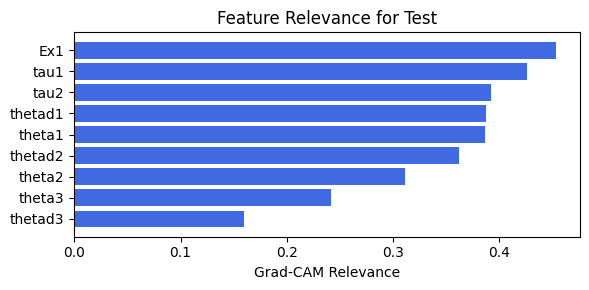

In [144]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.1)

### 2.1.8. width=[8, 3, 1], grid=5, lamb=0.0001 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.80e+00 | eval_loss: 3.40e+00 | reg: 3.70e+02 |: 100%|█| 25/25 [01:58<00:00,  4.74s/i


saving model version 0.1
Best epoch 3
3.474411725997925
M_KAN Relevance: 0.05102698504924774
CNN Relevance: 0.9489730596542358
[('theta2', 0.6189315), ('theta3', 0.49309903), ('thetad1', 0.2592811), ('tau2', 0.25528568), ('tau1', 0.25193307), ('theta1', 0.24092707), ('thetad3', 0.21982126), ('thetad2', 0.20129733)]


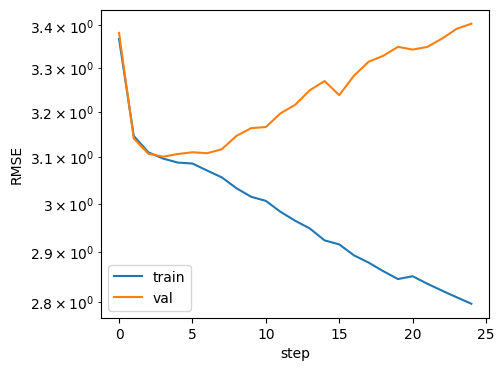

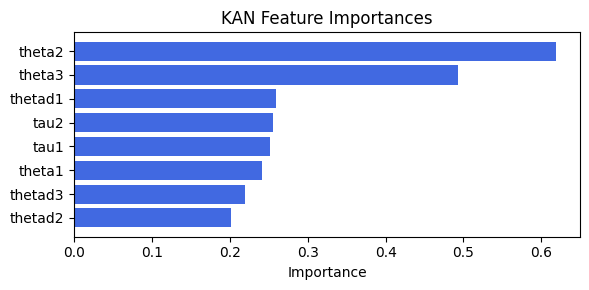

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:09<00:00,  2.98it/s]


[('Ex1', 0.4481316039413616), ('tau1', 0.4099840098971605), ('thetad1', 0.38540467678389484), ('tau2', 0.3834884416264497), ('theta1', 0.3789759696608076), ('thetad2', 0.3642721506048524), ('theta2', 0.2956273219989926), ('theta3', 0.21443324182465598), ('thetad3', 0.13222180710187856)]


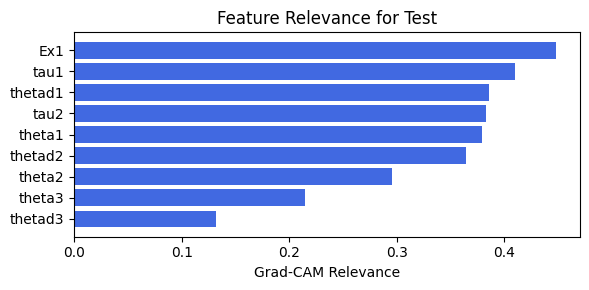

In [145]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.1)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 2.94e+00 | eval_loss: 3.22e+00 | reg: 3.94e+02 |: 100%|█| 25/25 [01:40<00:00,  4.02s/i


saving model version 0.1
Best epoch 4
3.3734142780303955
M_KAN Relevance: 0.03981582447886467
CNN Relevance: 0.9601841568946838
[('thetad1', 0.45890546), ('theta2', 0.39182562), ('thetad2', 0.34027535), ('thetad3', 0.3217163), ('theta3', 0.31379437), ('tau2', 0.26651675), ('theta1', 0.20116203), ('tau1', 0.18789473)]


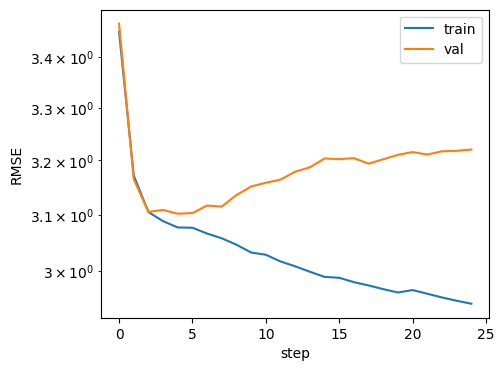

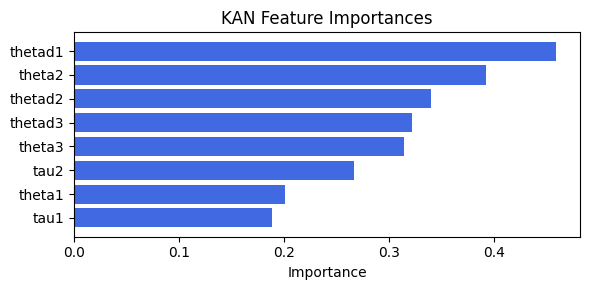

Computing Grad-CAM:   4%|▍         | 66/1639 [00:24<09:41,  2.71it/s]


KeyboardInterrupt: 

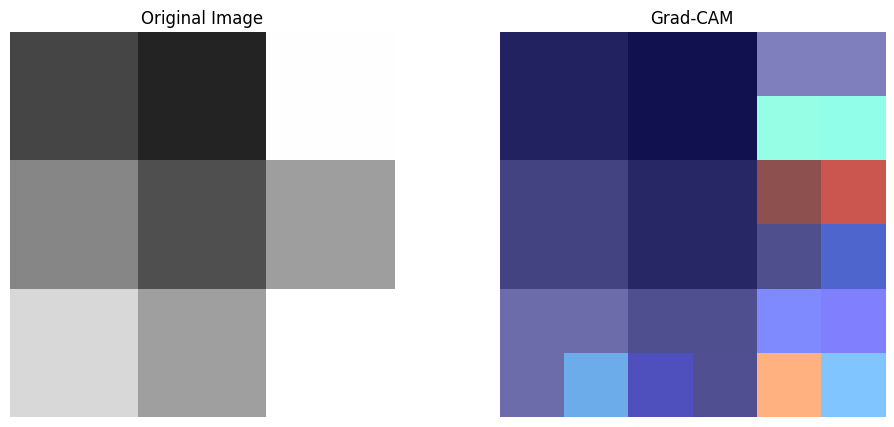

In [37]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.0001, steps=25, alpha=0.01)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.19e+00 | eval_loss: 3.10e+00 | reg: 7.90e+01 |: 100%|█| 25/25 [01:40<00:00,  4.01s/i


saving model version 0.1
Best epoch 12
3.2419204711914062
M_KAN Relevance: 0.026792073622345924
CNN Relevance: 0.973207950592041
[('tau1', 0.500834), ('theta2', 0.35892114), ('thetad1', 0.3584306), ('thetad2', 0.32065135), ('thetad3', 0.22247407), ('tau2', 0.21232514), ('theta1', 0.19125897), ('theta3', 0.16350165)]


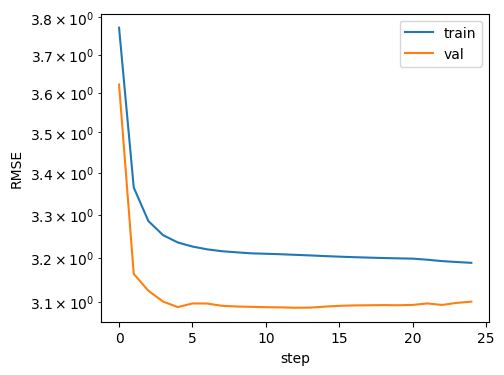

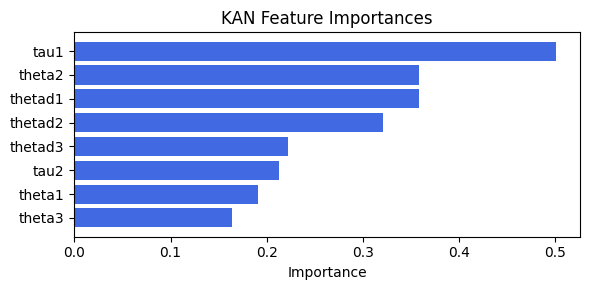

Computing Grad-CAM:   1%|▏         | 22/1639 [00:08<09:55,  2.72it/s]

KeyboardInterrupt



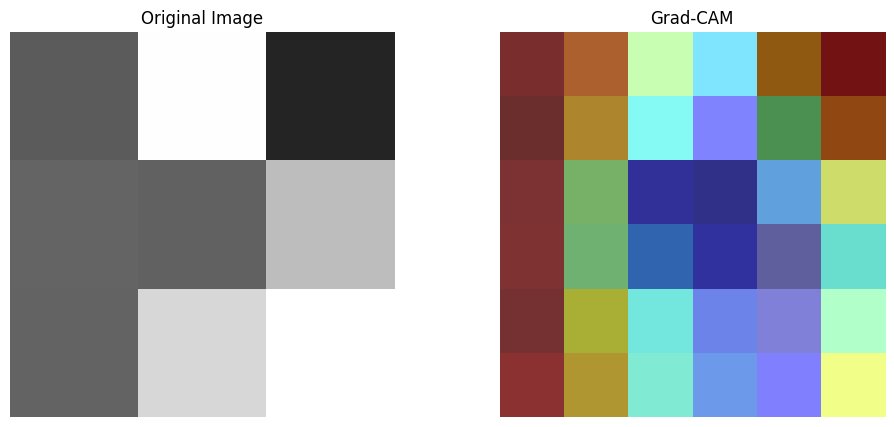

In [38]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.01)

## 2.2.0 width=[8, 4, 1], grid=3, lamb=0.01

### 2.2.1. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.28e+01 |: 100%|█| 25/25 [01:24<00:00,  3.39s/i

saving model version 0.1
Best epoch 2
3.250105142593384
M_KAN Relevance: 0.21876277029514313
CNN Relevance: 0.7812372446060181
[('theta2', 0.42996952), ('tau1', 0.36119604), ('tau2', 0.21862777), ('theta1', 0.20204586), ('thetad2', 0.1770963), ('thetad1', 0.14585522), ('thetad3', 0.14102104), ('theta3', 0.13212825)]


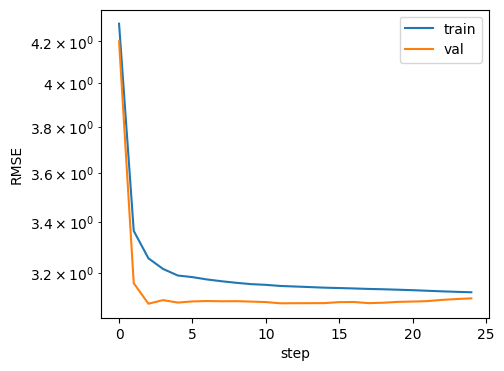

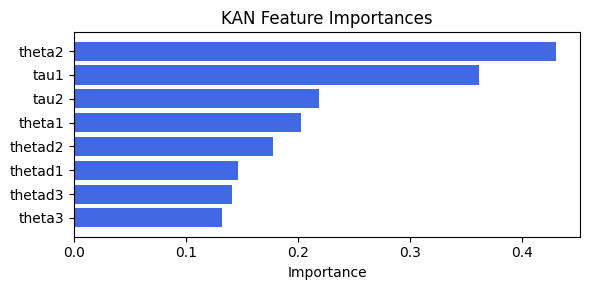

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.38it/s]


[('tau1', 0.3753163109227486), ('thetad2', 0.33687115714798216), ('theta1', 0.3362558879006844), ('thetad1', 0.3238449667143886), ('theta2', 0.26923968103834894), ('theta3', 0.26908408338154305), ('tau2', 0.25447191235817396), ('thetad3', 0.16978493852457233), ('Ex1', 0.060362071925767244)]


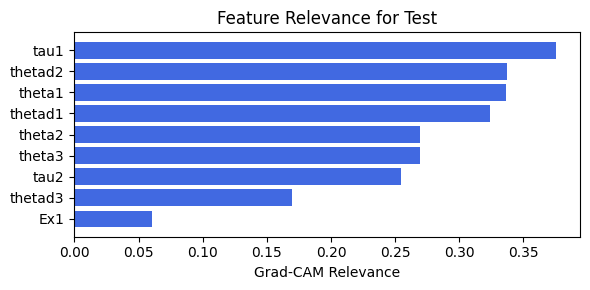

In [70]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.2.2. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.10e+00 | reg: 4.20e+01 |: 100%|█| 25/25 [01:26<00:00,  3.45s/i

saving model version 0.1
Best epoch 17
3.2360968589782715
M_KAN Relevance: 0.20662936568260193
CNN Relevance: 0.7933706045150757
[('theta2', 0.49098557), ('thetad3', 0.3233158), ('tau1', 0.28804767), ('thetad2', 0.2550791), ('thetad1', 0.19328639), ('theta3', 0.16952097), ('theta1', 0.13702482), ('tau2', 0.12853044)]


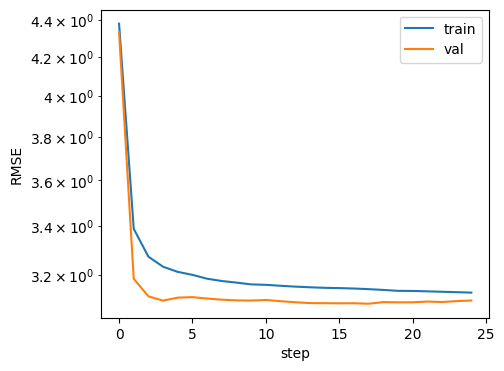

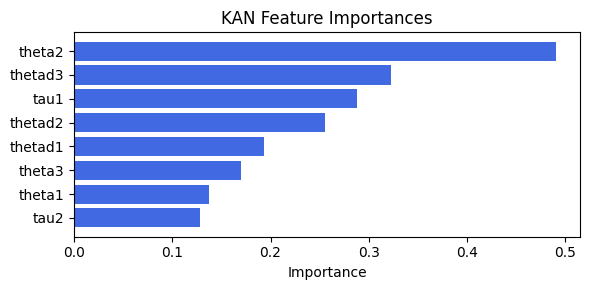

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.41it/s]

[('tau1', 0.355700905893328), ('tau2', 0.2975668978061933), ('theta1', 0.29257714687145553), ('thetad1', 0.29224549365874164), ('thetad2', 0.2118060058319654), ('theta2', 0.19202085034189642), ('theta3', 0.14460079379266888), ('thetad3', 0.11627743746019809), ('Ex1', 0.10352234241758038)]


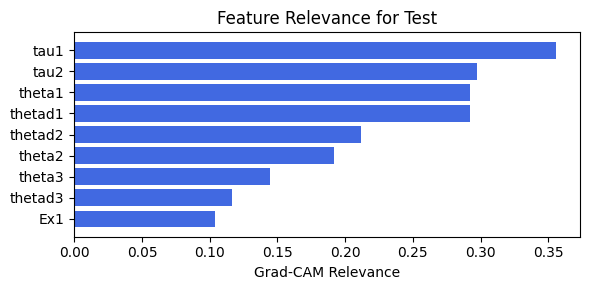

In [71]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.2.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.12e+00 | reg: 4.67e+01 |: 100%|█| 25/25 [01:25<00:00,  3.43s/i


saving model version 0.1
Best epoch 3
3.269850730895996
M_KAN Relevance: 0.30266261100769043
CNN Relevance: 0.6973373889923096
[('theta2', 0.49807495), ('thetad1', 0.30979156), ('thetad2', 0.27387357), ('tau2', 0.2479909), ('theta3', 0.2083409), ('thetad3', 0.19941106), ('theta1', 0.14393356), ('tau1', 0.13537166)]


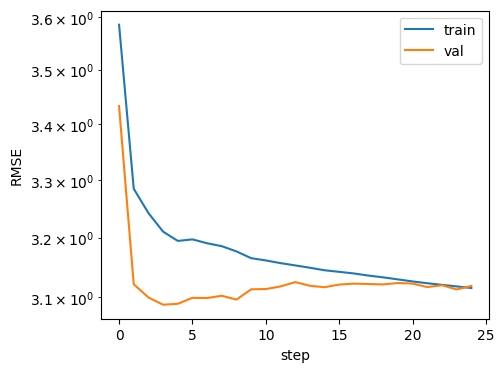

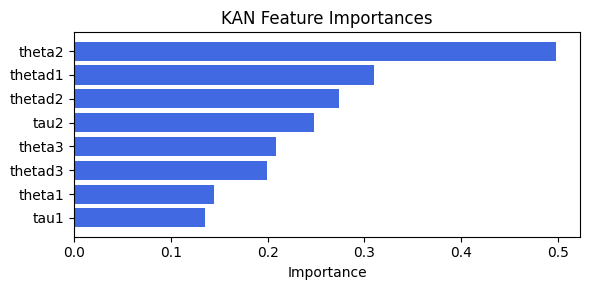

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.58it/s]

[('tau1', 0.39430408295324737), ('tau2', 0.370365247066291), ('theta1', 0.3374418378128752), ('thetad1', 0.3315574569959336), ('theta2', 0.2536505999201151), ('thetad2', 0.2355993211968137), ('theta3', 0.2269107325408229), ('thetad3', 0.1738323229088751), ('Ex1', 0.14823029509103372)]


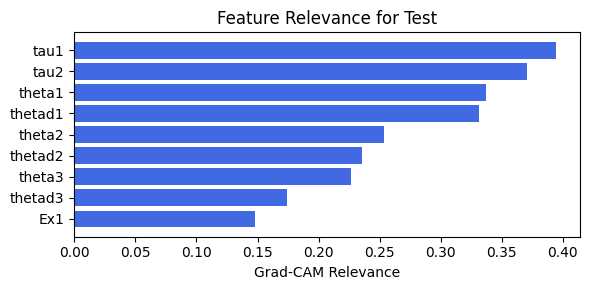

In [73]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.2.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 4.61e+01 |: 100%|█| 25/25 [01:33<00:00,  3.72s/i

saving model version 0.1
Best epoch 4
3.247544288635254
M_KAN Relevance: 0.300762414932251
CNN Relevance: 0.699237585067749
[('theta2', 0.40139994), ('thetad2', 0.37857863), ('theta3', 0.31825203), ('thetad3', 0.3089362), ('thetad1', 0.14366584), ('tau2', 0.12737086), ('tau1', 0.110708006), ('theta1', 0.060755588)]


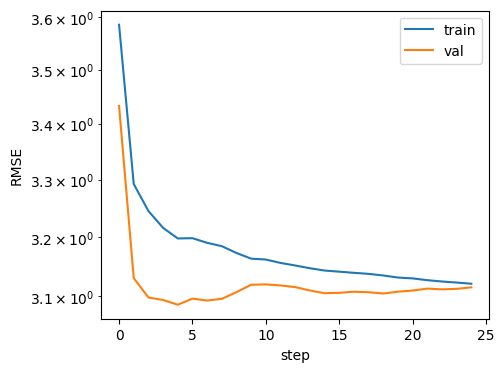

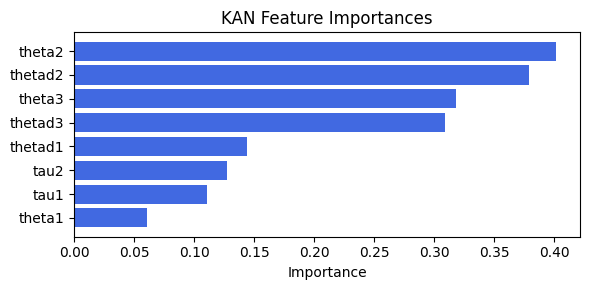

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:16<00:00, 12.02it/s]

[('tau1', 0.3871871744749874), ('tau2', 0.36417170804629784), ('theta1', 0.35039313364331626), ('thetad1', 0.34365328238111287), ('theta2', 0.2688364232747097), ('thetad2', 0.24703874943578977), ('theta3', 0.2228285370251572), ('thetad3', 0.19370011927434358), ('Ex1', 0.14695134256469938)]


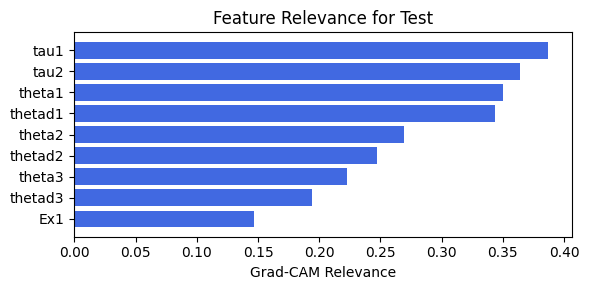

In [74]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.2.4. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.11e+00 | reg: 4.34e+01 |: 100%|█| 25/25 [01:26<00:00,  3.45s/i

saving model version 0.1
Best epoch 4
3.2580480575561523
M_KAN Relevance: 0.5148178339004517
CNN Relevance: 0.48518213629722595
[('theta3', 0.3895879), ('theta2', 0.37207553), ('thetad3', 0.31935415), ('tau2', 0.19509861), ('theta1', 0.17151125), ('thetad2', 0.14589646), ('thetad1', 0.13669014), ('tau1', 0.12856652)]


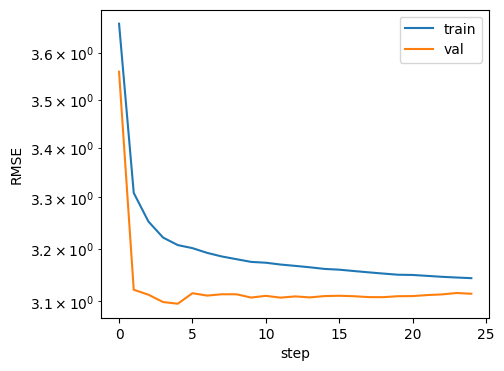

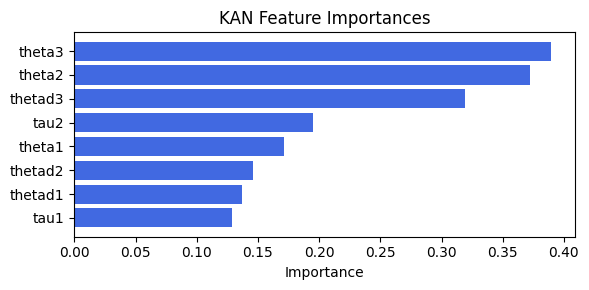

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.85it/s]

[('tau1', 0.38534260849714114), ('tau2', 0.3665277960223613), ('theta1', 0.35371469201054245), ('thetad1', 0.34455945093745194), ('theta2', 0.2615867531417299), ('thetad2', 0.2561809849655523), ('Ex1', 0.22882511423316548), ('theta3', 0.2275242232602508), ('thetad3', 0.2219478420472174)]


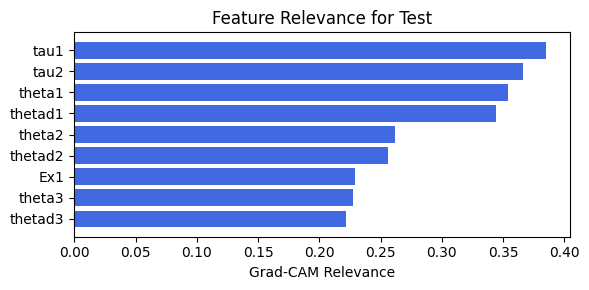

In [75]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.2.5. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.10e+00 | reg: 4.26e+01 |: 100%|█| 25/25 [01:25<00:00,  3.41s/i

saving model version 0.1
Best epoch 20
3.249744415283203
M_KAN Relevance: 0.512129008769989
CNN Relevance: 0.4878709614276886
[('theta3', 0.41722378), ('theta2', 0.37408042), ('thetad3', 0.25076848), ('tau2', 0.2429871), ('theta1', 0.17503753), ('tau1', 0.13963297), ('thetad1', 0.13387108), ('thetad2', 0.1287557)]


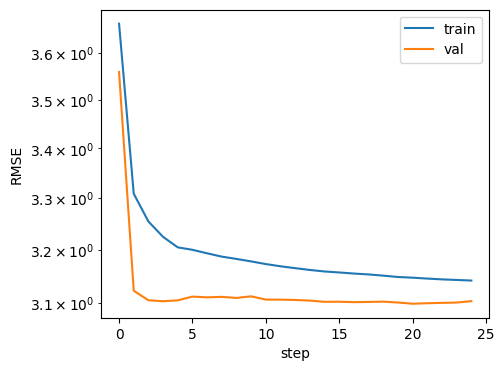

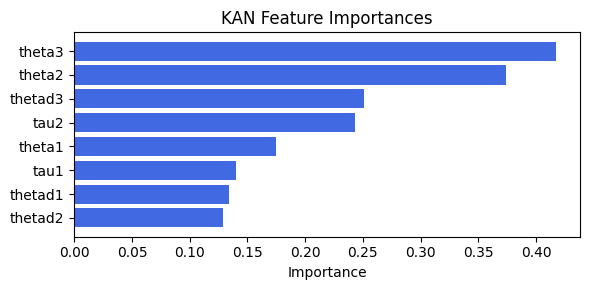

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:15<00:00, 12.08it/s]

[('thetad3', 0.3878866928582057), ('theta1', 0.31645177179743855), ('thetad1', 0.3062433717533212), ('tau1', 0.29499018432665103), ('tau2', 0.25135907828174836), ('theta2', 0.22319882811219593), ('thetad2', 0.2004588830438533), ('Ex1', 0.1844713390502571), ('theta3', 0.17667614204494841)]


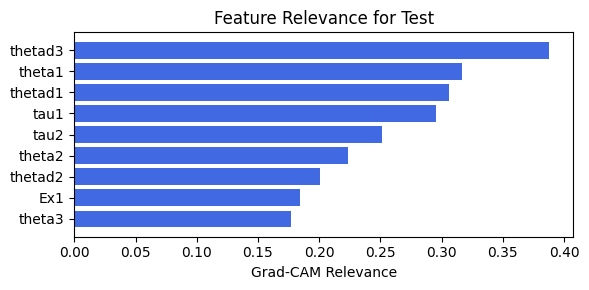

In [76]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.2.5.1 width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.15e+00 | eval_loss: 3.10e+00 | reg: 4.22e+01 |: 100%|█| 25/25 [01:32<00:00,  3.71s/i

saving model version 0.1
Best epoch 4
3.24851131439209
M_KAN Relevance: 0.502426266670227
CNN Relevance: 0.49757373332977295
[('theta2', 0.5518039), ('theta3', 0.29169586), ('thetad1', 0.22979157), ('theta1', 0.16785002), ('thetad3', 0.15328497), ('tau1', 0.12260153), ('tau2', 0.114924714), ('thetad2', 0.11377369)]


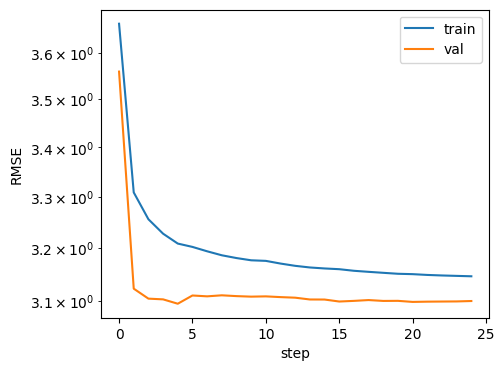

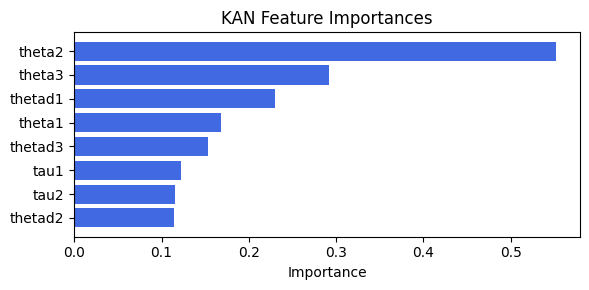

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:22<00:00, 11.49it/s]

[('tau1', 0.39825626153000554), ('theta1', 0.37902349833418375), ('tau2', 0.3707284518618627), ('thetad1', 0.36596777719583534), ('theta2', 0.2755874396437683), ('thetad2', 0.2732390185068226), ('theta3', 0.23216014525549736), ('Ex1', 0.22117218049790455), ('thetad3', 0.2068302020818699)]


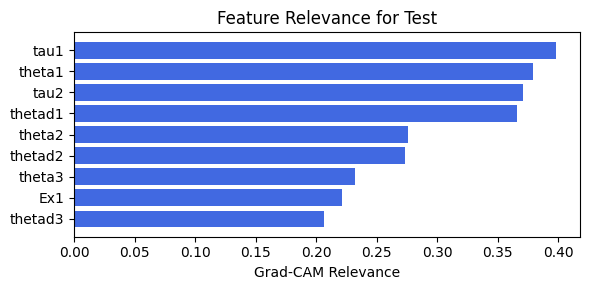

In [77]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.2.6. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 3.28e+01 |: 100%|█| 25/25 [01:30<00:00,  3.63s/i


saving model version 0.1
Best epoch 2
3.2692737579345703
M_KAN Relevance: 0.8891749382019043
CNN Relevance: 0.1108250766992569
[('theta2', 0.6126857), ('thetad1', 0.27761763), ('theta3', 0.25551325), ('thetad3', 0.19865215), ('thetad2', 0.18225318), ('tau2', 0.15269582), ('theta1', 0.14538507), ('tau1', 0.10097511)]


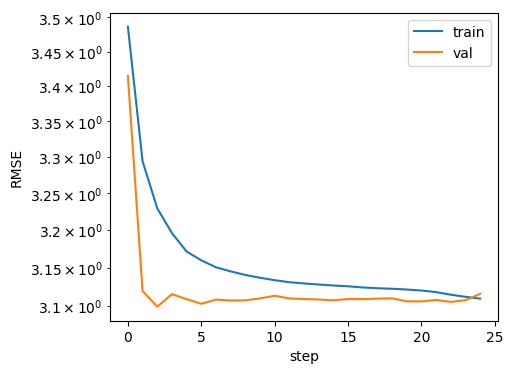

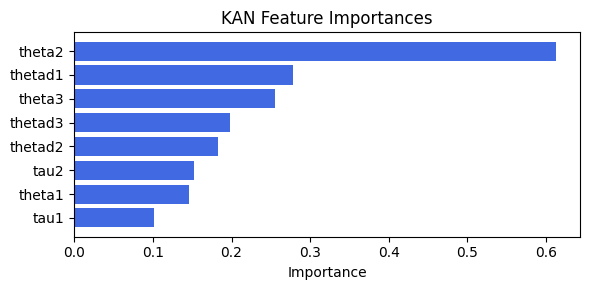

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:40<00:00, 10.24it/s]

[('theta1', 0.38185858603732664), ('thetad1', 0.3520353588441391), ('theta2', 0.31115382624219856), ('tau1', 0.30715236516372213), ('thetad2', 0.2893737919470476), ('tau2', 0.27746355760251484), ('theta3', 0.22291243857269552), ('thetad3', 0.15423098807428945), ('Ex1', 0.12496025040764647)]


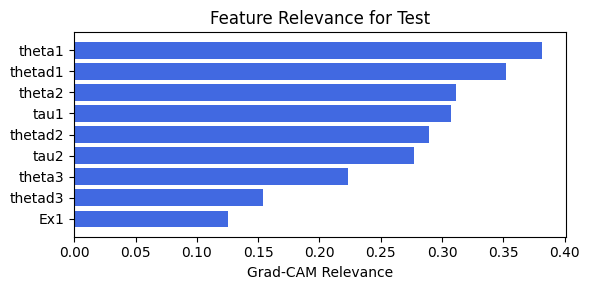

In [79]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

### 2.2.7. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 3.29e+01 |: 100%|█| 25/25 [01:30<00:00,  3.60s/i

saving model version 0.1
Best epoch 2
3.2632553577423096
M_KAN Relevance: 0.8902127742767334
CNN Relevance: 0.10978719592094421
[('theta2', 0.7023329), ('thetad3', 0.2582794), ('theta3', 0.24625519), ('theta1', 0.20046246), ('tau2', 0.16305995), ('thetad2', 0.14542797), ('tau1', 0.12011014), ('thetad1', 0.11230823)]


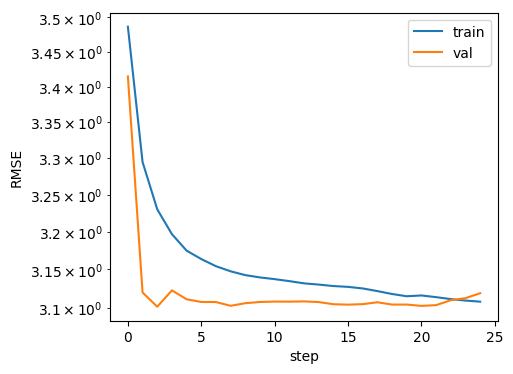

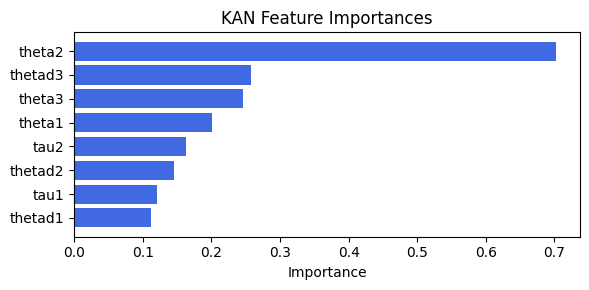

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.62it/s]

[('theta1', 0.3759292545467001), ('thetad1', 0.34908138958892115), ('theta2', 0.31115436287066384), ('tau1', 0.3042114589525565), ('thetad2', 0.28678379293361317), ('tau2', 0.27613123538890044), ('theta3', 0.21615461232031277), ('thetad3', 0.14946963573729513), ('Ex1', 0.11869939072384957)]


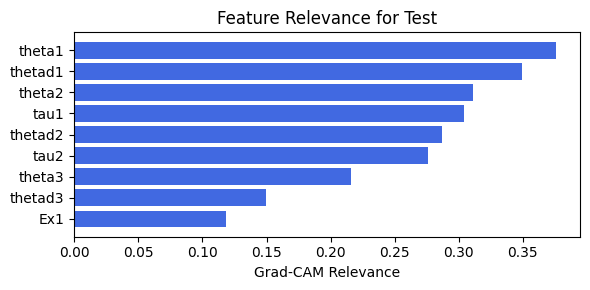

In [81]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

## 2.3.0 width=[8, 4, 1], grid=3, lamb=0.01

### 2.3.1. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.23e+01 |: 100%|█| 25/25 [01:27<00:00,  3.51s/i

saving model version 0.1
Best epoch 4
3.237839460372925
M_KAN Relevance: 0.20375847816467285
CNN Relevance: 0.7962415218353271
[('theta2', 0.35506606), ('thetad3', 0.3361926), ('theta1', 0.2922682), ('theta3', 0.19434077), ('thetad1', 0.19414352), ('thetad2', 0.19265765), ('tau2', 0.15795742), ('tau1', 0.13597222)]


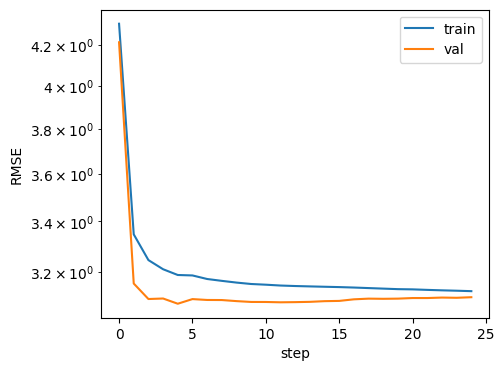

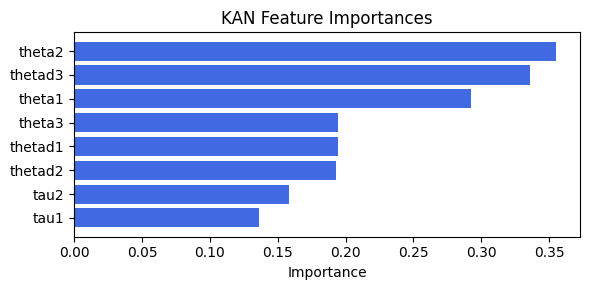

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:29<00:00, 10.95it/s]


[('tau1', 0.4139588204734398), ('theta1', 0.38770357942794775), ('thetad1', 0.38689311852550023), ('tau2', 0.32105526352260877), ('thetad2', 0.26955017034413864), ('theta2', 0.2650759067884421), ('theta3', 0.2384766909929036), ('thetad3', 0.18505288600597067), ('Ex1', 0.06920594284790112)]


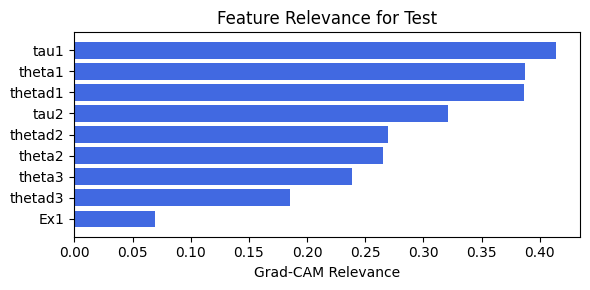

In [82]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.3.2. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 4.36e+01 |: 100%|█| 25/25 [01:26<00:00,  3.45s/i

saving model version 0.1
Best epoch 4
3.2425904273986816
M_KAN Relevance: 0.23827552795410156
CNN Relevance: 0.7617244720458984
[('theta2', 0.4575334), ('theta1', 0.34410915), ('tau1', 0.2379185), ('thetad2', 0.20898566), ('thetad1', 0.19623794), ('thetad3', 0.19262399), ('theta3', 0.14986296), ('tau2', 0.14611101)]


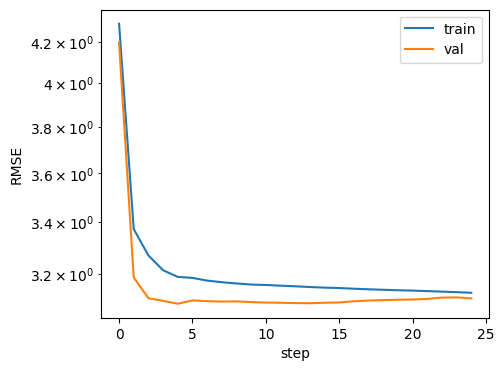

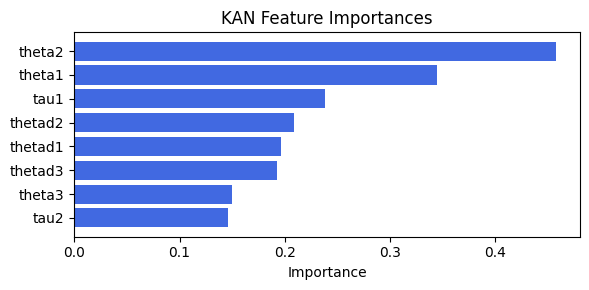

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:18<00:00, 11.81it/s]

[('tau1', 0.37738421883100154), ('theta1', 0.3220523763883847), ('thetad1', 0.2990296976835438), ('theta3', 0.272540792928084), ('tau2', 0.2722717198842226), ('thetad2', 0.2556477294096758), ('theta2', 0.24565198517458228), ('thetad3', 0.13090908682627844), ('Ex1', 0.08180086644772275)]


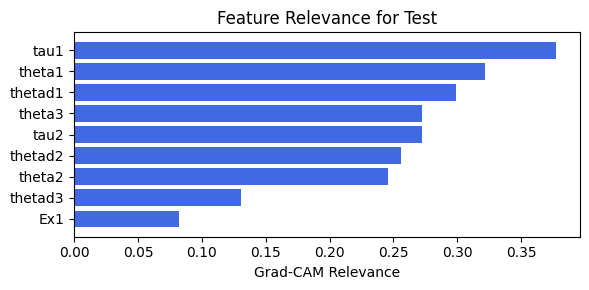

In [83]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.3.2. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.7

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.16e+00 | eval_loss: 3.10e+00 | reg: 4.02e+01 |: 100%|█| 25/25 [01:29<00:00,  3.60s/i

saving model version 0.1
Best epoch 2
3.227149724960327
M_KAN Relevance: 0.4152242839336395
CNN Relevance: 0.5847756862640381
[('thetad2', 0.43874878), ('theta2', 0.3308289), ('theta3', 0.29203153), ('theta1', 0.22009215), ('thetad1', 0.18761757), ('thetad3', 0.18406412), ('tau2', 0.16495726), ('tau1', 0.1402561)]


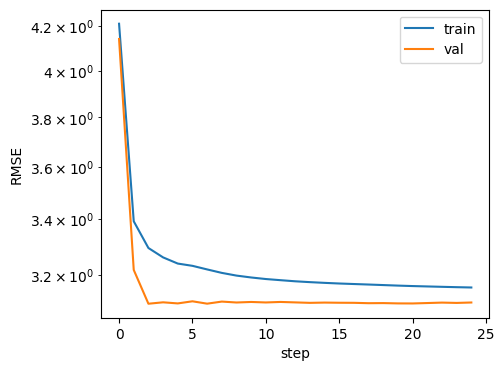

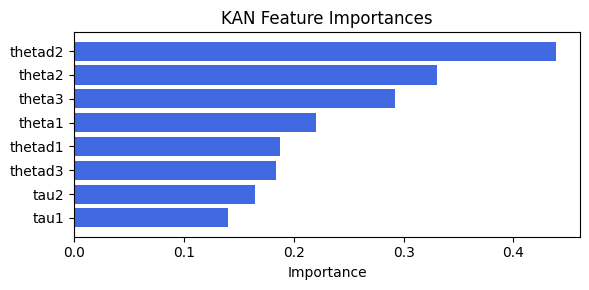

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:21<00:00, 11.60it/s]


[('tau2', 0.2926279053766523), ('tau1', 0.2809403366072568), ('theta3', 0.2585716388213198), ('theta1', 0.24314976554487414), ('thetad1', 0.24029154572391195), ('theta2', 0.22415607388421221), ('thetad2', 0.1955647135409896), ('Ex1', 0.17070035894037422), ('thetad3', 0.15194722558540727)]


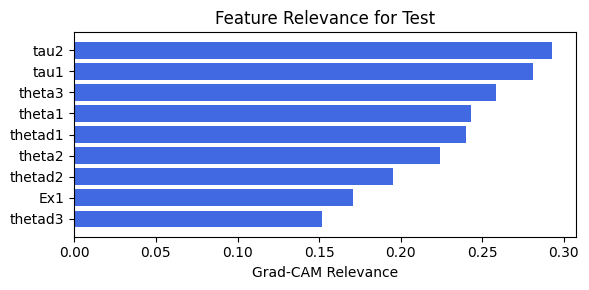

In [42]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.7)

### 2.3.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.7

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.16e+00 | eval_loss: 3.10e+00 | reg: 4.04e+01 |: 100%|█| 25/25 [01:42<00:00,  4.09s/i


saving model version 0.1
Best epoch 4
3.2272539138793945
M_KAN Relevance: 0.40166741609573364
CNN Relevance: 0.5983325839042664
[('theta2', 0.47920197), ('theta3', 0.46331668), ('tau1', 0.21464741), ('thetad2', 0.2013101), ('thetad1', 0.15875477), ('theta1', 0.10295722), ('thetad3', 0.09716466), ('tau2', 0.08124135)]


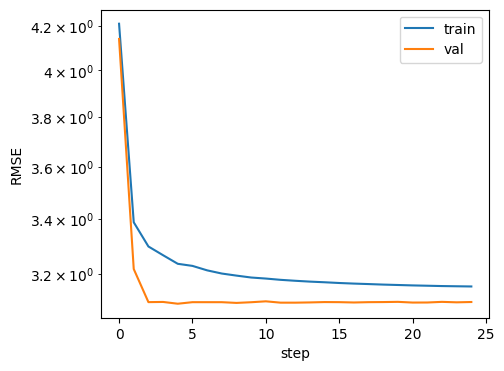

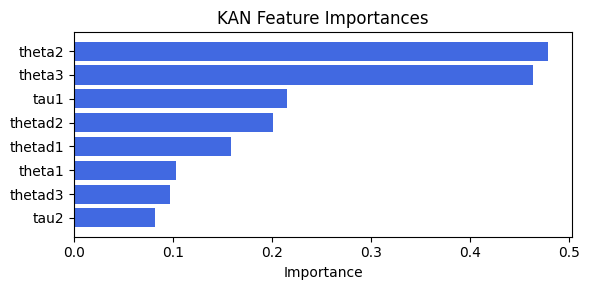

Computing Grad-CAM: 100%|██████████| 1639/1639 [10:30<00:00,  2.60it/s]


[('tau2', 0.39208518582982954), ('thetad1', 0.36340584708614243), ('theta1', 0.330616791734456), ('thetad2', 0.31558007924200127), ('tau1', 0.31547075649307005), ('theta2', 0.29092272951656467), ('theta3', 0.1766281979199859), ('thetad3', 0.10056088559228701), ('Ex1', 0.07813052922665131)]


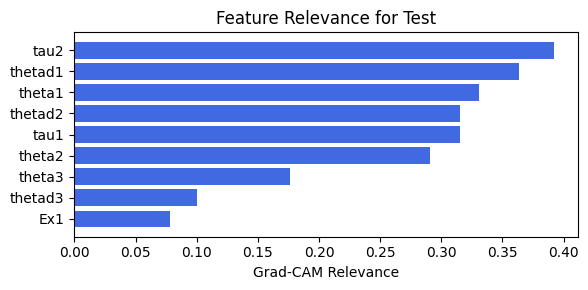

In [40]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.7)

### 2.3.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.68

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.51e+00 | eval_loss: 3.15e+00 | reg: 2.35e+01 |: 100%|█| 25/25 [01:22<00:00,  3.29s/i

saving model version 0.1
Best epoch 10
3.286620855331421
M_KAN Relevance: 1.1811240483439178e-06
CNN Relevance: 0.9999988079071045
[('thetad3', 0.27472693), ('theta2', 0.24499083), ('theta1', 0.21154976), ('tau1', 0.20712152), ('thetad2', 0.20392531), ('tau2', 0.1519049), ('thetad1', 0.060667314), ('theta3', 0.050224658)]


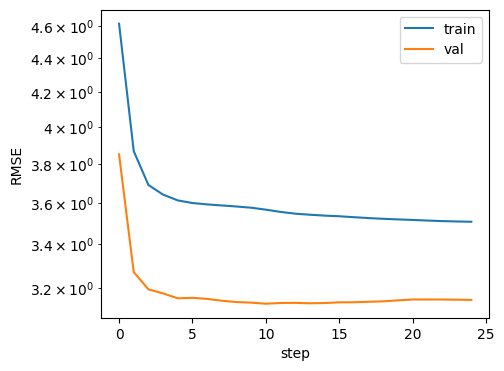

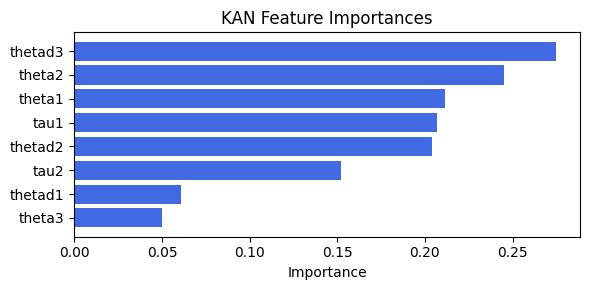

Computing Grad-CAM:   5%|▌         | 82/1639 [00:06<02:03, 12.61it/s]


KeyboardInterrupt: 

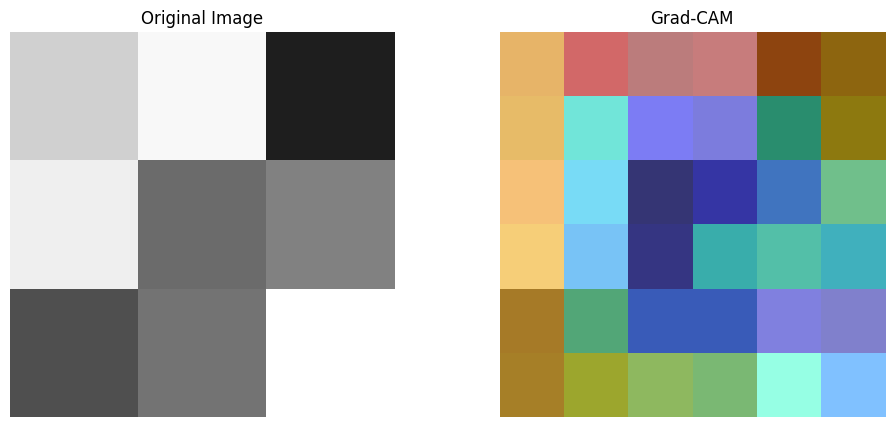

In [36]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.1, steps=25, alpha=0.7)

### 2.3.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.65

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.11e+00 | reg: 3.91e+01 |: 100%|█| 25/25 [01:37<00:00,  3.91s/i


saving model version 0.1
Best epoch 13
3.2489359378814697
M_KAN Relevance: 0.23179979622364044
CNN Relevance: 0.7682002186775208
[('theta2', 0.449319), ('tau1', 0.30062994), ('thetad2', 0.22056559), ('thetad1', 0.21646023), ('theta3', 0.21032432), ('thetad3', 0.18633121), ('theta1', 0.17997837), ('tau2', 0.1493487)]


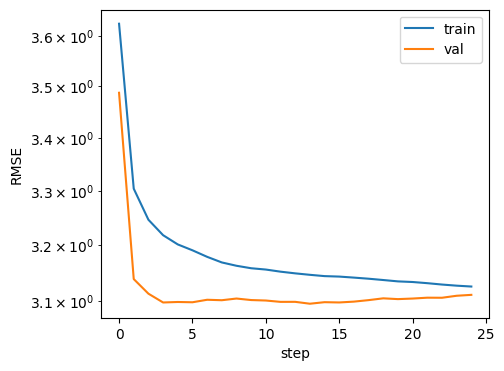

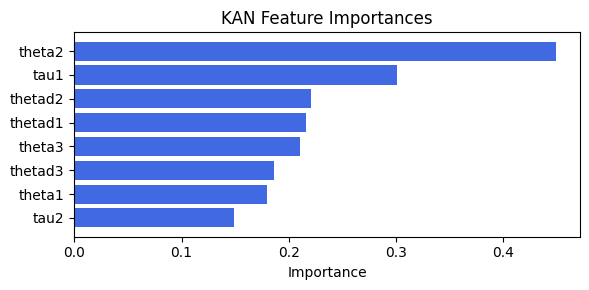

Computing Grad-CAM: 100%|██████████| 1639/1639 [10:13<00:00,  2.67it/s]


[('tau2', 0.33258715232307895), ('theta1', 0.33162454851050627), ('thetad1', 0.32908029340537787), ('thetad2', 0.32127626356498745), ('tau1', 0.31822588280638725), ('theta2', 0.25753506887954863), ('theta3', 0.231107921239395), ('thetad3', 0.17571485917503926), ('Ex1', 0.1614899305792459)]


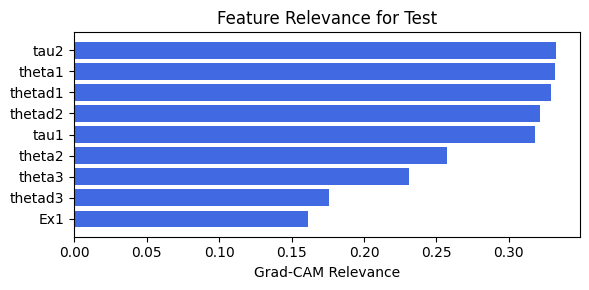

In [41]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.65)

### 2.3.3. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 4.31e+01 |: 100%|█| 25/25 [01:25<00:00,  3.44s/i

saving model version 0.1
Best epoch 4
3.260694980621338
M_KAN Relevance: 0.3186218738555908
CNN Relevance: 0.681378185749054
[('theta2', 0.59096885), ('thetad1', 0.2703099), ('theta1', 0.2618753), ('thetad3', 0.24002096), ('theta3', 0.22457543), ('thetad2', 0.2049242), ('tau2', 0.17204167), ('tau1', 0.1489731)]


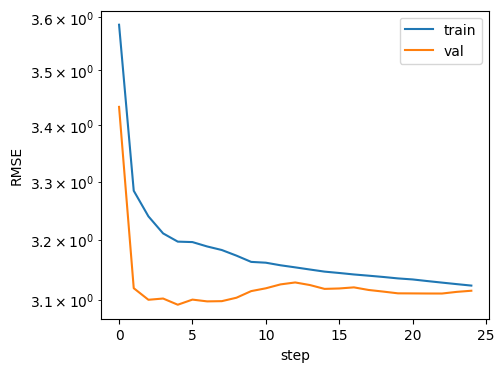

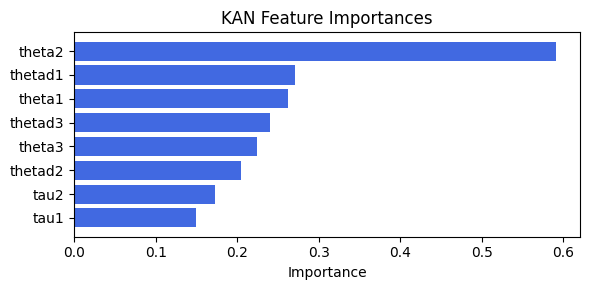

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:34<00:00, 10.62it/s]

[('tau1', 0.38318378938813874), ('tau2', 0.3621228046138439), ('theta1', 0.3549605924983809), ('thetad1', 0.34639691903925035), ('theta2', 0.26946731672889224), ('thetad2', 0.24778165077375228), ('theta3', 0.21719569781205575), ('thetad3', 0.1869213453101244), ('Ex1', 0.13774999267478094)]


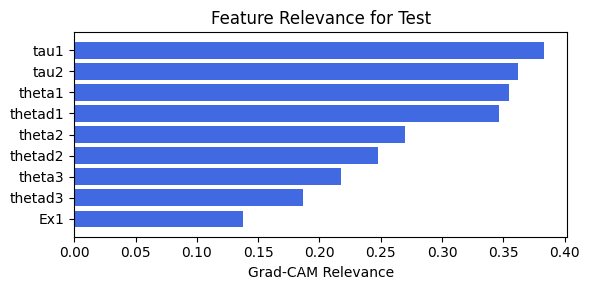

In [84]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.3.4. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.11e+00 | reg: 4.99e+01 |: 100%|█| 25/25 [01:27<00:00,  3.52s/i

saving model version 0.1
Best epoch 3
3.259371519088745
M_KAN Relevance: 0.2813014090061188
CNN Relevance: 0.7186986207962036
[('theta2', 0.571327), ('thetad2', 0.33734787), ('theta3', 0.2956668), ('thetad3', 0.2659723), ('tau2', 0.1918074), ('thetad1', 0.1227778), ('tau1', 0.11021446), ('theta1', 0.08974374)]


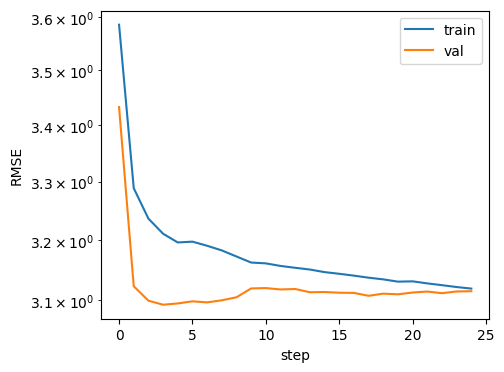

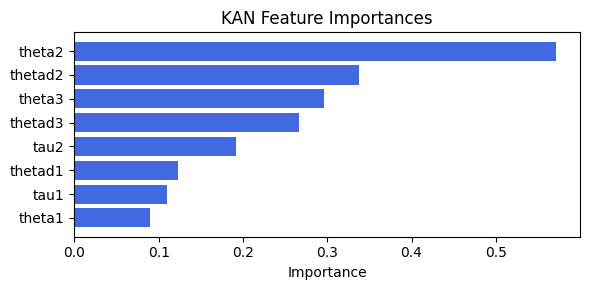

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:34<00:00, 10.60it/s]


[('tau1', 0.3978482949736192), ('tau2', 0.3682025552821679), ('theta1', 0.3302181968230699), ('thetad1', 0.32306338605657975), ('theta2', 0.2428552330785307), ('theta3', 0.22719467592700807), ('thetad2', 0.22000366491554857), ('thetad3', 0.16522518327023436), ('Ex1', 0.14253706153304416)]


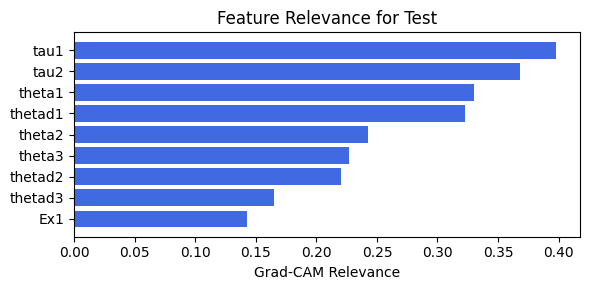

In [85]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.3.5. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.12e+00 | reg: 4.27e+01 |: 100%|█| 25/25 [01:27<00:00,  3.50s/i

saving model version 0.1
Best epoch 4
3.260810375213623
M_KAN Relevance: 0.5056442618370056
CNN Relevance: 0.494355708360672
[('tau1', 0.35870236), ('tau2', 0.2972779), ('thetad2', 0.28672123), ('theta2', 0.27543023), ('theta3', 0.25855288), ('thetad3', 0.19960861), ('theta1', 0.1432256), ('thetad1', 0.09614723)]


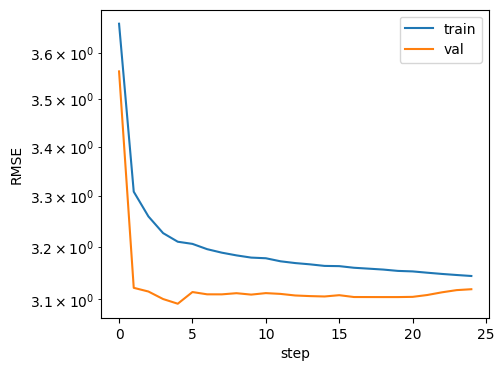

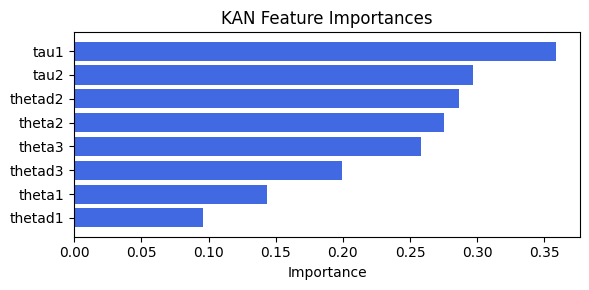

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:34<00:00, 10.60it/s]

[('tau1', 0.3846749946726611), ('theta1', 0.37058336855861773), ('tau2', 0.3554382484338383), ('thetad1', 0.3548616600546899), ('thetad2', 0.27418145093449764), ('theta2', 0.26775047159877596), ('theta3', 0.22713199749579308), ('Ex1', 0.20792791584416218), ('thetad3', 0.1753803317444071)]


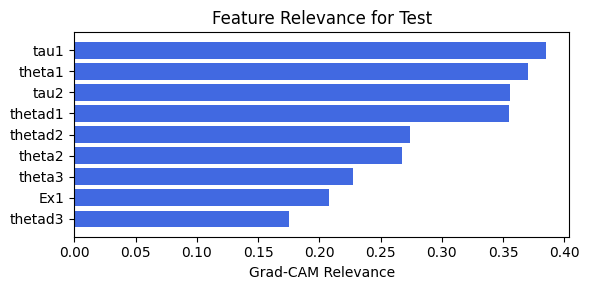

In [86]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.3.6. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.14e+00 | eval_loss: 3.10e+00 | reg: 4.34e+01 |: 100%|█| 25/25 [01:27<00:00,  3.49s/i

saving model version 0.1
Best epoch 4
3.248838424682617
M_KAN Relevance: 0.499721497297287
CNN Relevance: 0.5002785325050354
[('theta2', 0.44732317), ('theta3', 0.3540444), ('thetad2', 0.3208848), ('tau2', 0.22596756), ('tau1', 0.19759569), ('thetad1', 0.19330133), ('theta1', 0.18017948), ('thetad3', 0.1245935)]


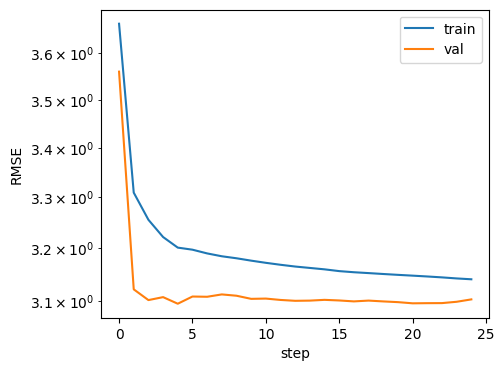

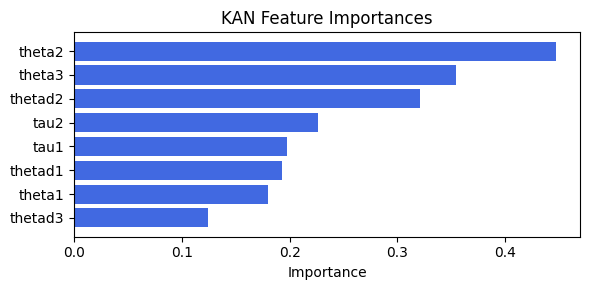

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:29<00:00, 10.94it/s]

[('tau1', 0.3828484648078992), ('theta1', 0.3711763542947258), ('thetad1', 0.36363942387959813), ('tau2', 0.36265802162896077), ('thetad2', 0.2823961520686096), ('theta2', 0.2646763684497473), ('Ex1', 0.21020988084839307), ('theta3', 0.20737142831822894), ('thetad3', 0.18506480443953421)]


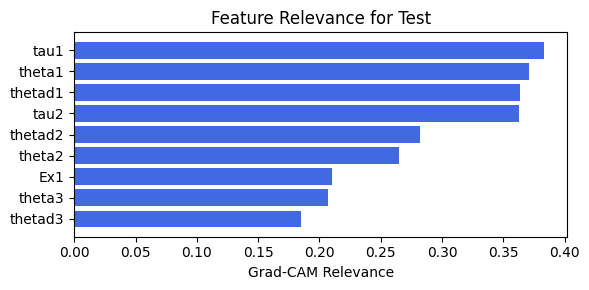

In [87]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.3.7. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.12e+00 | reg: 3.26e+01 |: 100%|█| 25/25 [01:29<00:00,  3.59s/i

saving model version 0.1
Best epoch 2
3.2615931034088135
M_KAN Relevance: 0.8851437568664551
CNN Relevance: 0.11485622078180313
[('theta2', 0.76347584), ('theta3', 0.3965231), ('thetad1', 0.1312603), ('theta1', 0.121444434), ('thetad2', 0.11766633), ('tau1', 0.1128865), ('thetad3', 0.11057703), ('tau2', 0.055508964)]


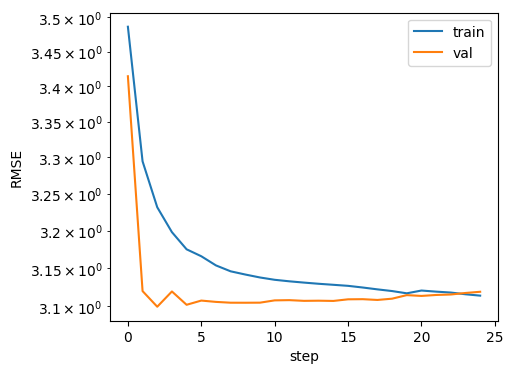

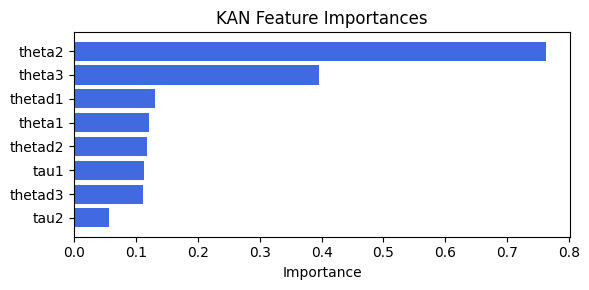

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:30<00:00, 10.92it/s]

[('theta1', 0.37868936466099795), ('thetad1', 0.3509891809062615), ('theta2', 0.3138285919231527), ('tau1', 0.30795835558628487), ('thetad2', 0.2877153659467164), ('tau2', 0.27819433203882427), ('theta3', 0.21764484115025623), ('thetad3', 0.15181772697396276), ('Ex1', 0.12053042005984066)]


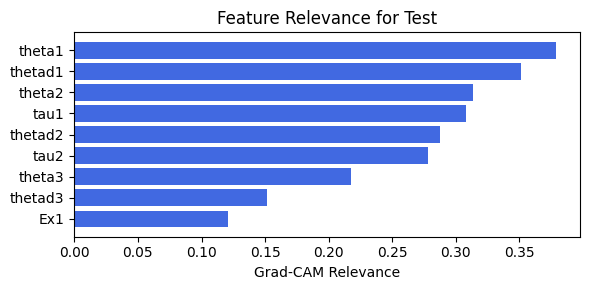

In [88]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

### 2.3.8. width=[8, 4, 1], grid=3, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.13e+00 | reg: 3.58e+01 |: 100%|█| 25/25 [01:29<00:00,  3.60s/i

saving model version 0.1
Best epoch 2
3.2776432037353516
M_KAN Relevance: 0.8635867238044739
CNN Relevance: 0.13641323149204254
[('theta2', 0.5698702), ('theta3', 0.36428404), ('tau1', 0.23432955), ('thetad3', 0.20212097), ('thetad2', 0.16550761), ('theta1', 0.15655339), ('thetad1', 0.13602759), ('tau2', 0.067137256)]


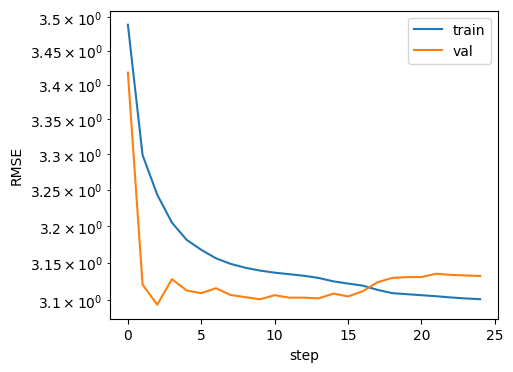

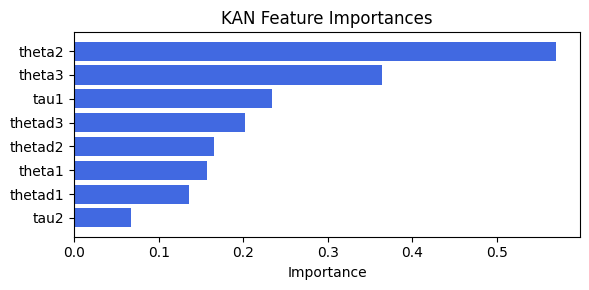

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:26<00:00, 11.22it/s]


[('theta1', 0.3843108787967527), ('thetad1', 0.3516817967353033), ('theta2', 0.3073399032087107), ('tau1', 0.2980022162449655), ('thetad2', 0.2877713951547187), ('tau2', 0.2625061739633342), ('theta3', 0.21080099468093358), ('thetad3', 0.1583703449533099), ('Ex1', 0.13481455036324994)]


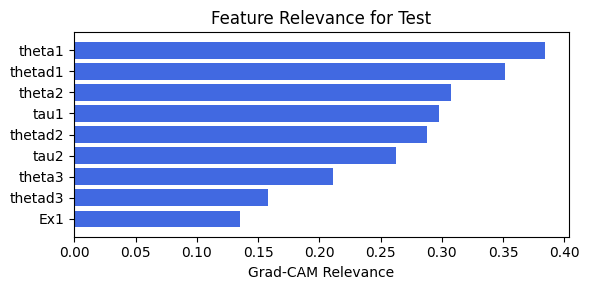

In [89]:
train_and_plot_relevance(Model3_2, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

## 2.3.0 width=[8, 3, 1], grid=5, lamb=0.01

### 2.3.1. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.15e+00 | reg: 6.81e+01 |: 100%|█| 25/25 [10:49<00:00, 25.98s/i


saving model version 0.1
Best epoch 9
3.2689602375030518
M_KAN Relevance: 2.4848972316249274e-05
CNN Relevance: 0.9999751448631287
[('tau1', 0.5222289), ('thetad3', 0.43355966), ('thetad2', 0.2766376), ('thetad1', 0.23996186), ('theta1', 0.21155888), ('theta2', 0.17827885), ('tau2', 0.17498305), ('theta3', 0.12066728)]


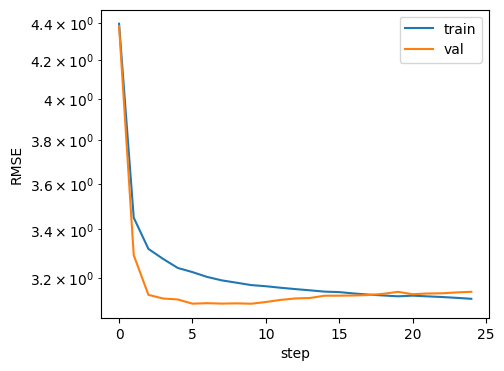

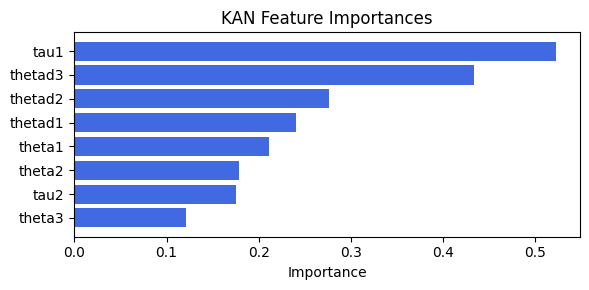

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:25<00:00, 11.28it/s]

[('theta1', 0.3704385616260571), ('tau1', 0.3625380506931969), ('thetad1', 0.3575101598938575), ('thetad2', 0.3334150721837242), ('tau2', 0.3120050060720046), ('theta2', 0.28162698317495305), ('theta3', 0.19804522605286623), ('Ex1', 0.15581451457960918), ('thetad3', 0.1470058641951176)]


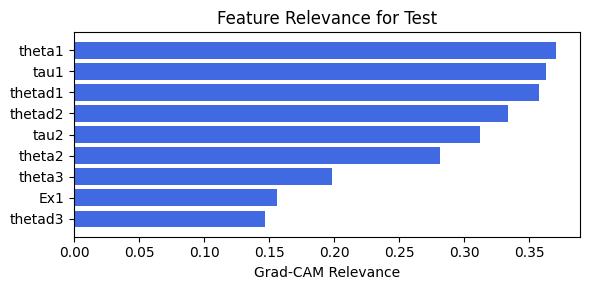

In [123]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.3.2. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.75

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.15e+00 | reg: 7.26e+01 |: 100%|█| 25/25 [10:44<00:00, 25.79s/i


saving model version 0.1
Best epoch 8
3.270750045776367
M_KAN Relevance: 1.2095920283172745e-05
CNN Relevance: 0.9999879002571106
[('thetad3', 0.5057123), ('tau1', 0.36844343), ('theta1', 0.35552925), ('theta2', 0.32808048), ('theta3', 0.20379561), ('thetad2', 0.15051897), ('thetad1', 0.11188307), ('tau2', 0.07965073)]


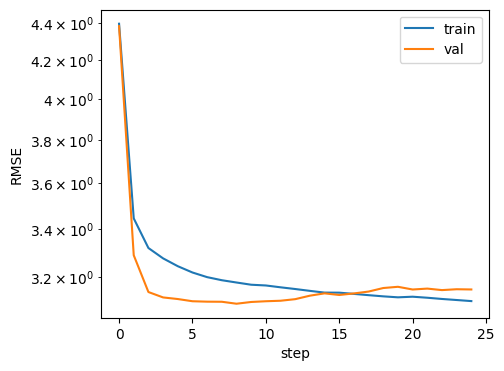

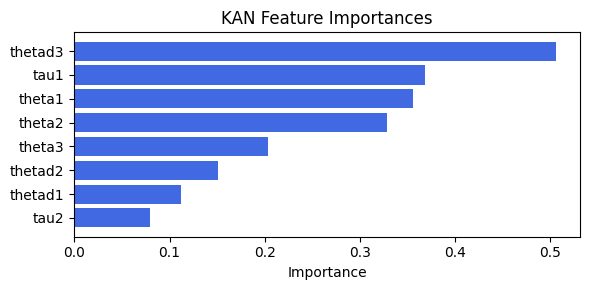

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:29<00:00, 10.95it/s]


[('theta1', 0.363468882524954), ('tau1', 0.3560771939308551), ('thetad1', 0.33391629584577764), ('thetad2', 0.2982945046973019), ('tau2', 0.28978658434625587), ('theta2', 0.2714962349500022), ('theta3', 0.20648397904747634), ('thetad3', 0.1470126060691337), ('Ex1', 0.14183661507161693)]


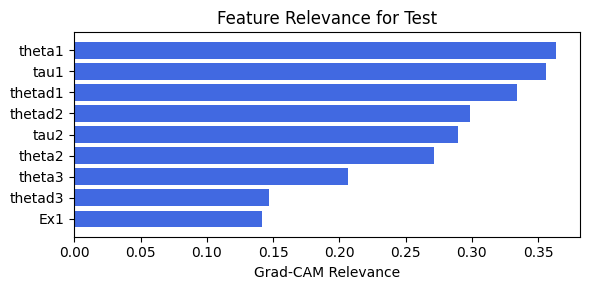

In [124]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.75)

### 2.3.3. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.15e+00 | reg: 7.13e+01 |: 100%|█| 25/25 [12:30<00:00, 30.04s/i

saving model version 0.1
Best epoch 5
3.2923595905303955
M_KAN Relevance: 0.054484445601701736
CNN Relevance: 0.9455155730247498
[('tau2', 0.45155674), ('thetad2', 0.40111786), ('thetad3', 0.3184558), ('theta1', 0.29545903), ('theta3', 0.24653181), ('thetad1', 0.23861718), ('theta2', 0.2079018), ('tau1', 0.15343258)]


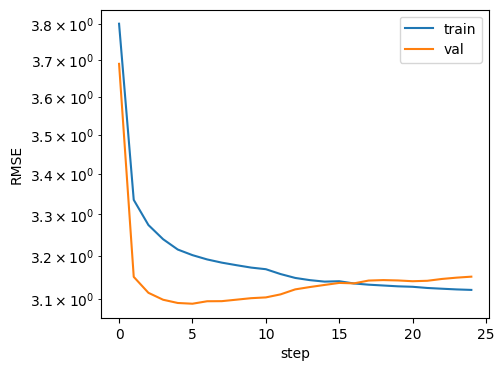

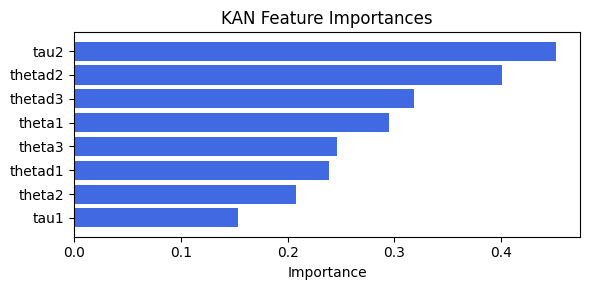

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:29<00:00, 10.94it/s]

[('tau1', 0.3689640404646514), ('theta1', 0.3617017426511132), ('thetad1', 0.3502974799922302), ('tau2', 0.3426163479672741), ('thetad2', 0.33178855813673824), ('theta2', 0.2838037160989903), ('Ex1', 0.21987006956700456), ('theta3', 0.204512848640367), ('thetad3', 0.11243998102578542)]


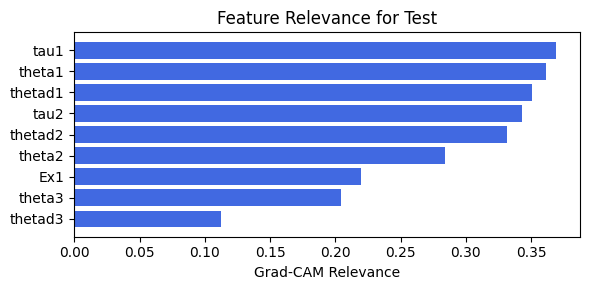

In [125]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.3.4. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.5

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.13e+00 | eval_loss: 3.16e+00 | reg: 7.44e+01 |: 100%|█| 25/25 [12:03<00:00, 28.95s/i


saving model version 0.1
Best epoch 6
3.2757883071899414
M_KAN Relevance: 0.04675547033548355
CNN Relevance: 0.9532445073127747
[('thetad2', 0.5733236), ('thetad1', 0.40793848), ('theta1', 0.37450558), ('theta3', 0.31587455), ('thetad3', 0.282542), ('theta2', 0.1865305), ('tau1', 0.15222752), ('tau2', 0.14169012)]


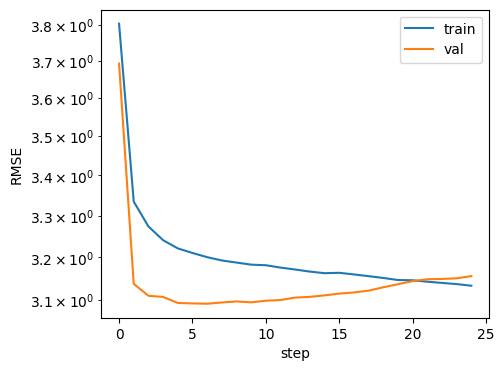

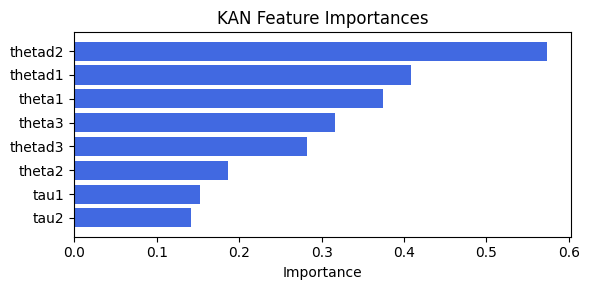

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:24<00:00, 11.37it/s]

[('theta1', 0.3623405890258727), ('thetad1', 0.34191622110124187), ('tau1', 0.33950338431715266), ('tau2', 0.3207320356731554), ('thetad2', 0.3066369890612933), ('theta2', 0.27274315611992667), ('Ex1', 0.2024801050158171), ('theta3', 0.19449370538874827), ('thetad3', 0.0930996319767607)]


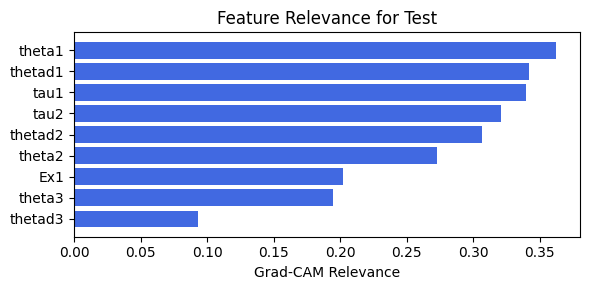

In [126]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.5)

### 2.3.5. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.14e+00 | reg: 8.14e+01 |: 100%|█| 25/25 [11:21<00:00, 27.25s/i

saving model version 0.1
Best epoch 7
3.3052830696105957
M_KAN Relevance: 0.1587645560503006
CNN Relevance: 0.8412354588508606
[('theta2', 0.56118745), ('thetad3', 0.42072365), ('theta3', 0.24282494), ('tau2', 0.20192876), ('tau1', 0.18324104), ('theta1', 0.14726274), ('thetad1', 0.13583162), ('thetad2', 0.116666734)]


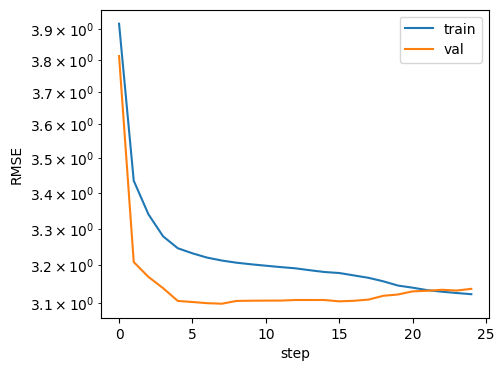

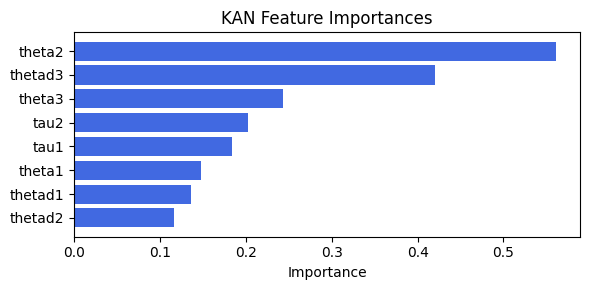

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:31<00:00, 10.84it/s]


[('tau1', 0.42036384442894165), ('tau2', 0.3854827540122773), ('theta1', 0.36593151530844703), ('thetad1', 0.361079092867402), ('thetad2', 0.2868393501120297), ('theta2', 0.2711278278623247), ('theta3', 0.23655530648580395), ('thetad3', 0.18809886836085501), ('Ex1', 0.18591433048714662)]


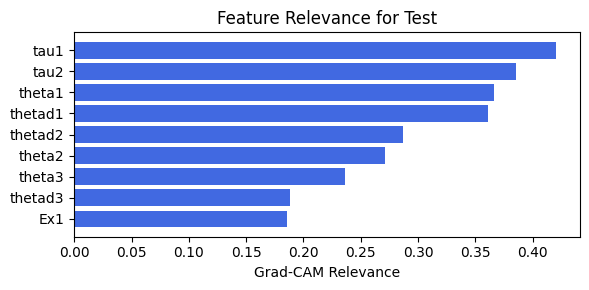

In [127]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.3.6. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.25

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.12e+00 | eval_loss: 3.14e+00 | reg: 8.16e+01 |: 100%|█| 25/25 [12:05<00:00, 29.01s/i


saving model version 0.1
Best epoch 14
3.2779908180236816
M_KAN Relevance: 0.12468475103378296
CNN Relevance: 0.875315248966217
[('theta3', 0.4915696), ('thetad2', 0.39779577), ('theta2', 0.37599358), ('theta1', 0.31076506), ('thetad1', 0.23789033), ('tau1', 0.2375384), ('thetad3', 0.22937605), ('tau2', 0.19062792)]


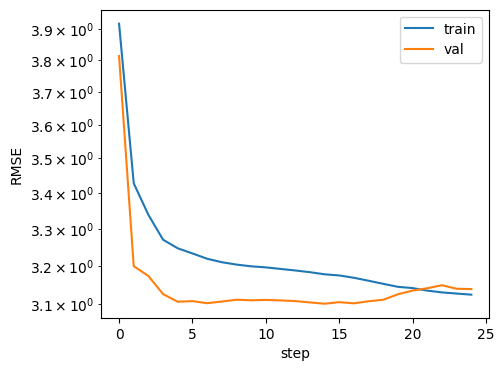

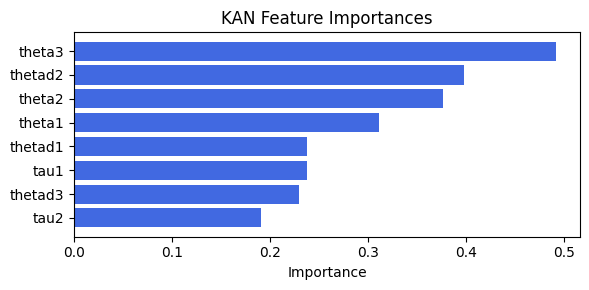

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:23<00:00, 11.43it/s]


[('tau2', 0.46480395094398747), ('tau1', 0.45968143132792144), ('theta1', 0.34658235241335805), ('thetad1', 0.34413108367637957), ('Ex1', 0.32257414509853677), ('thetad2', 0.2582816174550402), ('theta2', 0.24702541915835263), ('theta3', 0.23877453293753406), ('thetad3', 0.18157780801562298)]


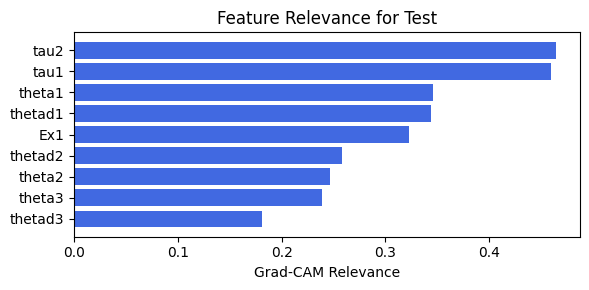

In [128]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.25)

### 2.3.7. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.11e+00 | eval_loss: 3.19e+00 | reg: 7.49e+01 |: 100%|█| 25/25 [15:32<00:00, 37.30s/i


saving model version 0.1
Best epoch 5
3.3225462436676025
M_KAN Relevance: 0.32605066895484924
CNN Relevance: 0.6739493608474731
[('theta2', 0.71053696), ('thetad3', 0.37163448), ('theta3', 0.23369005), ('thetad2', 0.20669858), ('theta1', 0.19948702), ('thetad1', 0.13402317), ('tau1', 0.114580154), ('tau2', 0.07349051)]


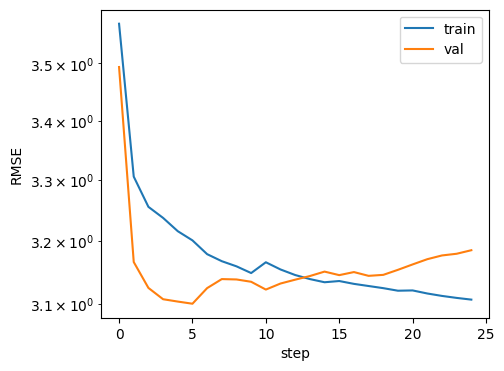

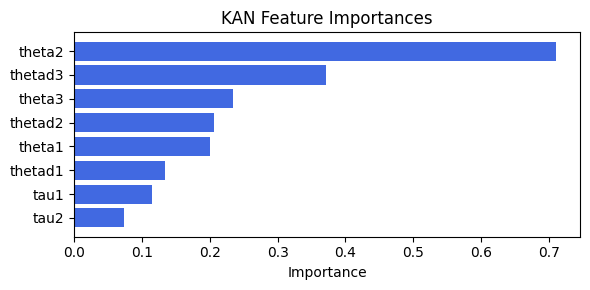

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:44<00:00,  9.95it/s]

[('tau2', 0.5070686510654253), ('tau1', 0.4781505281236578), ('thetad1', 0.3149351261991148), ('theta1', 0.28455269581025233), ('Ex1', 0.2788638525493721), ('theta3', 0.2416839757105313), ('thetad3', 0.2374397239464837), ('thetad2', 0.22355284619776866), ('theta2', 0.2150329524133942)]


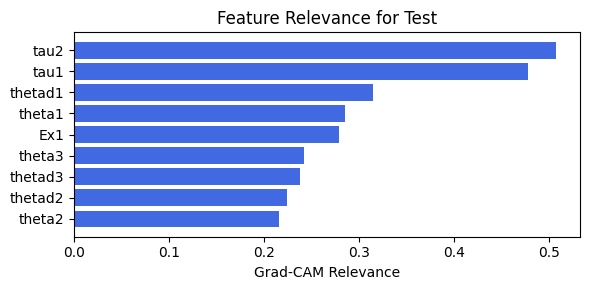

In [129]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

### 2.3.8. width=[8, 3, 1], grid=5, lamb=0.01 | alpha=0.1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3_2


| train_loss: 3.10e+00 | eval_loss: 3.19e+00 | reg: 7.48e+01 |: 100%|█| 25/25 [18:08<00:00, 43.56s/i

saving model version 0.1
Best epoch 4
3.3283212184906006
M_KAN Relevance: 0.3208526074886322
CNN Relevance: 0.6791474223136902
[('theta2', 0.8185854), ('thetad2', 0.21410474), ('thetad3', 0.21292025), ('theta3', 0.20170824), ('thetad1', 0.17560379), ('tau1', 0.16250461), ('theta1', 0.16064851), ('tau2', 0.137392)]


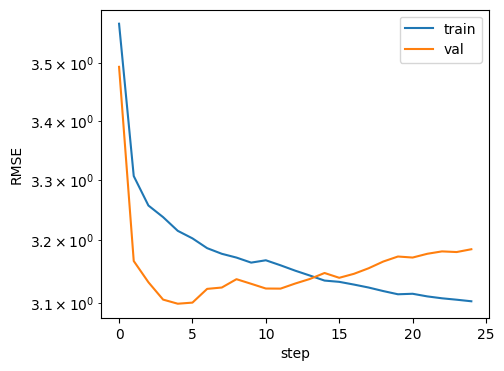

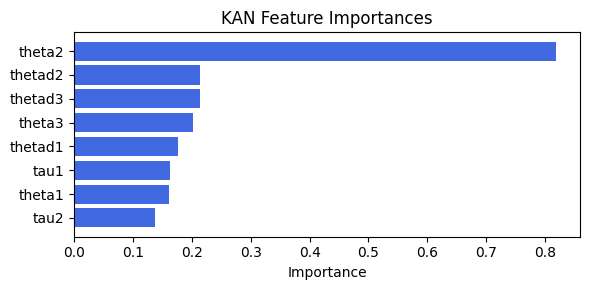

Computing Grad-CAM: 100%|██████████| 1639/1639 [02:48<00:00,  9.74it/s]


[('tau2', 0.5015377141756725), ('tau1', 0.47558203694292306), ('thetad1', 0.3067884577725616), ('Ex1', 0.2997669050011205), ('theta1', 0.2831243205997883), ('theta3', 0.25134473219378095), ('thetad3', 0.22863278572027182), ('thetad2', 0.22370363632574633), ('theta2', 0.21247809406589774)]


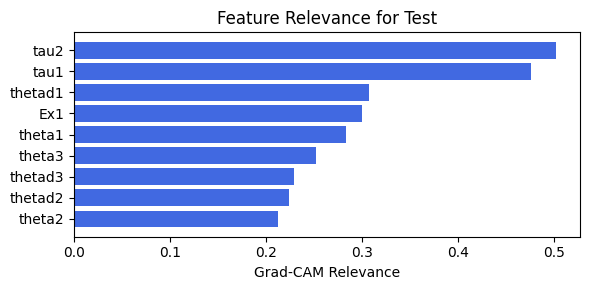

In [130]:
train_and_plot_relevance(Model3_2, kan_neurons=3, kan_grid=5, cnn_bottleneck_dim=-1, lamb=0.01, steps=25, alpha=0.1)

# Hibrid Model3 training ✅ Top 2 Configurations

### 1. width=[8, 4, 1], grid=3, lamb=0.01| best_epoch=10 | loss=3.21696

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.10e+00 | eval_loss: 3.14e+00 | reg: 4.28e+01 |: 100%|█| 40/40 [00:39<00:00,  1.02it/


saving model version 0.1
Best epoch 15
3.2704854011535645


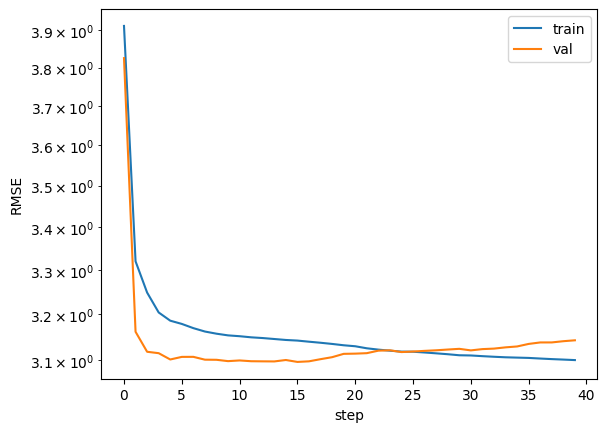

In [101]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=4, kan_grid=3, cnn_bottleneck_dim=1)
best_model_state, metrics3, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics3['train_loss'], metrics3['eval_loss'])

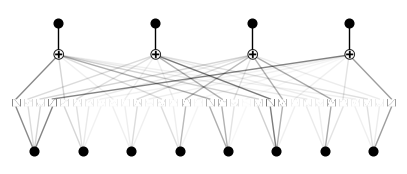

In [45]:
model.m_kan.plot()

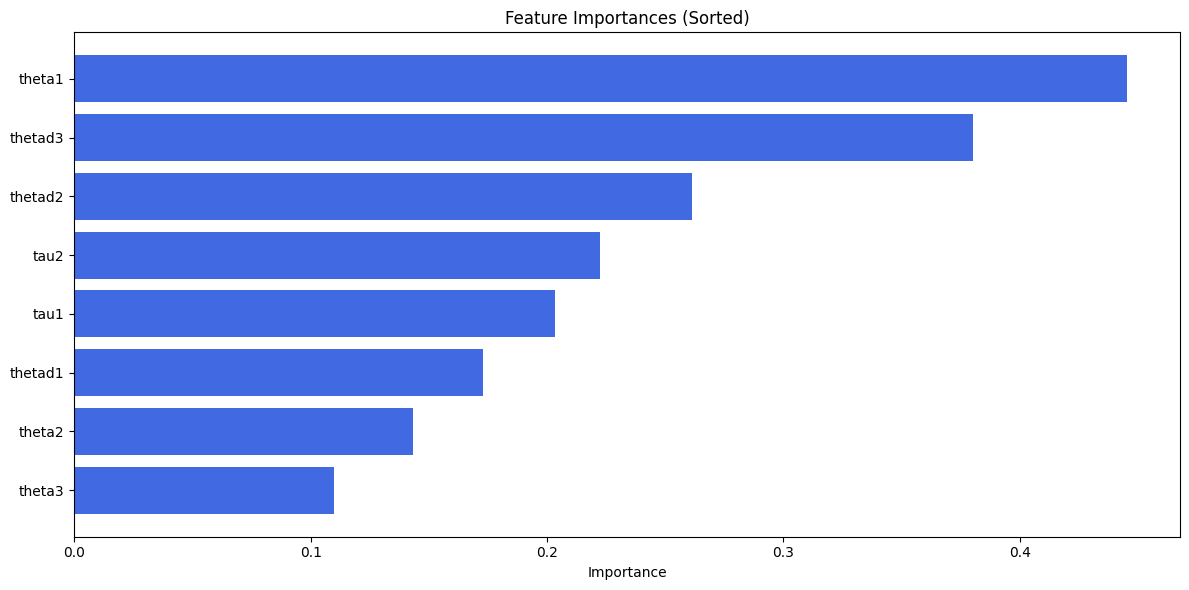

In [46]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

In [42]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

Computing Grad-CAM:   0%|          | 0/1639 [00:00<?, ?it/s]


AttributeError: 'Model3_0' object has no attribute 'cnn_branch'

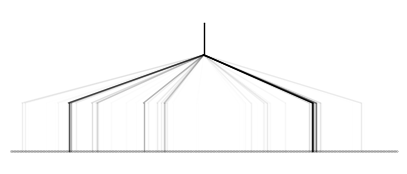

In [47]:
model.final_kan.plot()

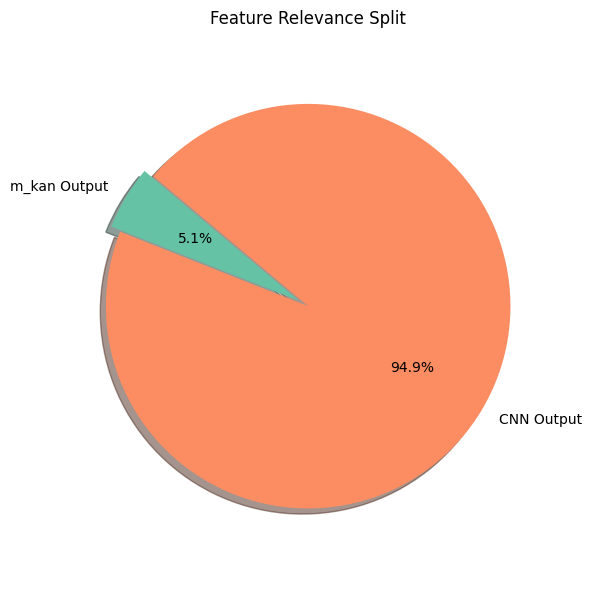

In [103]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=4)

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

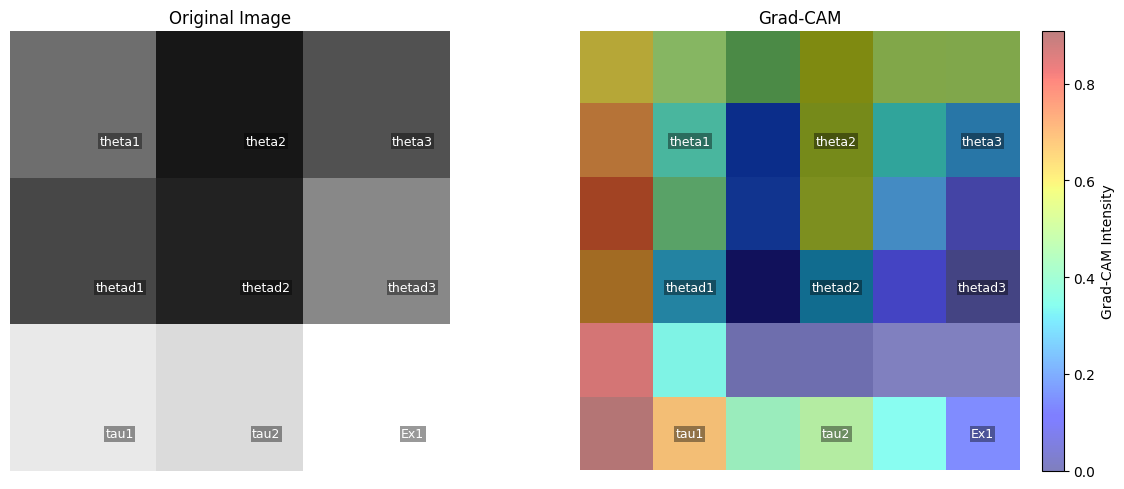

In [50]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:53<00:00,  2.76it/s] 


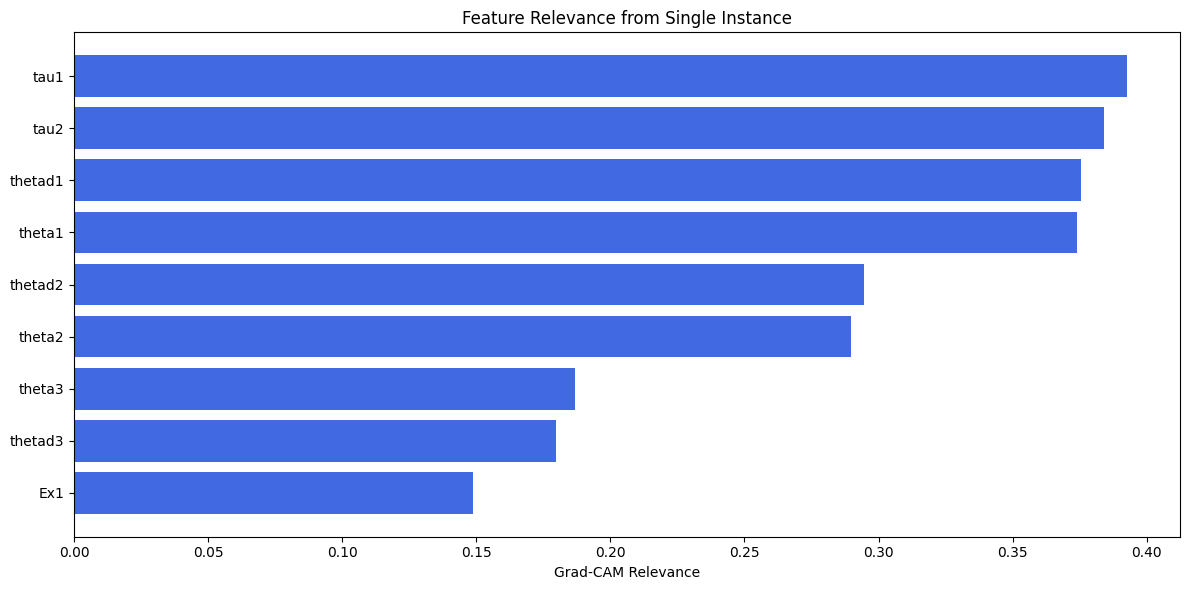

In [51]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. width=[8, 3, 1], grid=5, lamb=0.01| best_epoch=12 | loss=3.21744

In [52]:
del model
torch.cuda.empty_cache()
gc.collect()

13172740

In [42]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=3, kan_grid=5)
best_model_state, metrics3,_ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics3['train_loss'], metrics3['val_loss'])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.40e+00 | eval_loss: 3.17e+00 | reg: 1.19e+02 |:   8%| | 3/40 [00:18<03:44,  6.06s/it


KeyboardInterrupt: 

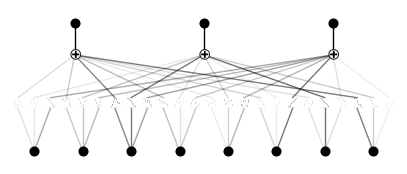

In [54]:
model.m_kan.plot()

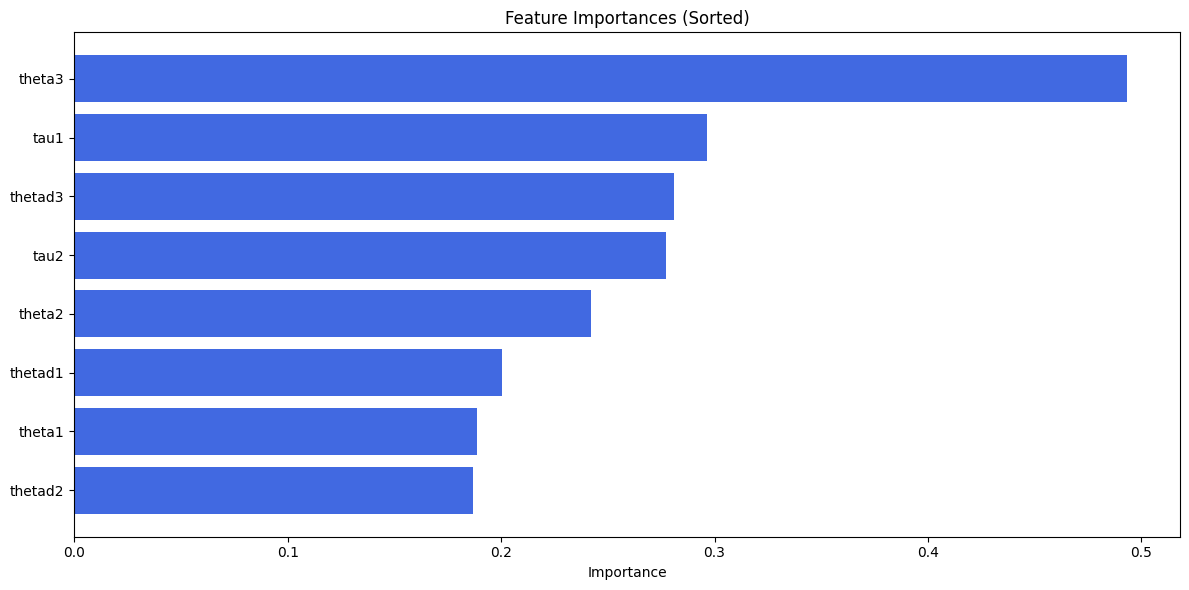

In [55]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

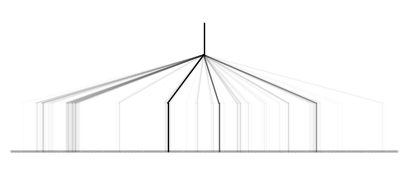

In [56]:
model.final_kan.plot()

In [57]:
feature_score = model.final_kan.feature_score

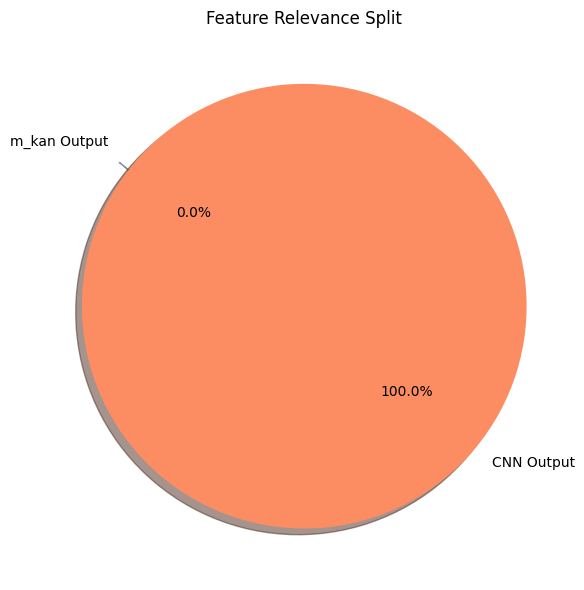

In [58]:
plot_mkan_vs_cnn_relevance(feature_score, mkan_len=3)

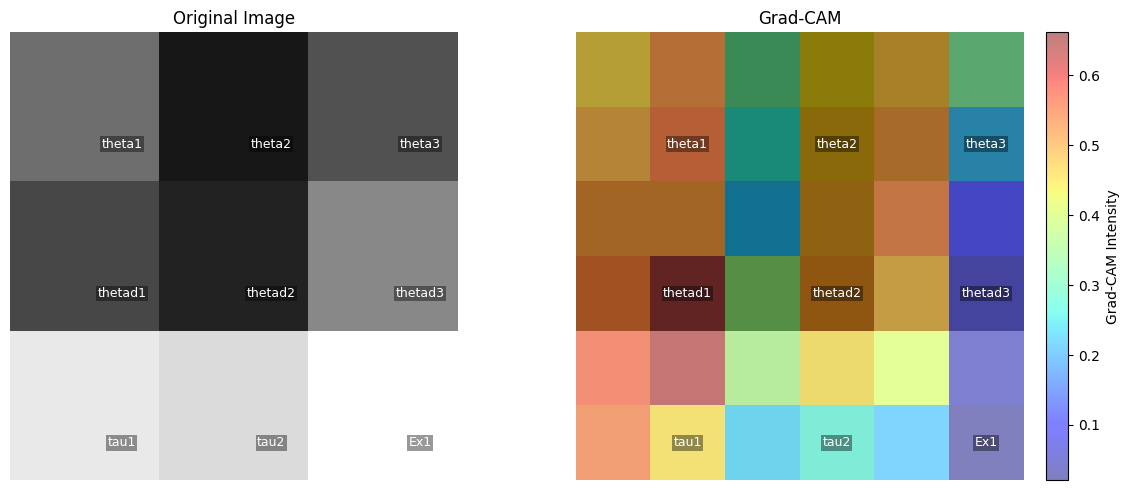

In [59]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:06<00:00,  3.00it/s]


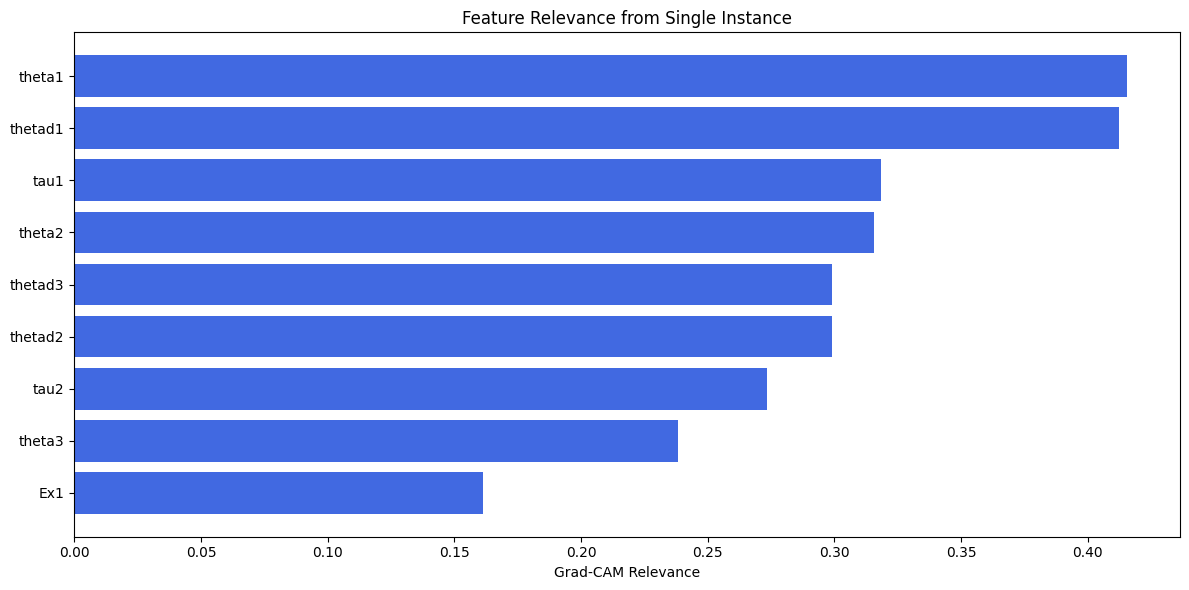

In [60]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

# Hybrid Model4 training ✅ Top 2 Configurations

### 1. width=[8, 1, 1], grid=4, lamb=0.01| best_epoch=7 | loss=3.23119

In [61]:
del model
torch.cuda.empty_cache()
gc.collect()

13370161

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.45e+00 | eval_loss: 3.71e+00 | reg: 9.67e+01 |: 100%|█| 40/40 [13:51<00:00, 20.80s/i


saving model version 0.1
Best epoch 8
3.7815768718719482


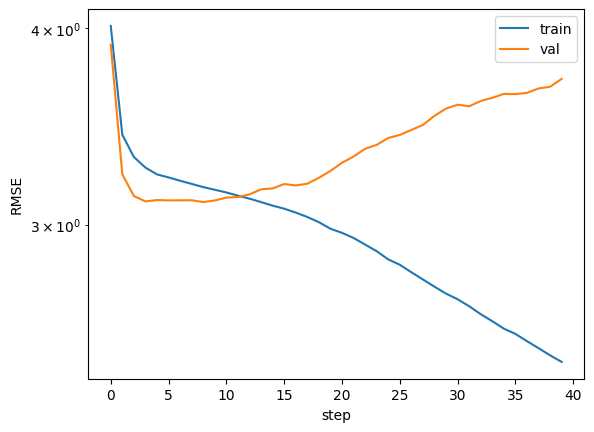

In [62]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=1, kan_grid=4)  # Attempt to create Model4
best_model_state, metrics4, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics4['train_loss'], metrics4['eval_loss'])

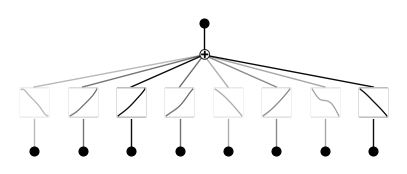

In [63]:
model.m_kan.plot()

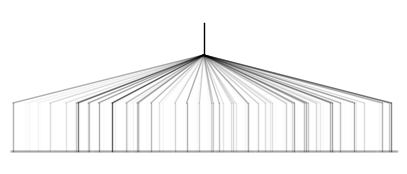

In [64]:
model.final_kan.plot()

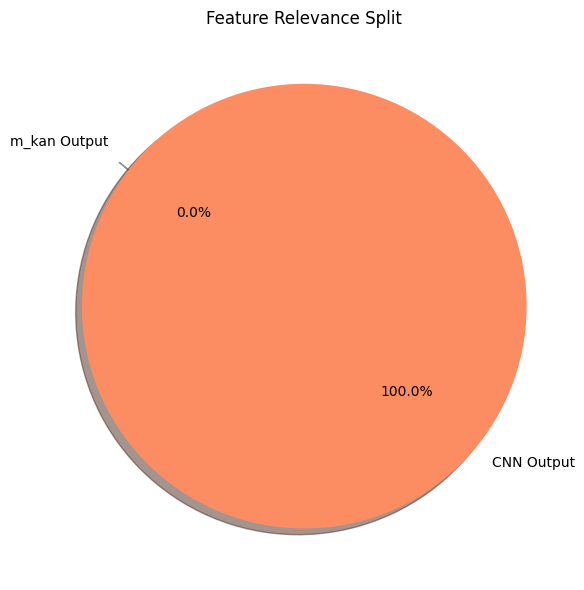

In [65]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=1)

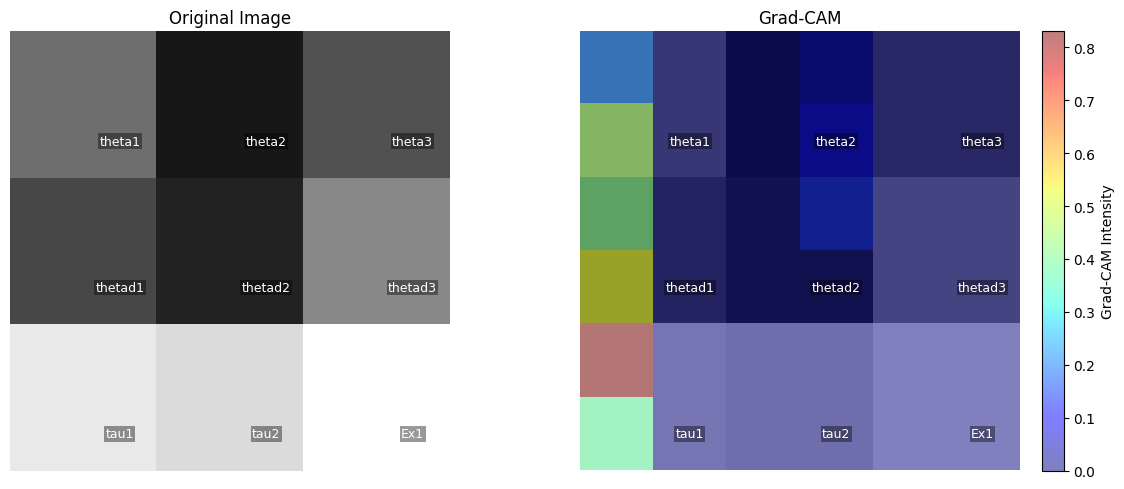

In [66]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [07:58<00:00,  3.43it/s] 


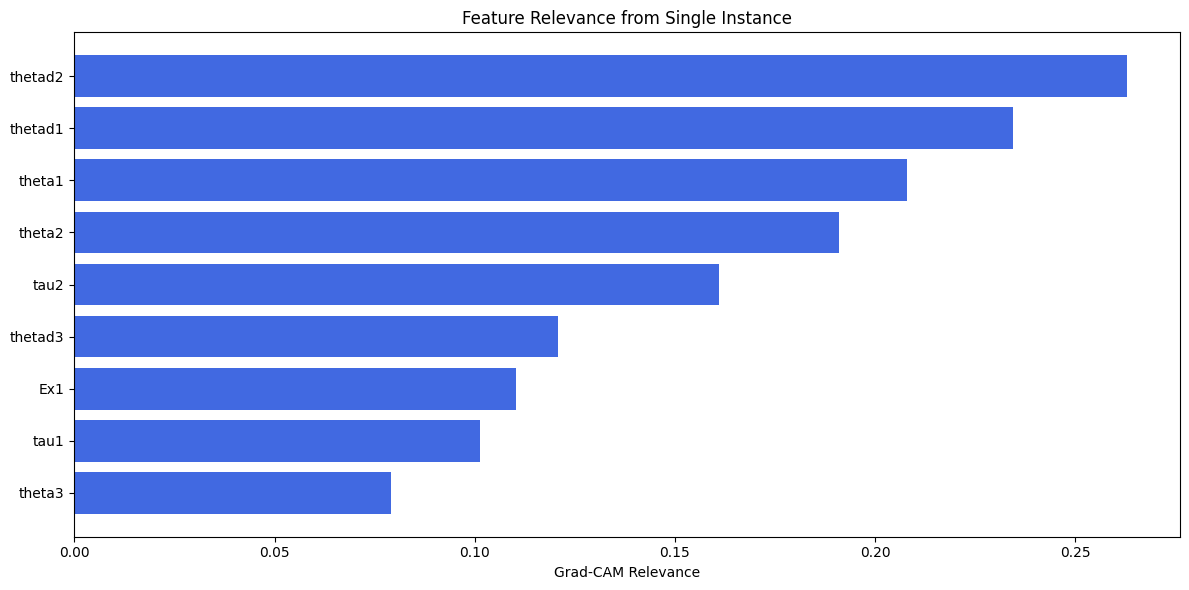

In [67]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. width=[8, 2, 1], grid=4, lamb=0.1| best_epoch=7 | loss=3.23543

In [70]:
del model
torch.cuda.empty_cache()
gc.collect()

481

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.23e+00 | eval_loss: 3.22e+00 | reg: 2.22e+01 |: 100%|█| 40/40 [06:48<00:00, 10.22s/i


saving model version 0.1
Best epoch 11
3.356964588165283


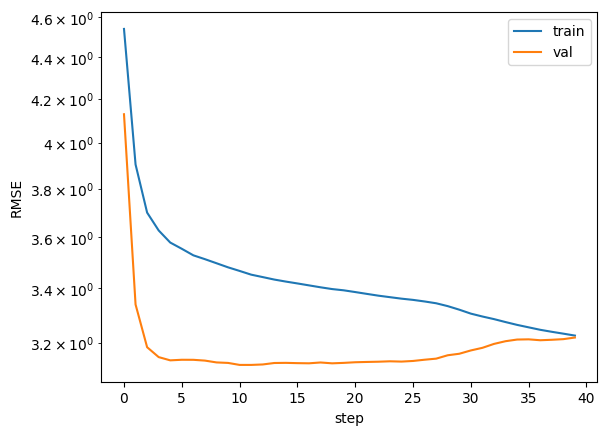

In [71]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=2, kan_grid=4)  # Attempt to create Model4
best_model_state, metrics4, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.1)
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics4['train_loss'], metrics4['eval_loss'])

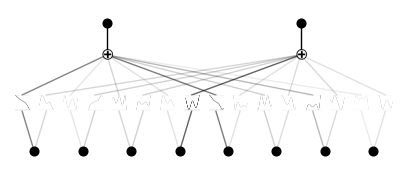

In [72]:
model.m_kan.plot()

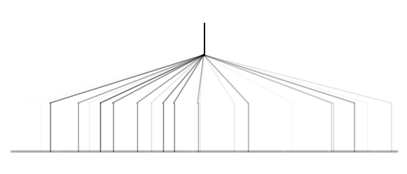

In [73]:
model.final_kan.plot()

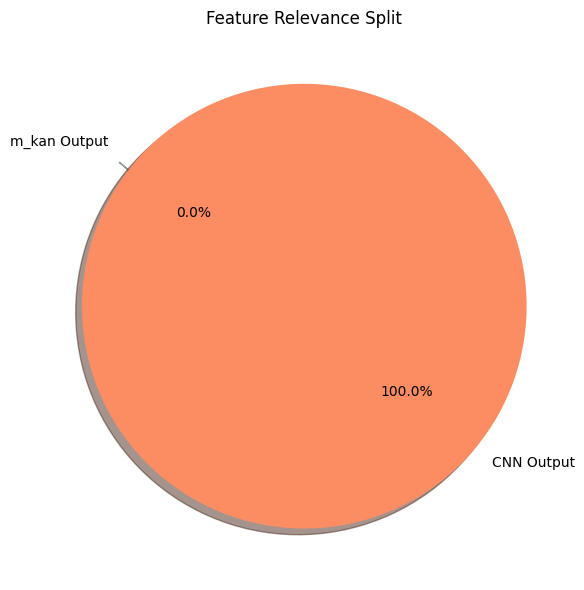

In [74]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=2)

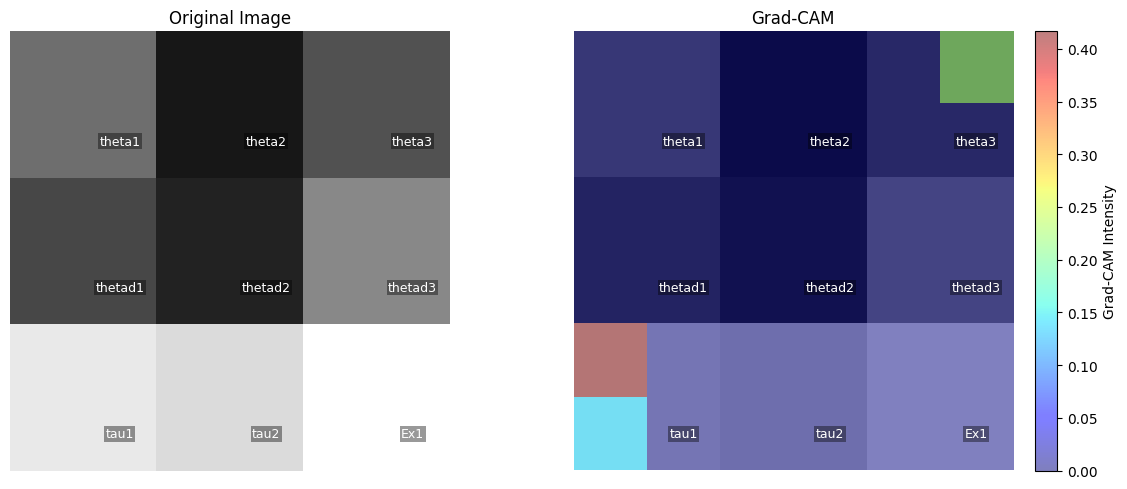

In [75]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:03<00:00,  3.39it/s] 


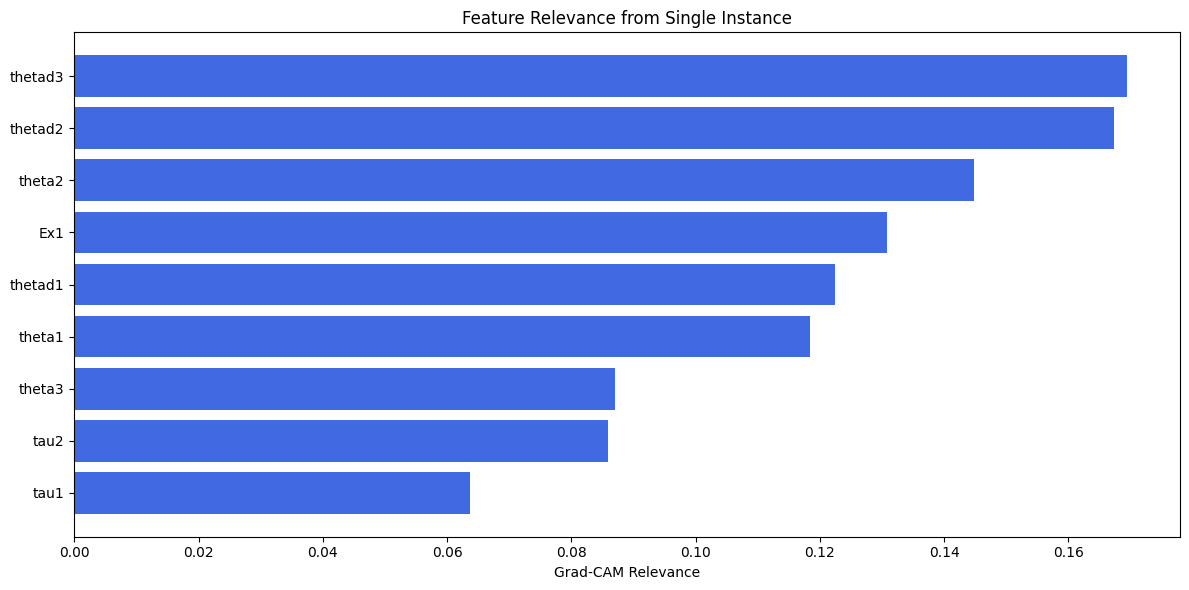

In [76]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

# Bonus Hybrid

In [49]:
class Model5(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model5, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 8, 8]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        self.final_kan = KAN(
            width=[self.flat_size, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        cnn_input = cnn_input.to(self.device)
        
        return self.cnn_branch(cnn_input)  # Process image input

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [59]:
def fit_hybrid_dataloaders2(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.final_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.final_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.final_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {'train_loss': [], 'eval_loss': [], 'reg': []}

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)
        cached_loss = {}
        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.final_kan.node_attribute()
                reg_val_inner = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()

            cached_loss['loss'] = loss_val_inner.detach()
            cached_loss['reg'] = reg_val_inner.detach()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = cached_loss['loss']
            reg_val = cached_loss['reg']
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.final_kan, "save_act") and model.final_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.final_kan.node_attribute()
                reg_val = model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        with torch.no_grad():
            mlp_eval = dataset["val_input"][eval_indices]
            img_eval = dataset["val_img"][eval_indices]
            target_eval = dataset["val_label"][eval_indices]
            eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.final_kan, "save_act", False)
            model.final_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.final_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.final_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.final_kan, "log_history"):
        model.final_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [78]:
del model
torch.cuda.empty_cache()
gc.collect()

215554

In [65]:
model = try_create_model(Model5, attributes, imgs_shape, kan_neurons=3, kan_grid=4)  # Attempt to create Model4

checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model5


In [66]:
best_model_state, metrics5, _ = fit_hybrid_dataloaders2(model, dataset, opt="LBFGS", steps=10, lamb=0.01)

| train_loss: 3.19e+00 | eval_loss: 3.10e+00 | reg: 5.06e+01 |: 100%|█| 10/10 [00:39<00:00,  3.91s/i

saving model version 0.1
Best epoch 9


3.2302682399749756


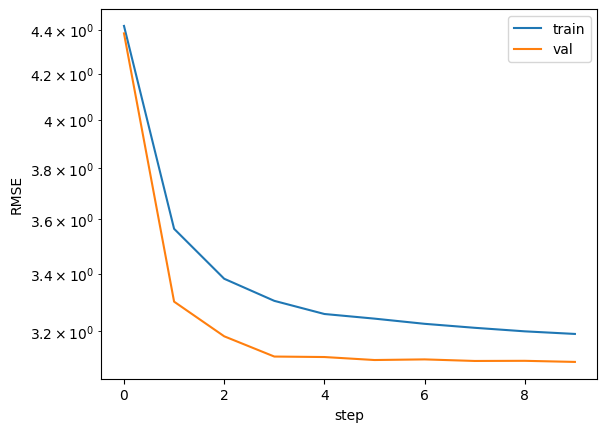

In [67]:
plot_training_RMSE(model, best_model_state, average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), metrics5['train_loss'], metrics5['eval_loss'])

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

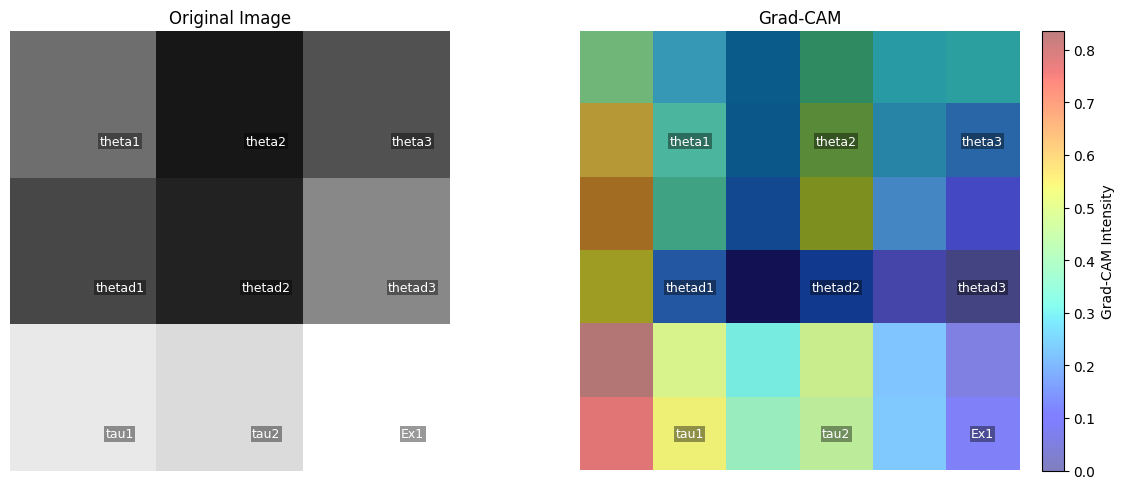

In [68]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM:   2%|▏         | 26/1639 [00:24<25:31,  1.05it/s]


KeyboardInterrupt: 

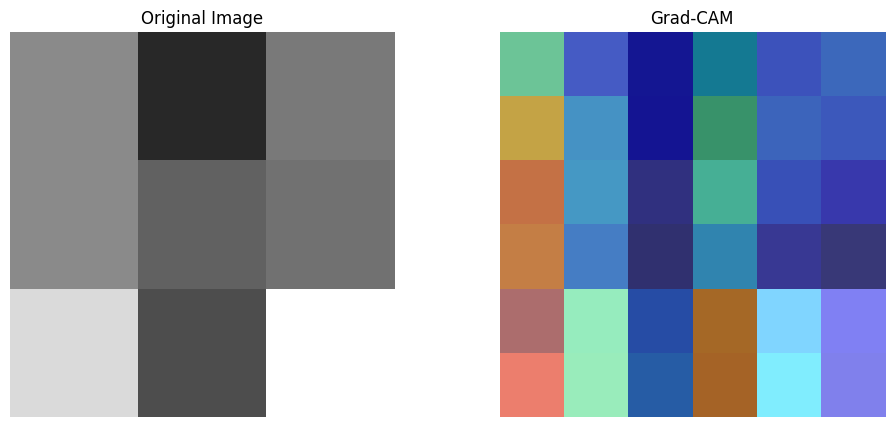

In [69]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)